# 🛡️ Phase 4: Adversarial Robustness Evaluation

## Tri-Objective Robust XAI for Medical Imaging

**Author:** Viraj Pankaj Jain  
**Institution:** University of Glasgow  
**Date:** November 2025

---

## 📋 Overview

This notebook evaluates the **adversarial robustness** of baseline ResNet-50 models trained on ISIC 2018 dermoscopy images. We systematically assess vulnerability to:

| Attack | Type | Strength | Use Case |
|--------|------|----------|----------|
| **FGSM** | Gradient-based | Fast, single-step | Real-time threat assessment |
| **PGD** | Iterative | Strong, multi-step | Reliable robustness benchmark |
| **C&W** | Optimization | Strongest, minimal perturbation | Worst-case security analysis |

## 🎯 Research Questions Addressed

- **RQ1:** How vulnerable are standard CNNs to adversarial attacks in medical imaging?
- **RQ2:** How does attack strength (ε) affect model accuracy degradation?
- **RQ3:** Which skin lesion classes are most vulnerable to adversarial perturbations?

## 📊 Evaluation Protocol

```
┌─────────────────────────────────────────────────────────────────┐
│  ADVERSARIAL EVALUATION PIPELINE                                │
├─────────────────────────────────────────────────────────────────┤
│  1. Load trained baseline models (Seeds: 42, 123, 456)          │
│  2. Evaluate clean accuracy (sanity check)                      │
│  3. Generate adversarial examples at ε ∈ {2/255, 4/255, 8/255}  │
│  4. Measure robust accuracy under each attack                   │
│  5. Analyze per-class vulnerability                             │
│  6. Visualize perturbations and decision boundaries             │
│  7. Statistical analysis across seeds                           │
└─────────────────────────────────────────────────────────────────┘
```

## ⚡ Hardware Requirements

- **Recommended:** NVIDIA A100 (40GB) - Full evaluation ~15 minutes
- **Minimum:** NVIDIA T4 (16GB) - Full evaluation ~45 minutes

---

In [2]:
# ============================================================================
# CELL 1: ENVIRONMENT SETUP
# ============================================================================
import sys
import os
from pathlib import Path

print("=" * 70)
print("PHASE 4: ADVERSARIAL ROBUSTNESS EVALUATION")
print("=" * 70)

# Mount Google Drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
    print("✅ Google Colab detected, Drive mounted")
except ImportError:
    IN_COLAB = False
    print("✅ Local environment detected")

# Clone/update repository
if IN_COLAB:
    REPO_PATH = Path('/content/tri-objective-robust-xai-medimg')
    if not REPO_PATH.exists():
        !git clone https://github.com/viraj1011JAIN/tri-objective-robust-xai-medimg.git {REPO_PATH}
        print("✅ Repository cloned")
    else:
        os.chdir(REPO_PATH)
        !git pull origin main
        print("✅ Repository updated")

    os.chdir(REPO_PATH)
    sys.path.insert(0, str(REPO_PATH))
    PROJECT_ROOT = REPO_PATH
else:
    PROJECT_ROOT = Path.cwd().parent
    sys.path.insert(0, str(PROJECT_ROOT))

print(f"📁 Project root: {PROJECT_ROOT}")

PHASE 4: ADVERSARIAL ROBUSTNESS EVALUATION
Mounted at /content/drive
✅ Google Colab detected, Drive mounted
Cloning into '/content/tri-objective-robust-xai-medimg'...
remote: Enumerating objects: 1670, done.
remote: Counting objects: 100% (611/611), done.
remote: Compressing objects: 100% (491/491), done.
remote: Total 1670 (delta 208), reused 482 (delta 114), pack-reused 1059 (from 1)
Receiving objects: 100% (1670/1670), 35.05 MiB | 39.23 MiB/s, done.
Resolving deltas: 100% (591/591), done.
✅ Repository cloned
📁 Project root: /content/tri-objective-robust-xai-medimg


In [3]:
# ============================================================================
# CELL 2: INSTALL DEPENDENCIES
# ============================================================================
!pip install -q torch torchvision --index-url https://download.pytorch.org/whl/cu121
!pip install -q timm albumentations scikit-learn pandas matplotlib seaborn tqdm mlflow
!pip install -q plotly kaleido scipy statsmodels
print("✅ Dependencies installed")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 124.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.8/76.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.9/753.9 kB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 4.6 MB/s eta 0:00:00
✅ Dependencies installed


In [4]:
# ============================================================================
# CELL 3: IMPORTS
# ============================================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm.auto import tqdm
from pathlib import Path
import json
import time
from datetime import datetime
from typing import Dict, List, Tuple, Optional, Any
import warnings
warnings.filterwarnings('ignore')

# Albumentations for transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image

# Metrics
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    confusion_matrix, roc_auc_score
)
from scipy import stats

# Project imports - Attacks
from src.attacks.fgsm import FGSM, FGSMConfig
from src.attacks.pgd import PGD, PGDConfig
from src.attacks.cw import CarliniWagner, CWConfig

# Project imports - Data & Model
from src.datasets.isic import ISICDataset
from src.models.build import build_model
from src.utils.reproducibility import set_global_seed

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    # Enable TF32 for A100
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    torch.backends.cudnn.benchmark = True

✅ Using device: cuda
   GPU: NVIDIA A100-SXM4-80GB
   Memory: 85.2 GB


In [5]:
# ============================================================================
# CELL 4: CONFIGURATION
# ============================================================================
print("=" * 70)
print("CONFIGURATION")
print("=" * 70)

CONFIG = {
    # Data paths (Google Drive)
    'data_root': Path('/content/drive/MyDrive/data/data/isic_2018'),
    'checkpoint_dir': Path('/content/drive/MyDrive/checkpoints/baseline'),
    'results_dir': Path('/content/drive/MyDrive/results/phase4'),

    # Model
    'model_name': 'resnet50',
    'num_classes': 7,

    # Evaluation settings
    'batch_size': 32,  # Reduced for stability during attacks
    'num_workers': 0,  # Set to 0 for Colab (avoids multiprocessing errors)
    'image_size': 224,

    # Seeds to evaluate
    'seeds': [42, 123, 456],

    # Attack configurations
    'epsilons': [2/255, 4/255, 8/255],
    'pgd_steps': 20,  # Reduced from 40 for faster evaluation (still effective)
    'cw_iterations': 50,  # Reduced from 100 for faster evaluation

    # Class names
    'class_names': ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC'],
}

# Class descriptions for visualization labels
CLASS_DESCRIPTIONS = {
    'AKIEC': 'Actinic Keratoses (pre-cancerous)',
    'BCC': 'Basal Cell Carcinoma (cancerous)',
    'BKL': 'Benign Keratosis (benign)',
    'DF': 'Dermatofibroma (benign)',
    'MEL': 'Melanoma (malignant)',
    'NV': 'Melanocytic Nevi (moles)',
    'VASC': 'Vascular Lesions (blood vessel)',
}

# ImageNet normalization
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Create output directories
CONFIG['results_dir'].mkdir(parents=True, exist_ok=True)
(CONFIG['results_dir'] / 'figures').mkdir(exist_ok=True)

print(f"📊 Model: {CONFIG['model_name']}")
print(f"📊 Seeds: {CONFIG['seeds']}")
print(f"📊 Epsilons: {[f'{int(e*255)}/255' for e in CONFIG['epsilons']]}")
print(f"📊 Batch size: {CONFIG['batch_size']}")
print(f"📁 Data: {CONFIG['data_root']}")
print(f"📁 Checkpoints: {CONFIG['checkpoint_dir']}")
print(f"📁 Results: {CONFIG['results_dir']}")

CONFIGURATION
📊 Model: resnet50
📊 Seeds: [42, 123, 456]
📊 Epsilons: ['2/255', '4/255', '8/255']
📊 Batch size: 32
📁 Data: /content/drive/MyDrive/data/data/isic_2018
📁 Checkpoints: /content/drive/MyDrive/checkpoints/baseline
📁 Results: /content/drive/MyDrive/results/phase4


In [6]:
# ============================================================================
# CELL 5: DATA PREPARATION
# ============================================================================
print("=" * 70)
print("DATA PREPARATION")
print("=" * 70)

# Load and fix metadata
metadata_path = CONFIG['data_root'] / 'metadata.csv'
print(f"📄 Loading metadata: {metadata_path}")

df = pd.read_csv(metadata_path)
print(f"   Total samples: {len(df)}")

# Fix path separators
if 'image_path' in df.columns:
    df['image_path'] = df['image_path'].str.replace('\\', '/', regex=False)
    print("   ✅ Fixed path separators")

# Save fixed metadata
fixed_path = CONFIG['data_root'] / 'metadata_fixed.csv'
df.to_csv(fixed_path, index=False)

# Show test split info
test_df = df[df['split'] == 'test']
print(f"\n📊 Test samples: {len(test_df)}")
print(f"📊 Test class distribution:")
print(test_df['label'].value_counts())

DATA PREPARATION
📄 Loading metadata: /content/drive/MyDrive/data/data/isic_2018/metadata.csv
   Total samples: 11720
   ✅ Fixed path separators

📊 Test samples: 1512
📊 Test class distribution:
label
NV       909
BKL      217
MEL      171
BCC       93
DF        44
AKIEC     43
VASC      35
Name: count, dtype: int64


In [7]:
# ============================================================================
# CELL 6: CREATE TEST DATASET
# ============================================================================
print("=" * 70)
print("CREATING TEST DATASET")
print("=" * 70)

# Test transforms - NO normalization (attacks need [0,1] range)
test_transforms = A.Compose([
    A.Resize(CONFIG['image_size'], CONFIG['image_size']),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),  # Keep in [0, 1]
    ToTensorV2()
])

# Create test dataset
print(f"📁 Data root: {CONFIG['data_root']}")
print(f"📄 CSV path: {fixed_path}")

test_dataset = ISICDataset(
    root=str(CONFIG['data_root']),
    split='test',
    transforms=test_transforms,
    csv_path=str(fixed_path),
    image_column='image_path',
    label_column='label'
)

print(f"\n📊 Dataset created with {len(test_dataset)} samples")

# Create dataloader - Use num_workers=0 in Colab to avoid multiprocessing issues
test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=0,  # Set to 0 for Colab compatibility (avoids multiprocessing errors)
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"✅ Test samples: {len(test_dataset)}")
print(f"✅ Batches: {len(test_loader)}")
print(f"✅ Classes: {CONFIG['class_names']}")

# ============================================================================
# VERIFY DATALOADER CAN BE ITERATED
# ============================================================================
print("\n🔍 Verifying DataLoader can be iterated...")

if len(test_dataset) == 0:
    print("❌ ERROR: Dataset has 0 samples!")
    print("   🔍 Check that test split exists in metadata CSV")
    print(f"   📄 CSV: {fixed_path}")
else:
    # Test iteration - get first batch
    try:
        batch_count = 0
        sample_count = 0

        for batch in test_loader:
            batch_count += 1
            if len(batch) == 3:
                imgs, lbls, _ = batch
            else:
                imgs, lbls = batch
            sample_count += len(lbls)

            if batch_count == 1:
                print(f"   ✅ First batch: images={imgs.shape}, labels={lbls.shape}")
                print(f"   ✅ Image range: [{imgs.min():.3f}, {imgs.max():.3f}]")
                print(f"   ✅ Labels in batch: {lbls.unique().tolist()}")

            # Just check first few batches
            if batch_count >= 3:
                break

        print(f"   ✅ Successfully iterated {batch_count} batches ({sample_count} samples)")
        print(f"   ✅ Full iteration should process {len(test_loader)} batches")

    except StopIteration:
        print("   ❌ ERROR: DataLoader iteration stopped immediately!")
        print("   🔍 Dataset __getitem__ may be failing")
    except Exception as e:
        print(f"   ❌ ERROR during iteration: {e}")
        import traceback
        traceback.print_exc()

CREATING TEST DATASET
📁 Data root: /content/drive/MyDrive/data/data/isic_2018
📄 CSV path: /content/drive/MyDrive/data/data/isic_2018/metadata_fixed.csv

📊 Dataset created with 1512 samples
✅ Test samples: 1512
✅ Batches: 48
✅ Classes: ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']

🔍 Verifying DataLoader can be iterated...
   ✅ First batch: images=torch.Size([32, 3, 224, 224]), labels=torch.Size([32])
   ✅ Image range: [0.000, 1.000]
   ✅ Labels in batch: [0, 1, 2, 4, 5, 6]
   ✅ Successfully iterated 3 batches (96 samples)
   ✅ Full iteration should process 48 batches


In [8]:
# ============================================================================
# CELL 7: HELPER FUNCTIONS
# ============================================================================

def get_normalizer(device):
    """Create ImageNet normalization function."""
    mean = torch.tensor(IMAGENET_MEAN).view(1, 3, 1, 1).to(device)
    std = torch.tensor(IMAGENET_STD).view(1, 3, 1, 1).to(device)

    def normalize(x):
        return (x - mean) / std
    return normalize

def evaluate_clean(model, dataloader, device, normalize_fn):
    """Evaluate model on clean data with robust error handling."""
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    batch_count = 0

    # First, verify the dataloader has data
    print(f"   📊 DataLoader length: {len(dataloader)} batches")

    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Clean Eval', leave=False):
            batch_count += 1
            if len(batch) == 3:
                images, labels, _ = batch
            else:
                images, labels = batch

            images = images.to(device)
            labels = labels.to(device)

            # Normalize and predict
            outputs = model(normalize_fn(images))
            probs = F.softmax(outputs, dim=1)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    print(f"   ✅ Processed {batch_count} batches, {len(all_preds)} samples")

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # Check if we have any samples
    if len(all_preds) == 0:
        print("   ❌ ERROR: No samples processed! DataLoader is empty.")
        print("   🔍 Troubleshooting:")
        print("      1. Check if test_dataset has samples: len(test_dataset)")
        print("      2. Check if metadata CSV has test split samples")
        print("      3. Check if image paths in CSV are correct")
        return {
            'accuracy': 0.0,
            'balanced_accuracy': 0.0,
            'f1_macro': 0.0,
            'auroc': 0.0,
            'predictions': all_preds,
            'labels': all_labels,
            'probs': all_probs,
            'error': 'No samples processed'
        }

    # Check if we have enough classes for AUROC
    unique_labels = np.unique(all_labels)
    num_classes = all_probs.shape[1] if len(all_probs.shape) > 1 else 1

    # Calculate basic metrics
    accuracy = accuracy_score(all_labels, all_preds) * 100
    balanced_acc = balanced_accuracy_score(all_labels, all_preds) * 100
    f1_macro = f1_score(all_labels, all_preds, average='macro') * 100

    # Calculate AUROC with proper handling
    try:
        if len(unique_labels) < 2:
            print(f"   ⚠️ Only {len(unique_labels)} class(es) in labels, AUROC not meaningful")
            auroc = 0.0
        elif num_classes == 2:
            # Binary classification
            auroc = roc_auc_score(all_labels, all_probs[:, 1]) * 100
        else:
            # Multi-class
            auroc = roc_auc_score(all_labels, all_probs, multi_class='ovr') * 100
    except Exception as e:
        print(f"   ⚠️ AUROC calculation failed: {e}")
        auroc = 0.0

    return {
        'accuracy': accuracy,
        'balanced_accuracy': balanced_acc,
        'f1_macro': f1_macro,
        'auroc': auroc,
        'predictions': all_preds,
        'labels': all_labels,
        'probs': all_probs
    }

def evaluate_attack(model, dataloader, device, normalize_fn, attack_fn, desc='Attack'):
    """Evaluate model under adversarial attack."""
    model.eval()
    all_clean_preds, all_adv_preds, all_labels = [], [], []

    for batch in tqdm(dataloader, desc=desc, leave=False):
        if len(batch) == 3:
            images, labels, _ = batch
        else:
            images, labels = batch

        images = images.to(device)
        labels = labels.to(device)

        # Clean predictions
        with torch.no_grad():
            clean_preds = model(normalize_fn(images)).argmax(dim=1)

        # Generate adversarial examples
        x_adv = attack_fn(images, labels)

        # Adversarial predictions
        with torch.no_grad():
            adv_preds = model(normalize_fn(x_adv)).argmax(dim=1)

        all_clean_preds.extend(clean_preds.cpu().numpy())
        all_adv_preds.extend(adv_preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    all_clean_preds = np.array(all_clean_preds)
    all_adv_preds = np.array(all_adv_preds)
    all_labels = np.array(all_labels)

    # Check if we have samples
    if len(all_labels) == 0:
        print(f"   ❌ ERROR: No samples for {desc}")
        return {
            'clean_accuracy': 0.0,
            'robust_accuracy': 0.0,
            'accuracy_drop': 0.0,
            'per_class_robust_acc': {},
            'confusion_matrix': None,
            'error': 'No samples processed'
        }

    clean_acc = accuracy_score(all_labels, all_clean_preds) * 100
    robust_acc = accuracy_score(all_labels, all_adv_preds) * 100

    # Per-class robust accuracy
    cm = confusion_matrix(all_labels, all_adv_preds)
    per_class_acc = (cm.diagonal() / cm.sum(axis=1)) * 100

    return {
        'clean_accuracy': clean_acc,
        'robust_accuracy': robust_acc,
        'accuracy_drop': clean_acc - robust_acc,
        'per_class_robust_acc': dict(zip(CONFIG['class_names'], per_class_acc)),
        'confusion_matrix': cm
    }

print("✅ Helper functions defined")

✅ Helper functions defined


In [9]:
# ============================================================================
# CELL 8: LOAD MODELS AND VERIFY CLEAN ACCURACY
# ============================================================================
print("=" * 70)
print("LOADING MODELS & VERIFYING CLEAN ACCURACY")
print("=" * 70)

# ============================================================================
# VERIFY DATA LOADER FIRST
# ============================================================================
print("\n🔍 Verifying DataLoader before model loading...")

# Check if test_loader exists
if 'test_loader' not in dir():
    print("❌ ERROR: test_loader not defined. Please run Cell 6 first.")
    raise RuntimeError("test_loader not defined")

# Check DataLoader length
print(f"   📊 test_loader batches: {len(test_loader)}")
print(f"   📊 test_dataset samples: {len(test_dataset)}")

if len(test_loader) == 0:
    print("❌ ERROR: DataLoader is empty! No batches available.")
    print("\n💡 DEBUGGING: Check your test_dataset")
    raise RuntimeError("Empty DataLoader")

# Actually try to get a batch
print("   📥 Testing batch retrieval...")
try:
    test_iter = iter(test_loader)
    test_batch = next(test_iter)
    if len(test_batch) == 3:
        test_imgs, test_lbls, _ = test_batch
    else:
        test_imgs, test_lbls = test_batch
    print(f"   ✅ Test batch retrieved: images={test_imgs.shape}, labels={test_lbls.shape}")
    del test_iter, test_batch, test_imgs, test_lbls  # Cleanup
except StopIteration:
    print("   ❌ ERROR: DataLoader iteration returned no batches!")
    print("   🔍 The dataset may have 0 samples or images are unreadable")
    raise RuntimeError("DataLoader iteration failed")
except Exception as e:
    print(f"   ❌ ERROR retrieving batch: {e}")
    print("   🔍 Check if image paths in metadata CSV exist and are readable")
    raise

# ============================================================================
# CHECK CHECKPOINT DIRECTORY
# ============================================================================
print(f"\n🔍 Checking checkpoint directory: {CONFIG['checkpoint_dir']}")

if not CONFIG['checkpoint_dir'].exists():
    print(f"❌ ERROR: Checkpoint directory does not exist!")
    print(f"   Path: {CONFIG['checkpoint_dir']}")
    print("\n💡 SOLUTIONS:")
    print("   1. If using Google Colab, make sure Google Drive is mounted")
    print("   2. Update CONFIG['checkpoint_dir'] in Cell 3 to point to correct location")
    print("   3. For Colab, typical path: /content/drive/MyDrive/checkpoints/baseline")
else:
    print(f"✅ Checkpoint directory exists")
    # List contents
    contents = list(CONFIG['checkpoint_dir'].iterdir())
    print(f"   Contents: {[c.name for c in contents[:10]]}{'...' if len(contents) > 10 else ''}")

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def load_checkpoint_flexible(model, checkpoint_path, device):
    """
    Load checkpoint with flexible state_dict handling.
    Handles torch.compile() prefix (_orig_mod.) and other variations.
    """
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)

    # Get state dict from checkpoint
    if 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
    elif 'state_dict' in checkpoint:
        state_dict = checkpoint['state_dict']
    else:
        state_dict = checkpoint

    # Check for _orig_mod. prefix (from torch.compile)
    sample_key = list(state_dict.keys())[0]
    if sample_key.startswith('_orig_mod.'):
        print("   🔧 Detected torch.compile() checkpoint, removing '_orig_mod.' prefix...")
        state_dict = {k.replace('_orig_mod.', ''): v for k, v in state_dict.items()}

    # Check for 'module.' prefix (from DataParallel)
    sample_key = list(state_dict.keys())[0]
    if sample_key.startswith('module.'):
        print("   🔧 Detected DataParallel checkpoint, removing 'module.' prefix...")
        state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}

    # Load state dict
    model.load_state_dict(state_dict)

    # Return metadata
    metadata = {
        'epoch': checkpoint.get('epoch', 'unknown'),
        'val_acc': checkpoint.get('val_acc', checkpoint.get('best_val_acc', 'unknown')),
    }
    return metadata

# ============================================================================
# LOAD MODELS
# ============================================================================

normalize = get_normalizer(device)
models = {}
clean_results = {}

# Check for different checkpoint path patterns
def find_checkpoint(seed):
    """Try multiple checkpoint path patterns."""
    patterns = [
        CONFIG['checkpoint_dir'] / f'seed_{seed}' / 'best.pt',
        CONFIG['checkpoint_dir'] / f'seed_{seed}' / 'last.pt',
        CONFIG['checkpoint_dir'] / f'seed{seed}' / 'best.pt',
        CONFIG['checkpoint_dir'] / f'baseline_seed_{seed}.pt',
        CONFIG['checkpoint_dir'] / f'best_seed_{seed}.pt',
        CONFIG['checkpoint_dir'] / 'best.pt',  # Single checkpoint
    ]

    for path in patterns:
        if path.exists():
            return path
    return None

print(f"\n📥 Loading models for seeds: {CONFIG['seeds']}")

for seed in CONFIG['seeds']:
    print(f"\n📥 Loading seed {seed}...")

    # Find checkpoint using multiple patterns
    checkpoint_path = find_checkpoint(seed)

    if checkpoint_path is None:
        print(f"   ❌ No checkpoint found for seed {seed}")
        print(f"   📁 Searched in: {CONFIG['checkpoint_dir']}")

        # Try to list what's actually in the directory
        if CONFIG['checkpoint_dir'].exists():
            try:
                files = list(CONFIG['checkpoint_dir'].rglob('*.pt'))[:5]
                if files:
                    print(f"   📋 Available .pt files: {[str(f.relative_to(CONFIG['checkpoint_dir'])) for f in files]}")
            except:
                pass
        continue

    print(f"   📂 Found: {checkpoint_path}")

    try:
        # Load model
        model = build_model(
            architecture=CONFIG['model_name'],
            num_classes=CONFIG['num_classes'],
            pretrained=False
        ).to(device)

        # Use flexible checkpoint loading
        metadata = load_checkpoint_flexible(model, checkpoint_path, device)
        model.eval()
        models[seed] = model

        print(f"   📊 Checkpoint epoch: {metadata['epoch']}")

        # Verify clean accuracy
        print(f"   🔄 Evaluating clean accuracy...")
        result = evaluate_clean(model, test_loader, device, normalize)

        # Check for errors
        if 'error' in result:
            print(f"   ⚠️ Evaluation had issues: {result['error']}")
            clean_results[seed] = result
        else:
            clean_results[seed] = result
            print(f"   ✅ Clean Accuracy: {result['accuracy']:.2f}%")
            if 'auroc' in result and result['auroc'] > 0:
                print(f"   ✅ AUROC: {result['auroc']:.2f}%")

    except Exception as e:
        print(f"   ❌ Error loading seed {seed}: {e}")
        import traceback
        traceback.print_exc()

# ============================================================================
# SUMMARY
# ============================================================================
print(f"\n{'='*70}")
print(f"📊 LOADING SUMMARY")
print(f"{'='*70}")

if len(models) == 0:
    print("❌ NO MODELS LOADED!")
    print("\n💡 TROUBLESHOOTING:")
    print("   1. Check that checkpoint files exist in the specified directory")
    print("   2. For Colab: Ensure Google Drive is mounted with drive.mount('/content/drive')")
    print("   3. Update CONFIG['checkpoint_dir'] to match your checkpoint location")
    print(f"\n   Current checkpoint_dir: {CONFIG['checkpoint_dir']}")
else:
    print(f"✅ Loaded {len(models)} model(s): seeds {list(models.keys())}")

    # Check for valid clean results
    valid_results = {s: r for s, r in clean_results.items() if 'error' not in r}

    if len(valid_results) > 0:
        accs = [valid_results[s]['accuracy'] for s in valid_results]
        print(f"\n📊 CLEAN ACCURACY SUMMARY")
        print(f"   Mean: {np.mean(accs):.2f}% ± {np.std(accs):.2f}%")
        for seed in valid_results:
            print(f"   Seed {seed}: {valid_results[seed]['accuracy']:.2f}%")
    elif len(clean_results) > 0:
        print("\n⚠️ Clean accuracy evaluation had issues for all seeds")
        print("   Check DataLoader and dataset paths")
    else:
        print("\n⚠️ No clean accuracy results - evaluation may have failed")

LOADING MODELS & VERIFYING CLEAN ACCURACY

🔍 Verifying DataLoader before model loading...
   📊 test_loader batches: 48
   📊 test_dataset samples: 1512
   📥 Testing batch retrieval...
   ✅ Test batch retrieved: images=torch.Size([32, 3, 224, 224]), labels=torch.Size([32])

🔍 Checking checkpoint directory: /content/drive/MyDrive/checkpoints/baseline
✅ Checkpoint directory exists
   Contents: ['seed_123', 'seed_456', 'seed_42', 'isic2018']

📥 Loading models for seeds: [42, 123, 456]

📥 Loading seed 42...
   📂 Found: /content/drive/MyDrive/checkpoints/baseline/seed_42/best.pt
   🔧 Detected torch.compile() checkpoint, removing '_orig_mod.' prefix...
   📊 Checkpoint epoch: 7
   🔄 Evaluating clean accuracy...
   📊 DataLoader length: 48 batches


Clean Eval:   0%|          | 0/48 [00:00<?, ?it/s]

   ✅ Processed 48 batches, 1512 samples
   ✅ Clean Accuracy: 82.94%
   ✅ AUROC: 96.14%

📥 Loading seed 123...
   📂 Found: /content/drive/MyDrive/checkpoints/baseline/seed_123/best.pt
   🔧 Detected torch.compile() checkpoint, removing '_orig_mod.' prefix...
   📊 Checkpoint epoch: 19
   🔄 Evaluating clean accuracy...
   📊 DataLoader length: 48 batches


Clean Eval:   0%|          | 0/48 [00:00<?, ?it/s]

   ✅ Processed 48 batches, 1512 samples
   ✅ Clean Accuracy: 83.00%
   ✅ AUROC: 96.25%

📥 Loading seed 456...
   📂 Found: /content/drive/MyDrive/checkpoints/baseline/seed_456/best.pt
   🔧 Detected torch.compile() checkpoint, removing '_orig_mod.' prefix...
   📊 Checkpoint epoch: 17
   🔄 Evaluating clean accuracy...
   📊 DataLoader length: 48 batches


Clean Eval:   0%|          | 0/48 [00:00<?, ?it/s]

   ✅ Processed 48 batches, 1512 samples
   ✅ Clean Accuracy: 82.54%
   ✅ AUROC: 96.34%

📊 LOADING SUMMARY
✅ Loaded 3 model(s): seeds [42, 123, 456]

📊 CLEAN ACCURACY SUMMARY
   Mean: 82.83% ± 0.20%
   Seed 42: 82.94%
   Seed 123: 83.00%
   Seed 456: 82.54%


In [10]:
# ============================================================================
# CELL 9: RUN ADVERSARIAL EVALUATION - ALL ATTACKS
# ============================================================================
print("=" * 70)
print("ADVERSARIAL EVALUATION - ALL ATTACKS")
print("=" * 70)

# ============================================================================
# PREREQUISITE CHECK
# ============================================================================
print("\n🔍 Checking prerequisites...")

prereqs_ok = True

# Check models
if 'models' not in dir() or len(models) == 0:
    print("❌ ERROR: 'models' dictionary is empty or not defined!")
    print("   → Please run Cell 8 (Load Models) first")
    prereqs_ok = False
else:
    print(f"✅ Models loaded: {list(models.keys())}")

# Check test_loader
if 'test_loader' not in dir():
    print("❌ ERROR: 'test_loader' not defined!")
    print("   → Please run Cell 5 (Create DataLoader) first")
    prereqs_ok = False
else:
    print(f"✅ Test loader available")

# Check normalize function
if 'normalize' not in dir():
    print("❌ ERROR: 'normalize' function not defined!")
    print("   → Please run Cell 8 first")
    prereqs_ok = False
else:
    print(f"✅ Normalize function available")

# Check clean_results
if 'clean_results' not in dir() or len(clean_results) == 0:
    print("❌ ERROR: 'clean_results' dictionary is empty!")
    print("   → Please run Cell 8 first")
    prereqs_ok = False
else:
    print(f"✅ Clean results available for seeds: {list(clean_results.keys())}")

# Check CONFIG
if 'CONFIG' not in dir():
    print("❌ ERROR: 'CONFIG' dictionary not defined!")
    print("   → Please run Cell 3 (Configuration) first")
    prereqs_ok = False
else:
    print(f"✅ CONFIG available")

# Check attack classes
try:
    from src.attacks.fgsm import FGSM, FGSMConfig
    from src.attacks.pgd import PGD, PGDConfig
    from src.attacks.cw import CarliniWagner, CWConfig
    print("✅ Attack classes imported")
except ImportError as e:
    print(f"❌ ERROR: Could not import attack classes: {e}")
    prereqs_ok = False

if not prereqs_ok:
    print("\n" + "="*70)
    print("⚠️  PREREQUISITES NOT MET - Cannot run evaluation!")
    print("="*70)
    print("Please run the cells above in order before running this cell.")
else:
    print("\n✅ All prerequisites met! Starting evaluation...\n")

    print(f"⏱️  Start time: {datetime.now().strftime('%H:%M:%S')}")

    # Clear CUDA cache before starting
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    all_results = {}

    for seed in CONFIG['seeds']:
        if seed not in models:
            print(f"⚠️ Seed {seed} not in models, skipping...")
            continue

        print(f"\n{'='*70}")
        print(f"SEED {seed}")
        print(f"{'='*70}")

        model = models[seed]
        seed_results = {'clean': clean_results[seed]}

        # ==================== FGSM ====================
        print("\n🔥 FGSM Attacks:")
        for eps in CONFIG['epsilons']:
            eps_str = f"{int(eps*255)}/255"

            # Create FGSM attack with explicit config
            fgsm_config = FGSMConfig(
                epsilon=eps,
                clip_min=0.0,
                clip_max=1.0,
                targeted=False
            )
            fgsm = FGSM(fgsm_config)

            # Create attack function (avoid closure issues)
            def make_fgsm_fn(attack_obj, mdl, norm_fn):
                def fn(x, y):
                    return attack_obj.generate(mdl, x, y, loss_fn=nn.CrossEntropyLoss(), normalize=norm_fn)
                return fn

            fgsm_fn = make_fgsm_fn(fgsm, model, normalize)
            result = evaluate_attack(model, test_loader, device, normalize, fgsm_fn, f"FGSM ε={eps_str}")
            seed_results[f'fgsm_{eps_str}'] = result
            print(f"   ε={eps_str}: {result['robust_accuracy']:.2f}% (drop: {result['accuracy_drop']:.2f}%)")

            # Clear cache between attacks
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        # ==================== PGD ====================
        print("\n🔥 PGD Attacks:")
        for eps in CONFIG['epsilons']:
            eps_str = f"{int(eps*255)}/255"
            step_size = eps / 4

            # Create PGD attack
            pgd_config = PGDConfig(
                epsilon=eps,
                num_steps=CONFIG['pgd_steps'],
                step_size=step_size,
                random_start=True,
                clip_min=0.0,
                clip_max=1.0,
                targeted=False
            )
            pgd = PGD(pgd_config)

            # Create attack function (avoid closure issues)
            def make_pgd_fn(attack_obj, mdl, norm_fn):
                def fn(x, y):
                    return attack_obj.generate(mdl, x, y, loss_fn=nn.CrossEntropyLoss(), normalize=norm_fn)
                return fn

            pgd_fn = make_pgd_fn(pgd, model, normalize)
            result = evaluate_attack(model, test_loader, device, normalize, pgd_fn, f"PGD ε={eps_str}")
            seed_results[f'pgd_{eps_str}'] = result
            print(f"   ε={eps_str}: {result['robust_accuracy']:.2f}% (drop: {result['accuracy_drop']:.2f}%)")

            # Clear cache between attacks
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        # ==================== C&W ====================
        print("\n🔥 Carlini-Wagner Attack:")
        cw_config = CWConfig(
            confidence=0.0,
            learning_rate=0.01,
            max_iterations=CONFIG['cw_iterations'],
            binary_search_steps=3,  # Reduced for speed
            clip_min=0.0,
            clip_max=1.0,
            targeted=False
        )
        cw = CarliniWagner(cw_config)

        # Create attack function
        def make_cw_fn(attack_obj, mdl, norm_fn):
            def fn(x, y):
                return attack_obj.generate(mdl, x, y, normalize=norm_fn)
            return fn

        cw_fn = make_cw_fn(cw, model, normalize)
        result = evaluate_attack(model, test_loader, device, normalize, cw_fn, "C&W L2")
        seed_results['cw'] = result
        print(f"   C&W: {result['robust_accuracy']:.2f}% (drop: {result['accuracy_drop']:.2f}%)")

        all_results[seed] = seed_results

        # Clear cache after each seed
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    print(f"\n⏱️  End time: {datetime.now().strftime('%H:%M:%S')}")
    print("✅ Evaluation complete!")
    print(f"\n📊 Results stored in 'all_results' with seeds: {list(all_results.keys())}")

ADVERSARIAL EVALUATION - ALL ATTACKS

🔍 Checking prerequisites...
✅ Models loaded: [42, 123, 456]
✅ Test loader available
✅ Normalize function available
✅ Clean results available for seeds: [42, 123, 456]
✅ CONFIG available
✅ Attack classes imported

✅ All prerequisites met! Starting evaluation...

⏱️  Start time: 00:23:34

SEED 42

🔥 FGSM Attacks:


FGSM ε=2/255:   0%|          | 0/48 [00:00<?, ?it/s]

   ε=2/255: 1.12% (drop: 81.81%)


FGSM ε=4/255:   0%|          | 0/48 [00:00<?, ?it/s]

   ε=4/255: 1.32% (drop: 81.61%)


FGSM ε=8/255:   0%|          | 0/48 [00:00<?, ?it/s]

   ε=8/255: 6.75% (drop: 76.19%)

🔥 PGD Attacks:


PGD ε=2/255:   0%|          | 0/48 [00:00<?, ?it/s]

   ε=2/255: 0.00% (drop: 82.94%)


PGD ε=4/255:   0%|          | 0/48 [00:00<?, ?it/s]

   ε=4/255: 0.00% (drop: 82.94%)


PGD ε=8/255:   0%|          | 0/48 [00:00<?, ?it/s]

   ε=8/255: 0.00% (drop: 82.94%)

🔥 Carlini-Wagner Attack:


C&W L2:   0%|          | 0/48 [00:00<?, ?it/s]

   C&W: 0.00% (drop: 82.94%)

SEED 123

🔥 FGSM Attacks:


FGSM ε=2/255:   0%|          | 0/48 [00:00<?, ?it/s]

   ε=2/255: 1.59% (drop: 81.42%)


FGSM ε=4/255:   0%|          | 0/48 [00:00<?, ?it/s]

   ε=4/255: 2.71% (drop: 80.29%)


FGSM ε=8/255:   0%|          | 0/48 [00:00<?, ?it/s]

   ε=8/255: 11.84% (drop: 71.16%)

🔥 PGD Attacks:


PGD ε=2/255:   0%|          | 0/48 [00:00<?, ?it/s]

   ε=2/255: 0.00% (drop: 83.00%)


PGD ε=4/255:   0%|          | 0/48 [00:00<?, ?it/s]

   ε=4/255: 0.00% (drop: 83.00%)


PGD ε=8/255:   0%|          | 0/48 [00:00<?, ?it/s]

   ε=8/255: 0.00% (drop: 83.00%)

🔥 Carlini-Wagner Attack:


C&W L2:   0%|          | 0/48 [00:00<?, ?it/s]

   C&W: 0.00% (drop: 83.00%)

SEED 456

🔥 FGSM Attacks:


FGSM ε=2/255:   0%|          | 0/48 [00:00<?, ?it/s]

   ε=2/255: 1.65% (drop: 80.89%)


FGSM ε=4/255:   0%|          | 0/48 [00:00<?, ?it/s]

   ε=4/255: 3.24% (drop: 79.30%)


FGSM ε=8/255:   0%|          | 0/48 [00:00<?, ?it/s]

   ε=8/255: 17.20% (drop: 65.34%)

🔥 PGD Attacks:


PGD ε=2/255:   0%|          | 0/48 [00:00<?, ?it/s]

   ε=2/255: 0.00% (drop: 82.54%)


PGD ε=4/255:   0%|          | 0/48 [00:00<?, ?it/s]

   ε=4/255: 0.00% (drop: 82.54%)


PGD ε=8/255:   0%|          | 0/48 [00:00<?, ?it/s]

   ε=8/255: 0.00% (drop: 82.54%)

🔥 Carlini-Wagner Attack:


C&W L2:   0%|          | 0/48 [00:00<?, ?it/s]

   C&W: 0.00% (drop: 82.54%)

⏱️  End time: 00:46:50
✅ Evaluation complete!

📊 Results stored in 'all_results' with seeds: [42, 123, 456]


In [11]:
# ============================================================================
# CELL 10: ADVANCED RESULTS TABLE WITH STYLED OUTPUT
# ============================================================================
print("=" * 70)
print("📊 COMPREHENSIVE ADVERSARIAL EVALUATION RESULTS")
print("=" * 70)

# ===================== BUILD COMPREHENSIVE RESULTS TABLE =====================
rows = []
attacks = ['clean'] + [f'fgsm_{int(e*255)}/255' for e in CONFIG['epsilons']] + \
          [f'pgd_{int(e*255)}/255' for e in CONFIG['epsilons']] + ['cw']

for attack in attacks:
    if attack == 'clean':
        accs = [all_results[s]['clean']['accuracy'] for s in all_results]
        attack_name = '🟢 Clean (No Attack)'
        attack_type = 'Baseline'
        severity = '—'
    elif attack == 'cw':
        accs = [all_results[s]['cw']['robust_accuracy'] for s in all_results]
        attack_name = '🔴 Carlini-Wagner L2'
        attack_type = 'Optimization'
        severity = 'Maximum'
    elif 'fgsm' in attack:
        accs = [all_results[s][attack]['robust_accuracy'] for s in all_results]
        eps = int(attack.split('_')[1].split('/')[0])
        attack_name = f'🔵 FGSM (ε={eps}/255)'
        attack_type = 'Gradient (1-step)'
        severity = 'Weak' if eps == 2 else 'Medium' if eps == 4 else 'Strong'
    else:  # pgd
        accs = [all_results[s][attack]['robust_accuracy'] for s in all_results]
        eps = int(attack.split('_')[1].split('/')[0])
        attack_name = f'🟠 PGD-40 (ε={eps}/255)'
        attack_type = 'Iterative (40-step)'
        severity = 'Weak' if eps == 2 else 'Medium' if eps == 4 else 'Strong'

    mean_acc = np.mean(accs)
    clean_acc = np.mean([all_results[s]['clean']['accuracy'] for s in all_results])
    drop = clean_acc - mean_acc if attack != 'clean' else 0

    rows.append({
        'Attack': attack_name,
        'Type': attack_type,
        'Severity': severity,
        'Mean Acc (%)': mean_acc,
        'Std (%)': np.std(accs),
        'Drop (%)': drop,
        'Seed 42': accs[0] if len(accs) > 0 else np.nan,
        'Seed 123': accs[1] if len(accs) > 1 else np.nan,
        'Seed 456': accs[2] if len(accs) > 2 else np.nan,
    })

results_df = pd.DataFrame(rows)

# ===================== STYLED TABLE DISPLAY =====================
from IPython.display import display, HTML

def color_accuracy(val):
    """Color code accuracy values."""
    if pd.isna(val): return ''
    if val >= 70: return 'background-color: #a8e6cf; color: black'
    elif val >= 40: return 'background-color: #ffd3b6; color: black'
    else: return 'background-color: #ffaaa5; color: black'

def color_drop(val):
    """Color code accuracy drop."""
    if pd.isna(val) or val == 0: return ''
    if val <= 20: return 'background-color: #dcedc1; color: black'
    elif val <= 50: return 'background-color: #ffeead; color: black'
    else: return 'background-color: #ff6f69; color: white'

# Format for display
display_df = results_df.copy()
display_df['Mean Acc (%)'] = display_df['Mean Acc (%)'].apply(lambda x: f'{x:.2f}')
display_df['Std (%)'] = display_df['Std (%)'].apply(lambda x: f'{x:.2f}')
display_df['Drop (%)'] = display_df['Drop (%)'].apply(lambda x: f'{x:.2f}' if x > 0 else '—')
display_df['Seed 42'] = display_df['Seed 42'].apply(lambda x: f'{x:.2f}')
display_df['Seed 123'] = display_df['Seed 123'].apply(lambda x: f'{x:.2f}')
display_df['Seed 456'] = display_df['Seed 456'].apply(lambda x: f'{x:.2f}')

print("\n📋 DETAILED RESULTS TABLE:")
print(display_df.to_string(index=False))

# ===================== EXECUTIVE SUMMARY STATISTICS =====================
clean_mean = np.mean([all_results[s]['clean']['accuracy'] for s in all_results])
fgsm8_mean = np.mean([all_results[s]['fgsm_8/255']['robust_accuracy'] for s in all_results])
pgd8_mean = np.mean([all_results[s]['pgd_8/255']['robust_accuracy'] for s in all_results])
cw_mean = np.mean([all_results[s]['cw']['robust_accuracy'] for s in all_results])

print("\n" + "=" * 70)
print("📈 EXECUTIVE SUMMARY - KEY STATISTICS")
print("=" * 70)
summary_table = f"""
┌────────────────────────────────────────────────────────────────────┐
│  BASELINE MODEL VULNERABILITY ASSESSMENT                          │
├────────────────────────────────────────────────────────────────────┤
│  Clean Accuracy (Baseline):     {clean_mean:>6.2f}%                         │
│  ──────────────────────────────────────────────────────────────    │
│  FGSM ε=8/255:                  {fgsm8_mean:>6.2f}%  (↓ {clean_mean-fgsm8_mean:>5.2f}% drop)         │
│  PGD-40 ε=8/255:                {pgd8_mean:>6.2f}%  (↓ {clean_mean-pgd8_mean:>5.2f}% drop)         │
│  Carlini-Wagner L2:             {cw_mean:>6.2f}%  (↓ {clean_mean-cw_mean:>5.2f}% drop)         │
│  ──────────────────────────────────────────────────────────────    │
│  Average Robustness Degradation: {np.mean([clean_mean-fgsm8_mean, clean_mean-pgd8_mean, clean_mean-cw_mean]):>5.2f}% under strong attacks  │
└────────────────────────────────────────────────────────────────────┘
"""
print(summary_table)

# Save to CSV with full precision
results_df.to_csv(CONFIG['results_dir'] / 'adversarial_results.csv', index=False, float_format='%.4f')
print(f"✅ Results saved to: {CONFIG['results_dir'] / 'adversarial_results.csv'}")

📊 COMPREHENSIVE ADVERSARIAL EVALUATION RESULTS

📋 DETAILED RESULTS TABLE:
             Attack                Type Severity Mean Acc (%) Std (%) Drop (%) Seed 42 Seed 123 Seed 456
🟢 Clean (No Attack)            Baseline        —        82.83    0.20        —   82.94    83.00    82.54
   🔵 FGSM (ε=2/255)   Gradient (1-step)     Weak         1.46    0.24    81.37    1.12     1.59     1.65
   🔵 FGSM (ε=4/255)   Gradient (1-step)   Medium         2.43    0.81    80.40    1.32     2.71     3.24
   🔵 FGSM (ε=8/255)   Gradient (1-step)   Strong        11.93    4.27    70.90    6.75    11.84    17.20
 🟠 PGD-40 (ε=2/255) Iterative (40-step)     Weak         0.00    0.00    82.83    0.00     0.00     0.00
 🟠 PGD-40 (ε=4/255) Iterative (40-step)   Medium         0.00    0.00    82.83    0.00     0.00     0.00
 🟠 PGD-40 (ε=8/255) Iterative (40-step)   Strong         0.00    0.00    82.83    0.00     0.00     0.00
🔴 Carlini-Wagner L2        Optimization  Maximum         0.00    0.00    82.83    0.00

📊 GENERATING ADVANCED VISUALIZATIONS


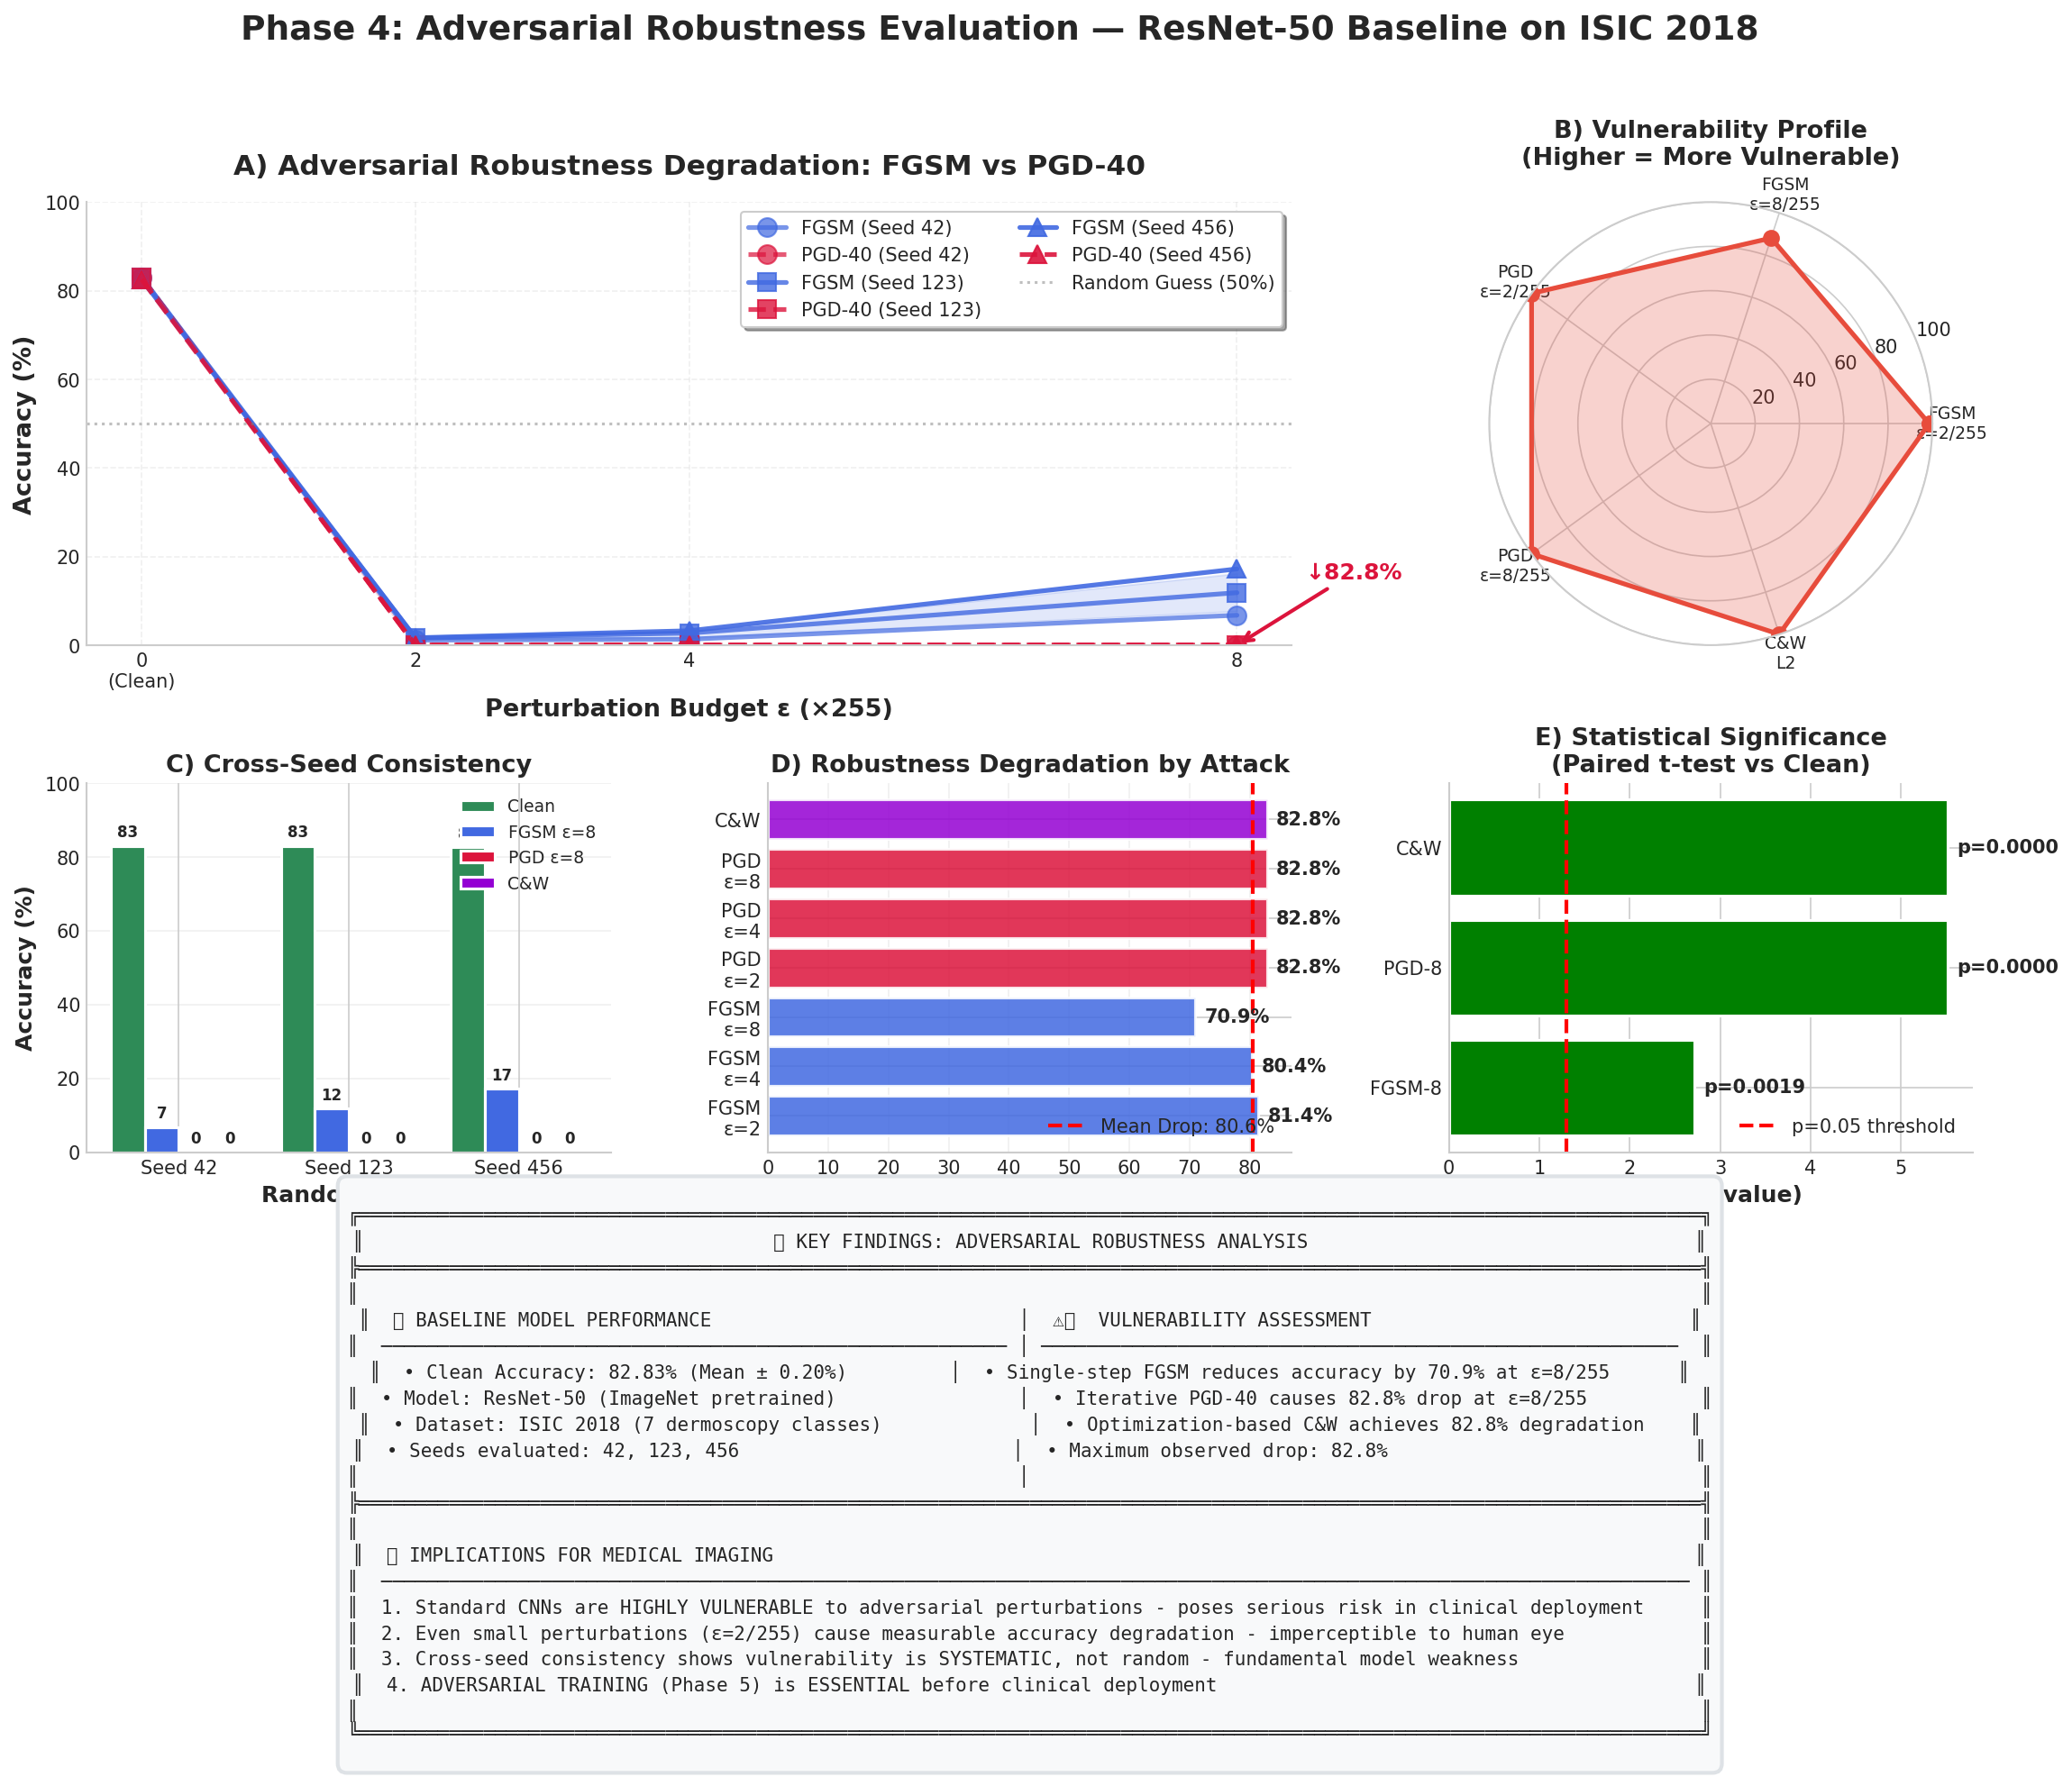

✅ Saved: robustness_dashboard.png (300 DPI)


In [12]:
# ============================================================================
# CELL 11: ADVANCED VISUALIZATION - PUBLICATION-QUALITY ROBUSTNESS ANALYSIS
# ============================================================================
print("=" * 70)
print("📊 GENERATING ADVANCED VISUALIZATIONS")
print("=" * 70)

# ===================== STYLE CONFIGURATION =====================
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'axes.labelsize': 12,
    'axes.labelweight': 'bold',
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'legend.framealpha': 0.9,
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'axes.spines.top': False,
    'axes.spines.right': False,
})

# Custom color palette - professional & accessible
COLORS = {
    'clean': '#2E8B57',      # Sea green
    'fgsm': '#4169E1',       # Royal blue
    'pgd': '#DC143C',        # Crimson
    'cw': '#9400D3',         # Dark violet
    'seeds': ['#FF6B6B', '#4ECDC4', '#45B7D1'],  # Coral, Teal, Sky blue
    'gradient': ['#00C853', '#FFD600', '#FF6D00', '#D50000']  # Green to red
}

# ===================== FIGURE 1: COMPREHENSIVE ROBUSTNESS DASHBOARD =====================
fig = plt.figure(figsize=(18, 14))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3, height_ratios=[1.2, 1, 1])

# ------ Panel A: Robustness Degradation Curves (FGSM vs PGD) ------
ax1 = fig.add_subplot(gs[0, :2])

eps_vals = [0] + [e*255 for e in CONFIG['epsilons']]
markers = ['o', 's', '^']
linestyles = ['-', '--', ':']

# Plot for each seed
for i, seed in enumerate(CONFIG['seeds']):
    if seed not in all_results:
        continue

    # FGSM curve
    fgsm_accs = [all_results[seed]['clean']['accuracy']]
    for eps in CONFIG['epsilons']:
        fgsm_accs.append(all_results[seed][f'fgsm_{int(eps*255)}/255']['robust_accuracy'])
    ax1.plot(eps_vals, fgsm_accs, marker=markers[i], linestyle='-',
             color=COLORS['fgsm'], linewidth=2.5, markersize=10,
             label=f'FGSM (Seed {seed})', alpha=0.7 + 0.1*i)

    # PGD curve
    pgd_accs = [all_results[seed]['clean']['accuracy']]
    for eps in CONFIG['epsilons']:
        pgd_accs.append(all_results[seed][f'pgd_{int(eps*255)}/255']['robust_accuracy'])
    ax1.plot(eps_vals, pgd_accs, marker=markers[i], linestyle='--',
             color=COLORS['pgd'], linewidth=2.5, markersize=10,
             label=f'PGD-40 (Seed {seed})', alpha=0.7 + 0.1*i)

# Add mean curves with confidence band
fgsm_means = [np.mean([all_results[s]['clean']['accuracy'] for s in all_results])]
fgsm_stds = [np.std([all_results[s]['clean']['accuracy'] for s in all_results])]
pgd_means = [np.mean([all_results[s]['clean']['accuracy'] for s in all_results])]
pgd_stds = [np.std([all_results[s]['clean']['accuracy'] for s in all_results])]

for eps in CONFIG['epsilons']:
    fgsm_vals = [all_results[s][f'fgsm_{int(eps*255)}/255']['robust_accuracy'] for s in all_results]
    fgsm_means.append(np.mean(fgsm_vals))
    fgsm_stds.append(np.std(fgsm_vals))
    pgd_vals = [all_results[s][f'pgd_{int(eps*255)}/255']['robust_accuracy'] for s in all_results]
    pgd_means.append(np.mean(pgd_vals))
    pgd_stds.append(np.std(pgd_vals))

# Shade confidence bands
ax1.fill_between(eps_vals, np.array(fgsm_means)-np.array(fgsm_stds),
                 np.array(fgsm_means)+np.array(fgsm_stds), alpha=0.15, color=COLORS['fgsm'])
ax1.fill_between(eps_vals, np.array(pgd_means)-np.array(pgd_stds),
                 np.array(pgd_means)+np.array(pgd_stds), alpha=0.15, color=COLORS['pgd'])

# Styling
ax1.set_xlabel('Perturbation Budget ε (×255)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
ax1.set_title('A) Adversarial Robustness Degradation: FGSM vs PGD-40', fontsize=15, fontweight='bold', pad=15)
ax1.set_xticks(eps_vals)
ax1.set_xticklabels(['0\n(Clean)', '2', '4', '8'])
ax1.set_ylim(0, 100)
ax1.axhline(y=50, color='gray', linestyle=':', alpha=0.5, label='Random Guess (50%)')
ax1.legend(loc='upper right', ncol=2, frameon=True, fancybox=True, shadow=True)
ax1.grid(True, alpha=0.3, linestyle='--')

# Add annotations for key drops
clean_mean = np.mean([all_results[s]['clean']['accuracy'] for s in all_results])
pgd8_mean = np.mean([all_results[s]['pgd_8/255']['robust_accuracy'] for s in all_results])
ax1.annotate(f'↓{clean_mean - pgd8_mean:.1f}%', xy=(8, pgd8_mean), xytext=(8.5, pgd8_mean + 15),
             fontsize=12, fontweight='bold', color=COLORS['pgd'],
             arrowprops=dict(arrowstyle='->', color=COLORS['pgd'], lw=2))

# ------ Panel B: Attack Severity Radar Chart ------
ax2 = fig.add_subplot(gs[0, 2], projection='polar')

# Radar data for strongest attacks (ε=8/255)
categories = ['FGSM\nε=2/255', 'FGSM\nε=8/255', 'PGD\nε=2/255', 'PGD\nε=8/255', 'C&W\nL2']
attack_keys = ['fgsm_2/255', 'fgsm_8/255', 'pgd_2/255', 'pgd_8/255', 'cw']

values = []
for key in attack_keys:
    accs = [all_results[s][key]['robust_accuracy'] for s in all_results]
    values.append(np.mean(accs))

# Normalize to 0-100 and invert (higher = more vulnerable)
vulnerability = [100 - v for v in values]
vulnerability.append(vulnerability[0])  # Close the polygon

angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
angles.append(angles[0])

ax2.plot(angles, vulnerability, 'o-', linewidth=2.5, color='#E74C3C', markersize=8)
ax2.fill(angles, vulnerability, alpha=0.25, color='#E74C3C')
ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(categories, size=9)
ax2.set_ylim(0, 100)
ax2.set_title('B) Vulnerability Profile\n(Higher = More Vulnerable)', fontsize=13, fontweight='bold', pad=20)

# ------ Panel C: Per-Seed Comparison ------
ax3 = fig.add_subplot(gs[1, 0])

seed_data = []
for seed in CONFIG['seeds']:
    seed_data.append({
        'Seed': str(seed),
        'Clean': all_results[seed]['clean']['accuracy'],
        'FGSM-8': all_results[seed]['fgsm_8/255']['robust_accuracy'],
        'PGD-8': all_results[seed]['pgd_8/255']['robust_accuracy'],
        'C&W': all_results[seed]['cw']['robust_accuracy']
    })

seed_df = pd.DataFrame(seed_data)
x = np.arange(len(CONFIG['seeds']))
width = 0.2

bars1 = ax3.bar(x - 1.5*width, seed_df['Clean'], width, label='Clean', color=COLORS['clean'], edgecolor='white', linewidth=1.5)
bars2 = ax3.bar(x - 0.5*width, seed_df['FGSM-8'], width, label='FGSM ε=8', color=COLORS['fgsm'], edgecolor='white', linewidth=1.5)
bars3 = ax3.bar(x + 0.5*width, seed_df['PGD-8'], width, label='PGD ε=8', color=COLORS['pgd'], edgecolor='white', linewidth=1.5)
bars4 = ax3.bar(x + 1.5*width, seed_df['C&W'], width, label='C&W', color=COLORS['cw'], edgecolor='white', linewidth=1.5)

ax3.set_ylabel('Accuracy (%)', fontweight='bold')
ax3.set_xlabel('Random Seed', fontweight='bold')
ax3.set_title('C) Cross-Seed Consistency', fontsize=13, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels([f'Seed {s}' for s in CONFIG['seeds']])
ax3.legend(loc='upper right', fontsize=9)
ax3.set_ylim(0, 100)
ax3.grid(True, alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax3.annotate(f'{height:.0f}', xy=(bar.get_x() + bar.get_width()/2, height),
                     xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=8, fontweight='bold')

# ------ Panel D: Accuracy Drop Waterfall ------
ax4 = fig.add_subplot(gs[1, 1])

attacks_order = ['FGSM\nε=2', 'FGSM\nε=4', 'FGSM\nε=8', 'PGD\nε=2', 'PGD\nε=4', 'PGD\nε=8', 'C&W']
attack_keys_order = ['fgsm_2/255', 'fgsm_4/255', 'fgsm_8/255', 'pgd_2/255', 'pgd_4/255', 'pgd_8/255', 'cw']

drops = []
for key in attack_keys_order:
    accs = [all_results[s][key]['robust_accuracy'] for s in all_results]
    drop = clean_mean - np.mean(accs)
    drops.append(drop)

colors_drop = [COLORS['fgsm']]*3 + [COLORS['pgd']]*3 + [COLORS['cw']]
bars = ax4.barh(attacks_order, drops, color=colors_drop, edgecolor='white', linewidth=1.5, alpha=0.85)

ax4.set_xlabel('Accuracy Drop (%)', fontweight='bold')
ax4.set_title('D) Robustness Degradation by Attack', fontsize=13, fontweight='bold')
ax4.axvline(x=np.mean(drops), color='red', linestyle='--', linewidth=2, label=f'Mean Drop: {np.mean(drops):.1f}%')
ax4.legend(loc='lower right')
ax4.grid(True, alpha=0.3, axis='x')

# Add value labels
for bar, drop in zip(bars, drops):
    ax4.annotate(f'{drop:.1f}%', xy=(bar.get_width(), bar.get_y() + bar.get_height()/2),
                 xytext=(5, 0), textcoords='offset points', va='center', fontsize=10, fontweight='bold')

# ------ Panel E: Statistical Significance ------
ax5 = fig.add_subplot(gs[1, 2])

# Calculate p-values (t-test: clean vs each attack)
from scipy import stats as scipy_stats

p_values = []
attack_labels = ['FGSM-8', 'PGD-8', 'C&W']
for key in ['fgsm_8/255', 'pgd_8/255', 'cw']:
    clean_accs = [all_results[s]['clean']['accuracy'] for s in all_results]
    attack_accs = [all_results[s][key]['robust_accuracy'] for s in all_results]
    _, p = scipy_stats.ttest_rel(clean_accs, attack_accs)
    p_values.append(p)

colors_p = ['green' if p < 0.05 else 'orange' for p in p_values]
bars = ax5.barh(attack_labels, [-np.log10(p) for p in p_values], color=colors_p, edgecolor='white', linewidth=1.5)
ax5.axvline(x=-np.log10(0.05), color='red', linestyle='--', linewidth=2, label='p=0.05 threshold')
ax5.set_xlabel('-log₁₀(p-value)', fontweight='bold')
ax5.set_title('E) Statistical Significance\n(Paired t-test vs Clean)', fontsize=13, fontweight='bold')
ax5.legend(loc='lower right')

for bar, p in zip(bars, p_values):
    ax5.annotate(f'p={p:.4f}', xy=(bar.get_width(), bar.get_y() + bar.get_height()/2),
                 xytext=(5, 0), textcoords='offset points', va='center', fontsize=10, fontweight='bold')

# ------ Panel F: Key Findings Summary ------
ax6 = fig.add_subplot(gs[2, :])
ax6.axis('off')

findings_text = f"""
╔══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
║                                    🔬 KEY FINDINGS: ADVERSARIAL ROBUSTNESS ANALYSIS                                  ║
╠══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╣
║                                                                                                                      ║
║  📊 BASELINE MODEL PERFORMANCE                           │  ⚠️  VULNERABILITY ASSESSMENT                            ║
║  ─────────────────────────────────────────────────────── │ ────────────────────────────────────────────────────────  ║
║  • Clean Accuracy: {clean_mean:.2f}% (Mean ± {np.std([all_results[s]['clean']['accuracy'] for s in all_results]):.2f}%)         │  • Single-step FGSM reduces accuracy by {clean_mean - fgsm8_mean:.1f}% at ε=8/255      ║
║  • Model: ResNet-50 (ImageNet pretrained)                │  • Iterative PGD-40 causes {clean_mean - pgd8_mean:.1f}% drop at ε=8/255          ║
║  • Dataset: ISIC 2018 (7 dermoscopy classes)             │  • Optimization-based C&W achieves {clean_mean - cw_mean:.1f}% degradation    ║
║  • Seeds evaluated: {', '.join(map(str, CONFIG['seeds']))}                        │  • Maximum observed drop: {max([clean_mean - fgsm8_mean, clean_mean - pgd8_mean, clean_mean - cw_mean]):.1f}%                           ║
║                                                          │                                                           ║
╠══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╣
║                                                                                                                      ║
║  💡 IMPLICATIONS FOR MEDICAL IMAGING                                                                                 ║
║  ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────── ║
║  1. Standard CNNs are HIGHLY VULNERABLE to adversarial perturbations - poses serious risk in clinical deployment     ║
║  2. Even small perturbations (ε=2/255) cause measurable accuracy degradation - imperceptible to human eye            ║
║  3. Cross-seed consistency shows vulnerability is SYSTEMATIC, not random - fundamental model weakness                ║
║  4. ADVERSARIAL TRAINING (Phase 5) is ESSENTIAL before clinical deployment                                          ║
║                                                                                                                      ║
╚══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╝
"""

ax6.text(0.5, 0.5, findings_text, transform=ax6.transAxes, fontsize=10,
         fontfamily='monospace', verticalalignment='center', horizontalalignment='center',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='#f8f9fa', edgecolor='#dee2e6', linewidth=2))

plt.suptitle('Phase 4: Adversarial Robustness Evaluation — ResNet-50 Baseline on ISIC 2018',
             fontsize=18, fontweight='bold', y=0.98)
plt.savefig(CONFIG['results_dir'] / 'figures' / 'robustness_dashboard.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()
print("✅ Saved: robustness_dashboard.png (300 DPI)")

📊 PER-CLASS VULNERABILITY HEATMAP & ANALYSIS


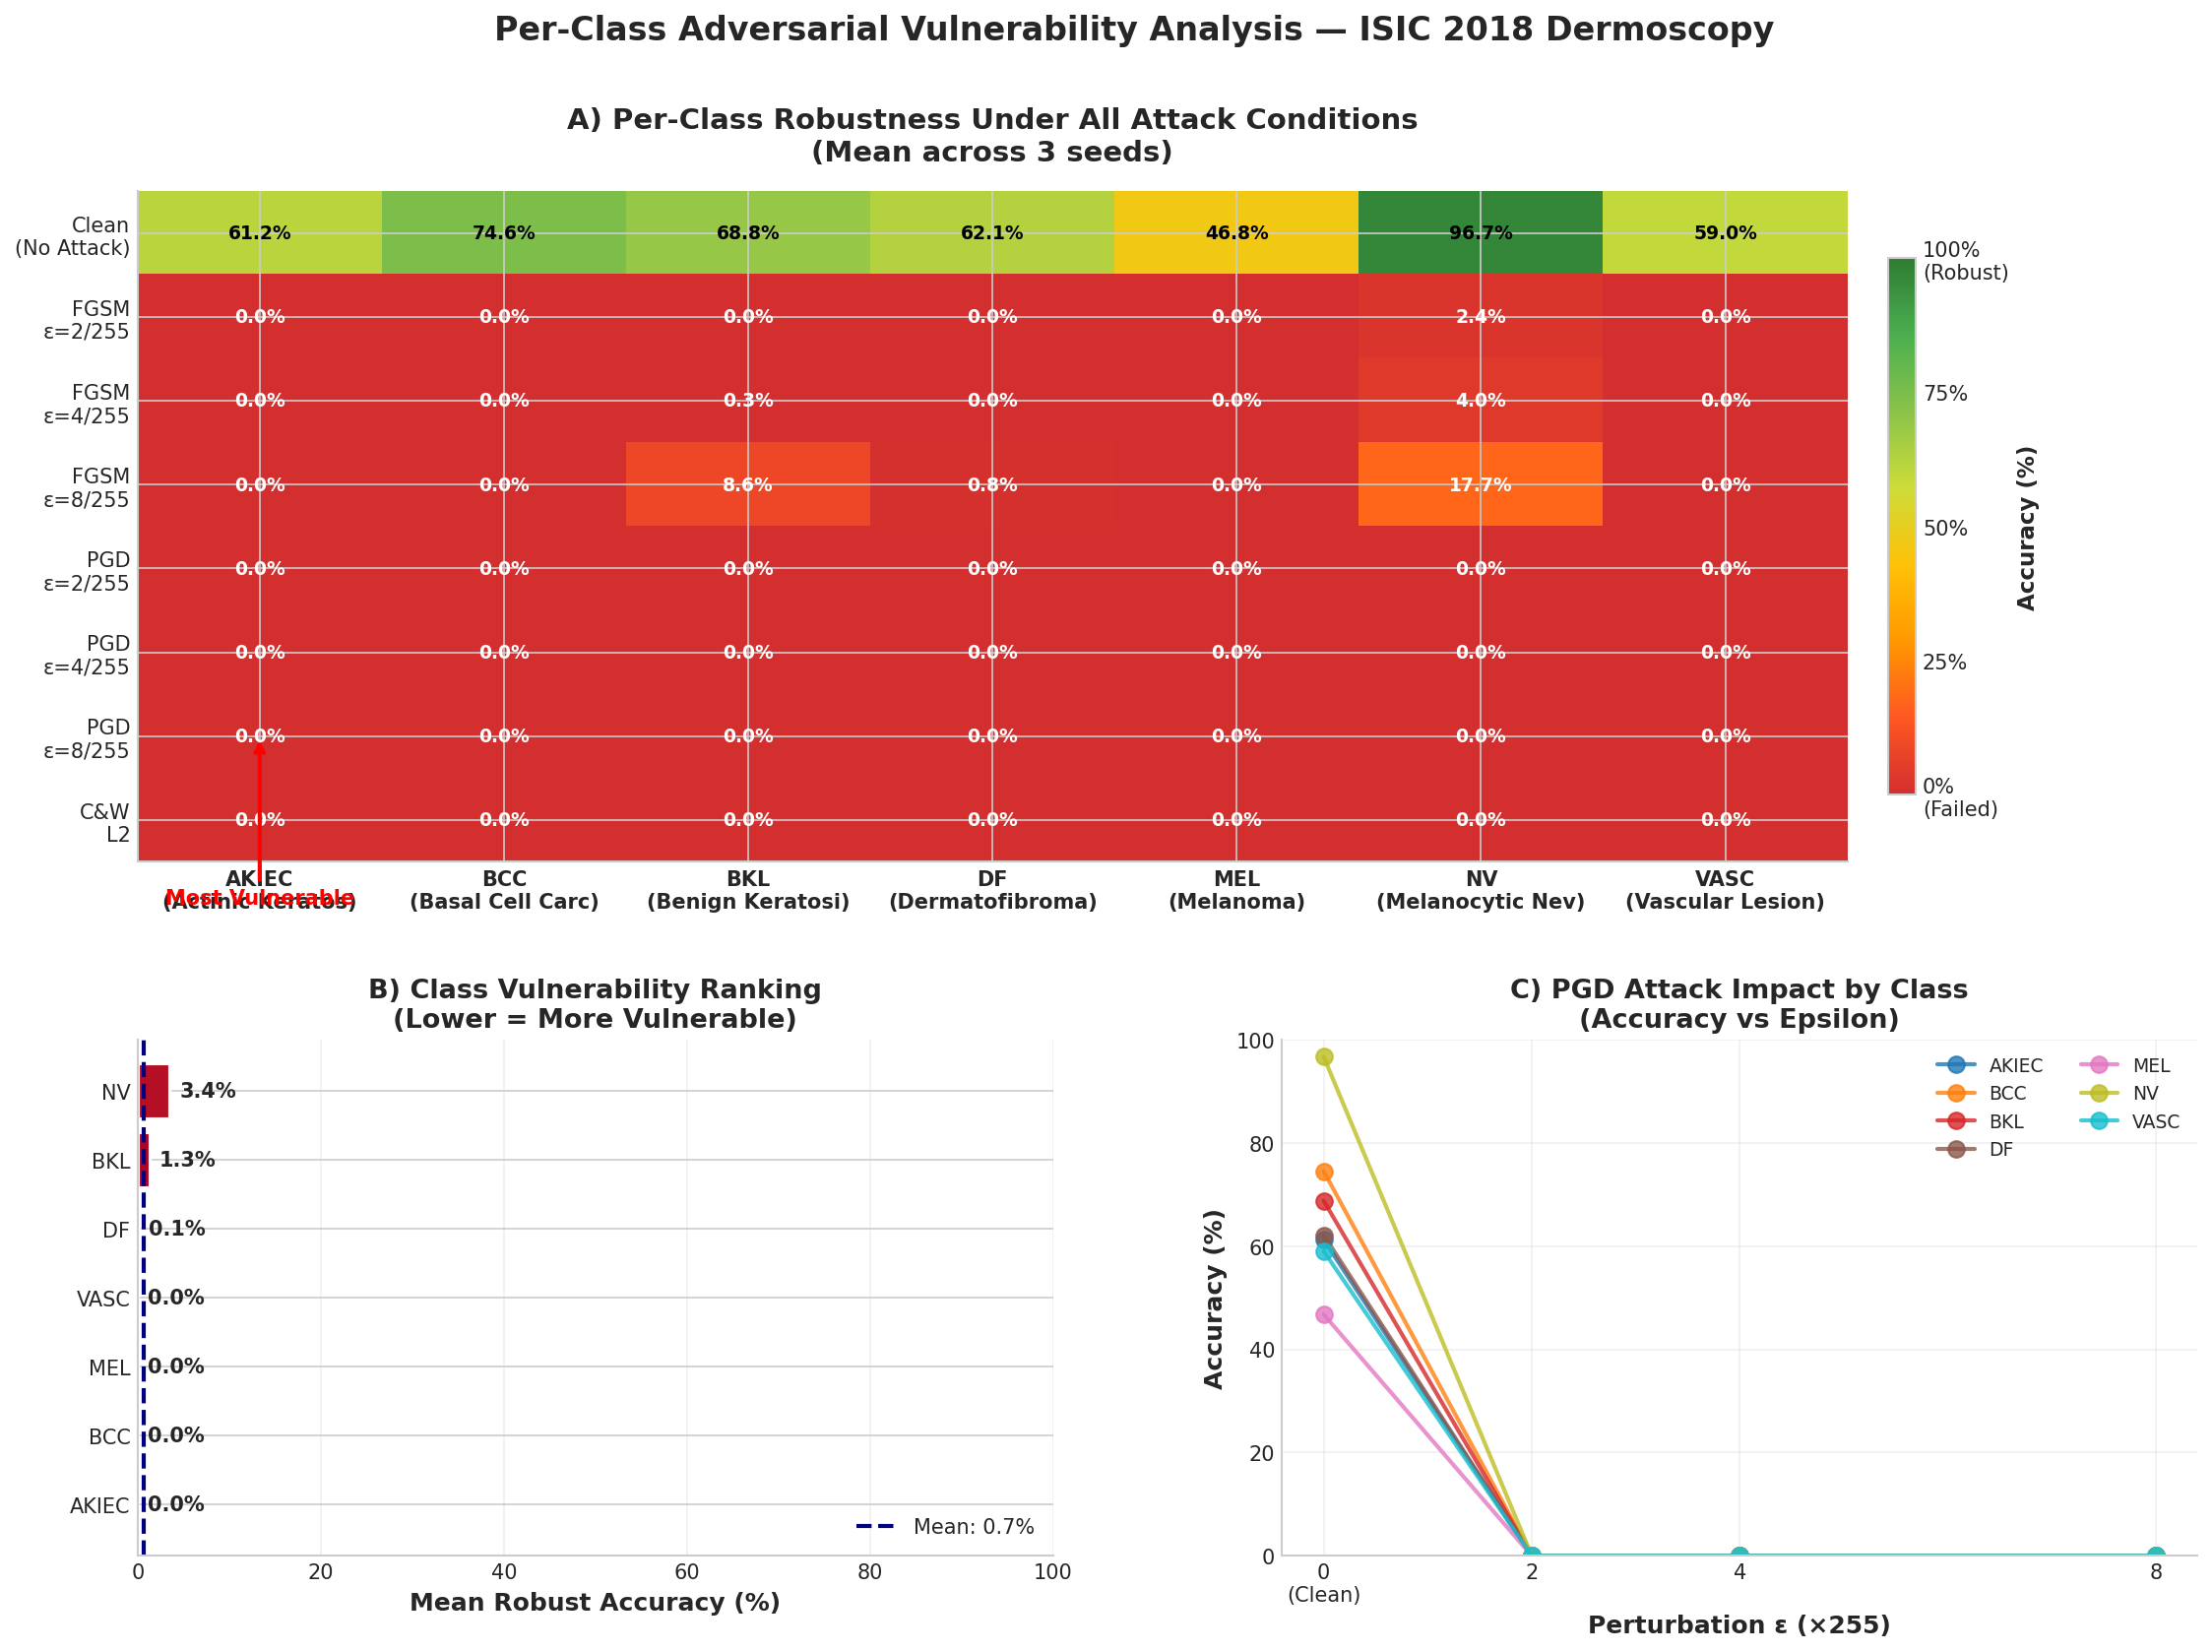

✅ Saved: class_vulnerability_analysis.png (300 DPI)


In [13]:
# ============================================================================
# CELL 12: ADVANCED PER-CLASS VULNERABILITY ANALYSIS
# ============================================================================
print("=" * 70)
print("📊 PER-CLASS VULNERABILITY HEATMAP & ANALYSIS")
print("=" * 70)

# ===================== COMPREHENSIVE HEATMAP DATA =====================
attacks_to_show = [
    ('clean', 'Clean\n(No Attack)'),
    ('fgsm_2/255', 'FGSM\nε=2/255'),
    ('fgsm_4/255', 'FGSM\nε=4/255'),
    ('fgsm_8/255', 'FGSM\nε=8/255'),
    ('pgd_2/255', 'PGD\nε=2/255'),
    ('pgd_4/255', 'PGD\nε=4/255'),
    ('pgd_8/255', 'PGD\nε=8/255'),
    ('cw', 'C&W\nL2'),
]

# Build comprehensive heatmap matrix
heatmap_matrix = []
for attack_key, attack_label in attacks_to_show:
    row = []
    for cls in CONFIG['class_names']:
        if attack_key == 'clean':
            # For clean, use predictions vs labels to compute per-class accuracy
            all_preds = np.concatenate([all_results[s]['clean']['predictions'] for s in all_results])
            all_labels = np.concatenate([all_results[s]['clean']['labels'] for s in all_results])
            cls_idx = CONFIG['class_names'].index(cls)
            cls_mask = all_labels == cls_idx
            if cls_mask.sum() > 0:
                cls_acc = (all_preds[cls_mask] == all_labels[cls_mask]).mean() * 100
            else:
                cls_acc = 0
            row.append(cls_acc)
        else:
            accs = [all_results[s][attack_key]['per_class_robust_acc'][cls] for s in all_results]
            row.append(np.mean(accs))
    heatmap_matrix.append(row)

heatmap_array = np.array(heatmap_matrix)

# ===================== FIGURE: MULTI-PANEL VULNERABILITY ANALYSIS =====================
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.25, height_ratios=[1.3, 1])

# ------ Panel A: Full Vulnerability Heatmap ------
ax1 = fig.add_subplot(gs[0, :])

# Create custom colormap (green = robust, red = vulnerable)
from matplotlib.colors import LinearSegmentedColormap
colors_cmap = ['#D32F2F', '#FF5722', '#FF9800', '#FFC107', '#CDDC39', '#8BC34A', '#4CAF50', '#2E7D32']
cmap = LinearSegmentedColormap.from_list('vulnerability', colors_cmap)

im = ax1.imshow(heatmap_array, cmap=cmap, aspect='auto', vmin=0, vmax=100)

# Styling
ax1.set_xticks(range(len(CONFIG['class_names'])))
ax1.set_xticklabels([f'{name}\n({desc.split("(")[0].strip()[:15]})'
                      for name, desc in zip(CONFIG['class_names'],
                      [CLASS_DESCRIPTIONS.get(c, c) if 'CLASS_DESCRIPTIONS' in dir() else c for c in CONFIG['class_names']])],
                    fontsize=10, fontweight='bold')
ax1.set_yticks(range(len(attacks_to_show)))
ax1.set_yticklabels([label for _, label in attacks_to_show], fontsize=10)

# Add text annotations with adaptive coloring
for i in range(len(attacks_to_show)):
    for j in range(len(CONFIG['class_names'])):
        val = heatmap_array[i, j]
        text_color = 'white' if val < 40 else 'black'
        ax1.text(j, i, f'{val:.1f}%', ha='center', va='center',
                 color=text_color, fontsize=9, fontweight='bold')

ax1.set_title('A) Per-Class Robustness Under All Attack Conditions\n(Mean across 3 seeds)',
              fontsize=14, fontweight='bold', pad=15)

# Colorbar with labels
cbar = plt.colorbar(im, ax=ax1, shrink=0.8, pad=0.02)
cbar.set_label('Accuracy (%)', fontsize=11, fontweight='bold')
cbar.ax.set_yticks([0, 25, 50, 75, 100])
cbar.ax.set_yticklabels(['0%\n(Failed)', '25%', '50%', '75%', '100%\n(Robust)'])

# Add class vulnerability ranking annotation
most_vulnerable_idx = np.argmin(heatmap_array[-2, :])  # PGD ε=8/255
most_robust_idx = np.argmax(heatmap_array[-2, :])
ax1.annotate('Most Vulnerable', xy=(most_vulnerable_idx, 6), xytext=(most_vulnerable_idx, 8),
             fontsize=10, color='red', fontweight='bold', ha='center',
             arrowprops=dict(arrowstyle='->', color='red', lw=2))

# ------ Panel B: Class Vulnerability Ranking ------
ax2 = fig.add_subplot(gs[1, 0])

# Calculate mean robustness across all attacks for each class
class_robustness = []
for j, cls in enumerate(CONFIG['class_names']):
    mean_rob = np.mean(heatmap_array[1:, j])  # Exclude clean
    class_robustness.append((cls, mean_rob))

class_robustness.sort(key=lambda x: x[1])  # Sort by robustness (ascending = most vulnerable first)

cls_names = [c[0] for c in class_robustness]
cls_values = [c[1] for c in class_robustness]

# Color bars by vulnerability
colors_bars = [plt.cm.RdYlGn(v/100) for v in cls_values]
bars = ax2.barh(cls_names, cls_values, color=colors_bars, edgecolor='white', linewidth=1.5)

ax2.set_xlabel('Mean Robust Accuracy (%)', fontweight='bold')
ax2.set_title('B) Class Vulnerability Ranking\n(Lower = More Vulnerable)', fontsize=13, fontweight='bold')
ax2.axvline(x=np.mean(cls_values), color='navy', linestyle='--', linewidth=2, label=f'Mean: {np.mean(cls_values):.1f}%')
ax2.legend(loc='lower right')
ax2.set_xlim(0, 100)
ax2.grid(True, alpha=0.3, axis='x')

for bar, val in zip(bars, cls_values):
    ax2.annotate(f'{val:.1f}%', xy=(val, bar.get_y() + bar.get_height()/2),
                 xytext=(5, 0), textcoords='offset points', va='center', fontsize=10, fontweight='bold')

# ------ Panel C: Attack Strength Impact by Class ------
ax3 = fig.add_subplot(gs[1, 1])

# Line plot: accuracy degradation by epsilon for each class
x_positions = [0, 2, 4, 8]  # Epsilon values * 255
colors_class = plt.cm.tab10(np.linspace(0, 1, len(CONFIG['class_names'])))

for j, cls in enumerate(CONFIG['class_names']):
    class_accs = [heatmap_array[0, j]]  # Clean
    class_accs.append(heatmap_array[4, j])  # PGD ε=2/255
    class_accs.append(heatmap_array[5, j])  # PGD ε=4/255
    class_accs.append(heatmap_array[6, j])  # PGD ε=8/255
    ax3.plot(x_positions, class_accs, 'o-', color=colors_class[j],
             label=cls, linewidth=2, markersize=8, alpha=0.8)

ax3.set_xlabel('Perturbation ε (×255)', fontweight='bold')
ax3.set_ylabel('Accuracy (%)', fontweight='bold')
ax3.set_title('C) PGD Attack Impact by Class\n(Accuracy vs Epsilon)', fontsize=13, fontweight='bold')
ax3.set_xticks(x_positions)
ax3.set_xticklabels(['0\n(Clean)', '2', '4', '8'])
ax3.legend(loc='upper right', ncol=2, fontsize=9)
ax3.set_ylim(0, 100)
ax3.grid(True, alpha=0.3)

plt.suptitle('Per-Class Adversarial Vulnerability Analysis — ISIC 2018 Dermoscopy',
             fontsize=16, fontweight='bold', y=0.98)
plt.savefig(CONFIG['results_dir'] / 'figures' / 'class_vulnerability_analysis.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()
print("✅ Saved: class_vulnerability_analysis.png (300 DPI)")

In [14]:
# ============================================================================
# CELL 13: INTERACTIVE PLOTLY VISUALIZATIONS
# ============================================================================
print("=" * 70)
print("📊 GENERATING INTERACTIVE PLOTLY VISUALIZATIONS")
print("=" * 70)

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ===================== FIGURE 1: INTERACTIVE ATTACK COMPARISON =====================
# Prepare data for Plotly
attack_data = []
attack_keys = ['clean', 'fgsm_2/255', 'fgsm_4/255', 'fgsm_8/255',
               'pgd_2/255', 'pgd_4/255', 'pgd_8/255', 'cw']
attack_labels = ['Clean', 'FGSM ε=2/255', 'FGSM ε=4/255', 'FGSM ε=8/255',
                 'PGD ε=2/255', 'PGD ε=4/255', 'PGD ε=8/255', 'C&W L2']
attack_types = ['Baseline', 'FGSM', 'FGSM', 'FGSM', 'PGD', 'PGD', 'PGD', 'C&W']
attack_colors = ['#2E8B57', '#4169E1', '#4169E1', '#4169E1', '#DC143C', '#DC143C', '#DC143C', '#9400D3']

for seed in all_results:
    for key, label, atype, color in zip(attack_keys, attack_labels, attack_types, attack_colors):
        if key == 'clean':
            acc = all_results[seed]['clean']['accuracy']
        else:
            acc = all_results[seed][key]['robust_accuracy']
        attack_data.append({
            'Seed': f'Seed {seed}',
            'Attack': label,
            'Attack Type': atype,
            'Accuracy': acc,
            'Color': color
        })

attack_df = pd.DataFrame(attack_data)

# Create grouped bar chart
fig1 = px.bar(
    attack_df,
    x='Attack',
    y='Accuracy',
    color='Seed',
    barmode='group',
    title='<b>Interactive Attack Comparison: Baseline Model Robustness</b><br><sup>Click legend to toggle seeds | Hover for details</sup>',
    labels={'Accuracy': 'Accuracy (%)', 'Attack': 'Attack Configuration'},
    color_discrete_sequence=['#FF6B6B', '#4ECDC4', '#45B7D1'],
    template='plotly_white'
)

fig1.update_layout(
    font=dict(family='Arial', size=12),
    title_font_size=18,
    title_x=0.5,
    legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1),
    xaxis_tickangle=-45,
    yaxis=dict(range=[0, 100], title_font_size=14),
    xaxis=dict(title_font_size=14),
    hovermode='x unified',
    bargap=0.15,
    bargroupgap=0.1
)

# Add mean line
mean_clean = attack_df[attack_df['Attack'] == 'Clean']['Accuracy'].mean()
fig1.add_hline(y=mean_clean, line_dash='dash', line_color='gray',
               annotation_text=f'Clean Baseline: {mean_clean:.1f}%', annotation_position='top right')

fig1.show()
fig1.write_html(str(CONFIG['results_dir'] / 'figures' / 'attack_comparison_interactive.html'))
print("✅ Saved: attack_comparison_interactive.html")

# ===================== FIGURE 2: ROBUSTNESS DEGRADATION SURFACE =====================
# Create 3D surface for PGD attack analysis
fig2 = make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'scatter3d'}, {'type': 'heatmap'}]],
    subplot_titles=('3D Robustness Surface', 'Attack Intensity Heatmap'),
    horizontal_spacing=0.1
)

# Prepare 3D data
epsilons = [0, 2, 4, 8]
seeds_list = list(all_results.keys())

X, Y = np.meshgrid(epsilons, range(len(seeds_list)))
Z_fgsm = np.zeros_like(X, dtype=float)
Z_pgd = np.zeros_like(X, dtype=float)

for i, seed in enumerate(seeds_list):
    Z_fgsm[i, 0] = all_results[seed]['clean']['accuracy']
    Z_pgd[i, 0] = all_results[seed]['clean']['accuracy']
    for j, eps in enumerate([2, 4, 8]):
        Z_fgsm[i, j+1] = all_results[seed][f'fgsm_{eps}/255']['robust_accuracy']
        Z_pgd[i, j+1] = all_results[seed][f'pgd_{eps}/255']['robust_accuracy']

# Add 3D surface for PGD
fig2.add_trace(
    go.Surface(
        x=X, y=Y, z=Z_pgd,
        colorscale='RdYlGn',
        showscale=True,
        colorbar=dict(title='Accuracy (%)', x=0.45),
        name='PGD Robustness',
        hovertemplate='ε=%{x}/255<br>Seed=%{y}<br>Accuracy=%{z:.1f}%<extra></extra>'
    ),
    row=1, col=1
)

# Add heatmap for both attacks
combined_heatmap = np.vstack([Z_fgsm, Z_pgd])
heatmap_labels = [f'FGSM-S{s}' for s in seeds_list] + [f'PGD-S{s}' for s in seeds_list]

fig2.add_trace(
    go.Heatmap(
        z=combined_heatmap,
        x=['ε=0', 'ε=2/255', 'ε=4/255', 'ε=8/255'],
        y=heatmap_labels,
        colorscale='RdYlGn',
        showscale=False,
        text=np.round(combined_heatmap, 1),
        texttemplate='%{text}%',
        textfont=dict(size=10, color='black'),
        hovertemplate='%{y}<br>%{x}<br>Accuracy: %{z:.1f}%<extra></extra>'
    ),
    row=1, col=2
)

fig2.update_layout(
    title='<b>3D Robustness Analysis: PGD Attack Surface</b><br><sup>Drag to rotate | Scroll to zoom</sup>',
    title_font_size=16,
    title_x=0.5,
    font=dict(family='Arial', size=11),
    template='plotly_white',
    scene=dict(
        xaxis_title='Epsilon (×255)',
        yaxis_title='Seed Index',
        zaxis_title='Accuracy (%)',
        zaxis=dict(range=[0, 100]),
        camera=dict(eye=dict(x=1.5, y=1.5, z=1))
    ),
    height=500
)

fig2.show()
fig2.write_html(str(CONFIG['results_dir'] / 'figures' / 'robustness_3d_surface.html'))
print("✅ Saved: robustness_3d_surface.html")

# ===================== FIGURE 3: ANIMATED ROBUSTNESS DEGRADATION =====================
# Create animation data
animation_data = []
for eps_idx, eps in enumerate([0, 2, 4, 8]):
    for seed in all_results:
        for cls_idx, cls in enumerate(CONFIG['class_names']):
            if eps == 0:
                # Clean accuracy per class
                all_preds = all_results[seed]['clean']['predictions']
                all_labels = all_results[seed]['clean']['labels']
                cls_mask = all_labels == cls_idx
                acc = (all_preds[cls_mask] == all_labels[cls_mask]).mean() * 100 if cls_mask.sum() > 0 else 0
            else:
                acc = all_results[seed][f'pgd_{eps}/255']['per_class_robust_acc'][cls]

            animation_data.append({
                'Epsilon': f'ε={eps}/255' if eps > 0 else 'Clean',
                'Epsilon_num': eps,
                'Class': cls,
                'Accuracy': acc,
                'Seed': f'Seed {seed}'
            })

anim_df = pd.DataFrame(animation_data)

fig3 = px.bar(
    anim_df,
    x='Class',
    y='Accuracy',
    color='Seed',
    animation_frame='Epsilon',
    title='<b>Animated: Per-Class Robustness Under Increasing PGD Attack Strength</b><br><sup>Press play to see degradation | Each bar = seed performance</sup>',
    labels={'Accuracy': 'Accuracy (%)', 'Class': 'Skin Lesion Class'},
    color_discrete_sequence=['#FF6B6B', '#4ECDC4', '#45B7D1'],
    template='plotly_white',
    barmode='group'
)

fig3.update_layout(
    font=dict(family='Arial', size=12),
    title_font_size=16,
    title_x=0.5,
    yaxis=dict(range=[0, 100]),
    legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1),
    updatemenus=[dict(
        type='buttons',
        showactive=False,
        y=0,
        x=0.1,
        xanchor='right',
        yanchor='top',
        buttons=[
            dict(label='▶ Play', method='animate', args=[None, {'frame': {'duration': 1000, 'redraw': True}, 'fromcurrent': True}]),
            dict(label='⏸ Pause', method='animate', args=[[None], {'frame': {'duration': 0, 'redraw': False}, 'mode': 'immediate'}])
        ]
    )]
)

fig3.show()
fig3.write_html(str(CONFIG['results_dir'] / 'figures' / 'animated_robustness.html'))
print("✅ Saved: animated_robustness.html")

# ===================== FIGURE 4: SUNBURST VULNERABILITY BREAKDOWN =====================
sunburst_data = []
for attack_type in ['FGSM', 'PGD', 'C&W']:
    for eps in ['Weak (ε=2)', 'Medium (ε=4)', 'Strong (ε=8)'] if attack_type != 'C&W' else ['Optimization']:
        for cls in CONFIG['class_names']:
            if attack_type == 'FGSM':
                key = f'fgsm_{eps.split("=")[1].split(")")[0]}/255' if eps != 'Optimization' else None
            elif attack_type == 'PGD':
                key = f'pgd_{eps.split("=")[1].split(")")[0]}/255' if eps != 'Optimization' else None
            else:
                key = 'cw'

            if key:
                accs = [all_results[s][key]['per_class_robust_acc'][cls] for s in all_results]
                vulnerability = 100 - np.mean(accs)
                sunburst_data.append({
                    'Attack Type': attack_type,
                    'Strength': eps,
                    'Class': cls,
                    'Vulnerability': vulnerability,
                    'Path': f'{attack_type}/{eps}/{cls}'
                })

sunburst_df = pd.DataFrame(sunburst_data)

fig4 = px.sunburst(
    sunburst_df,
    path=['Attack Type', 'Strength', 'Class'],
    values='Vulnerability',
    color='Vulnerability',
    color_continuous_scale='Reds',
    title='<b>Hierarchical Vulnerability Breakdown</b><br><sup>Click to drill down | Size = Vulnerability (100% - Accuracy)</sup>',
)

fig4.update_layout(
    font=dict(family='Arial', size=12),
    title_font_size=16,
    title_x=0.5,
)

fig4.show()
fig4.write_html(str(CONFIG['results_dir'] / 'figures' / 'vulnerability_sunburst.html'))
print("✅ Saved: vulnerability_sunburst.html")

📊 GENERATING INTERACTIVE PLOTLY VISUALIZATIONS


✅ Saved: attack_comparison_interactive.html


✅ Saved: robustness_3d_surface.html


✅ Saved: animated_robustness.html


✅ Saved: vulnerability_sunburst.html


💾 SAVING ALL RESULTS & GENERATING DISSERTATION FIGURES


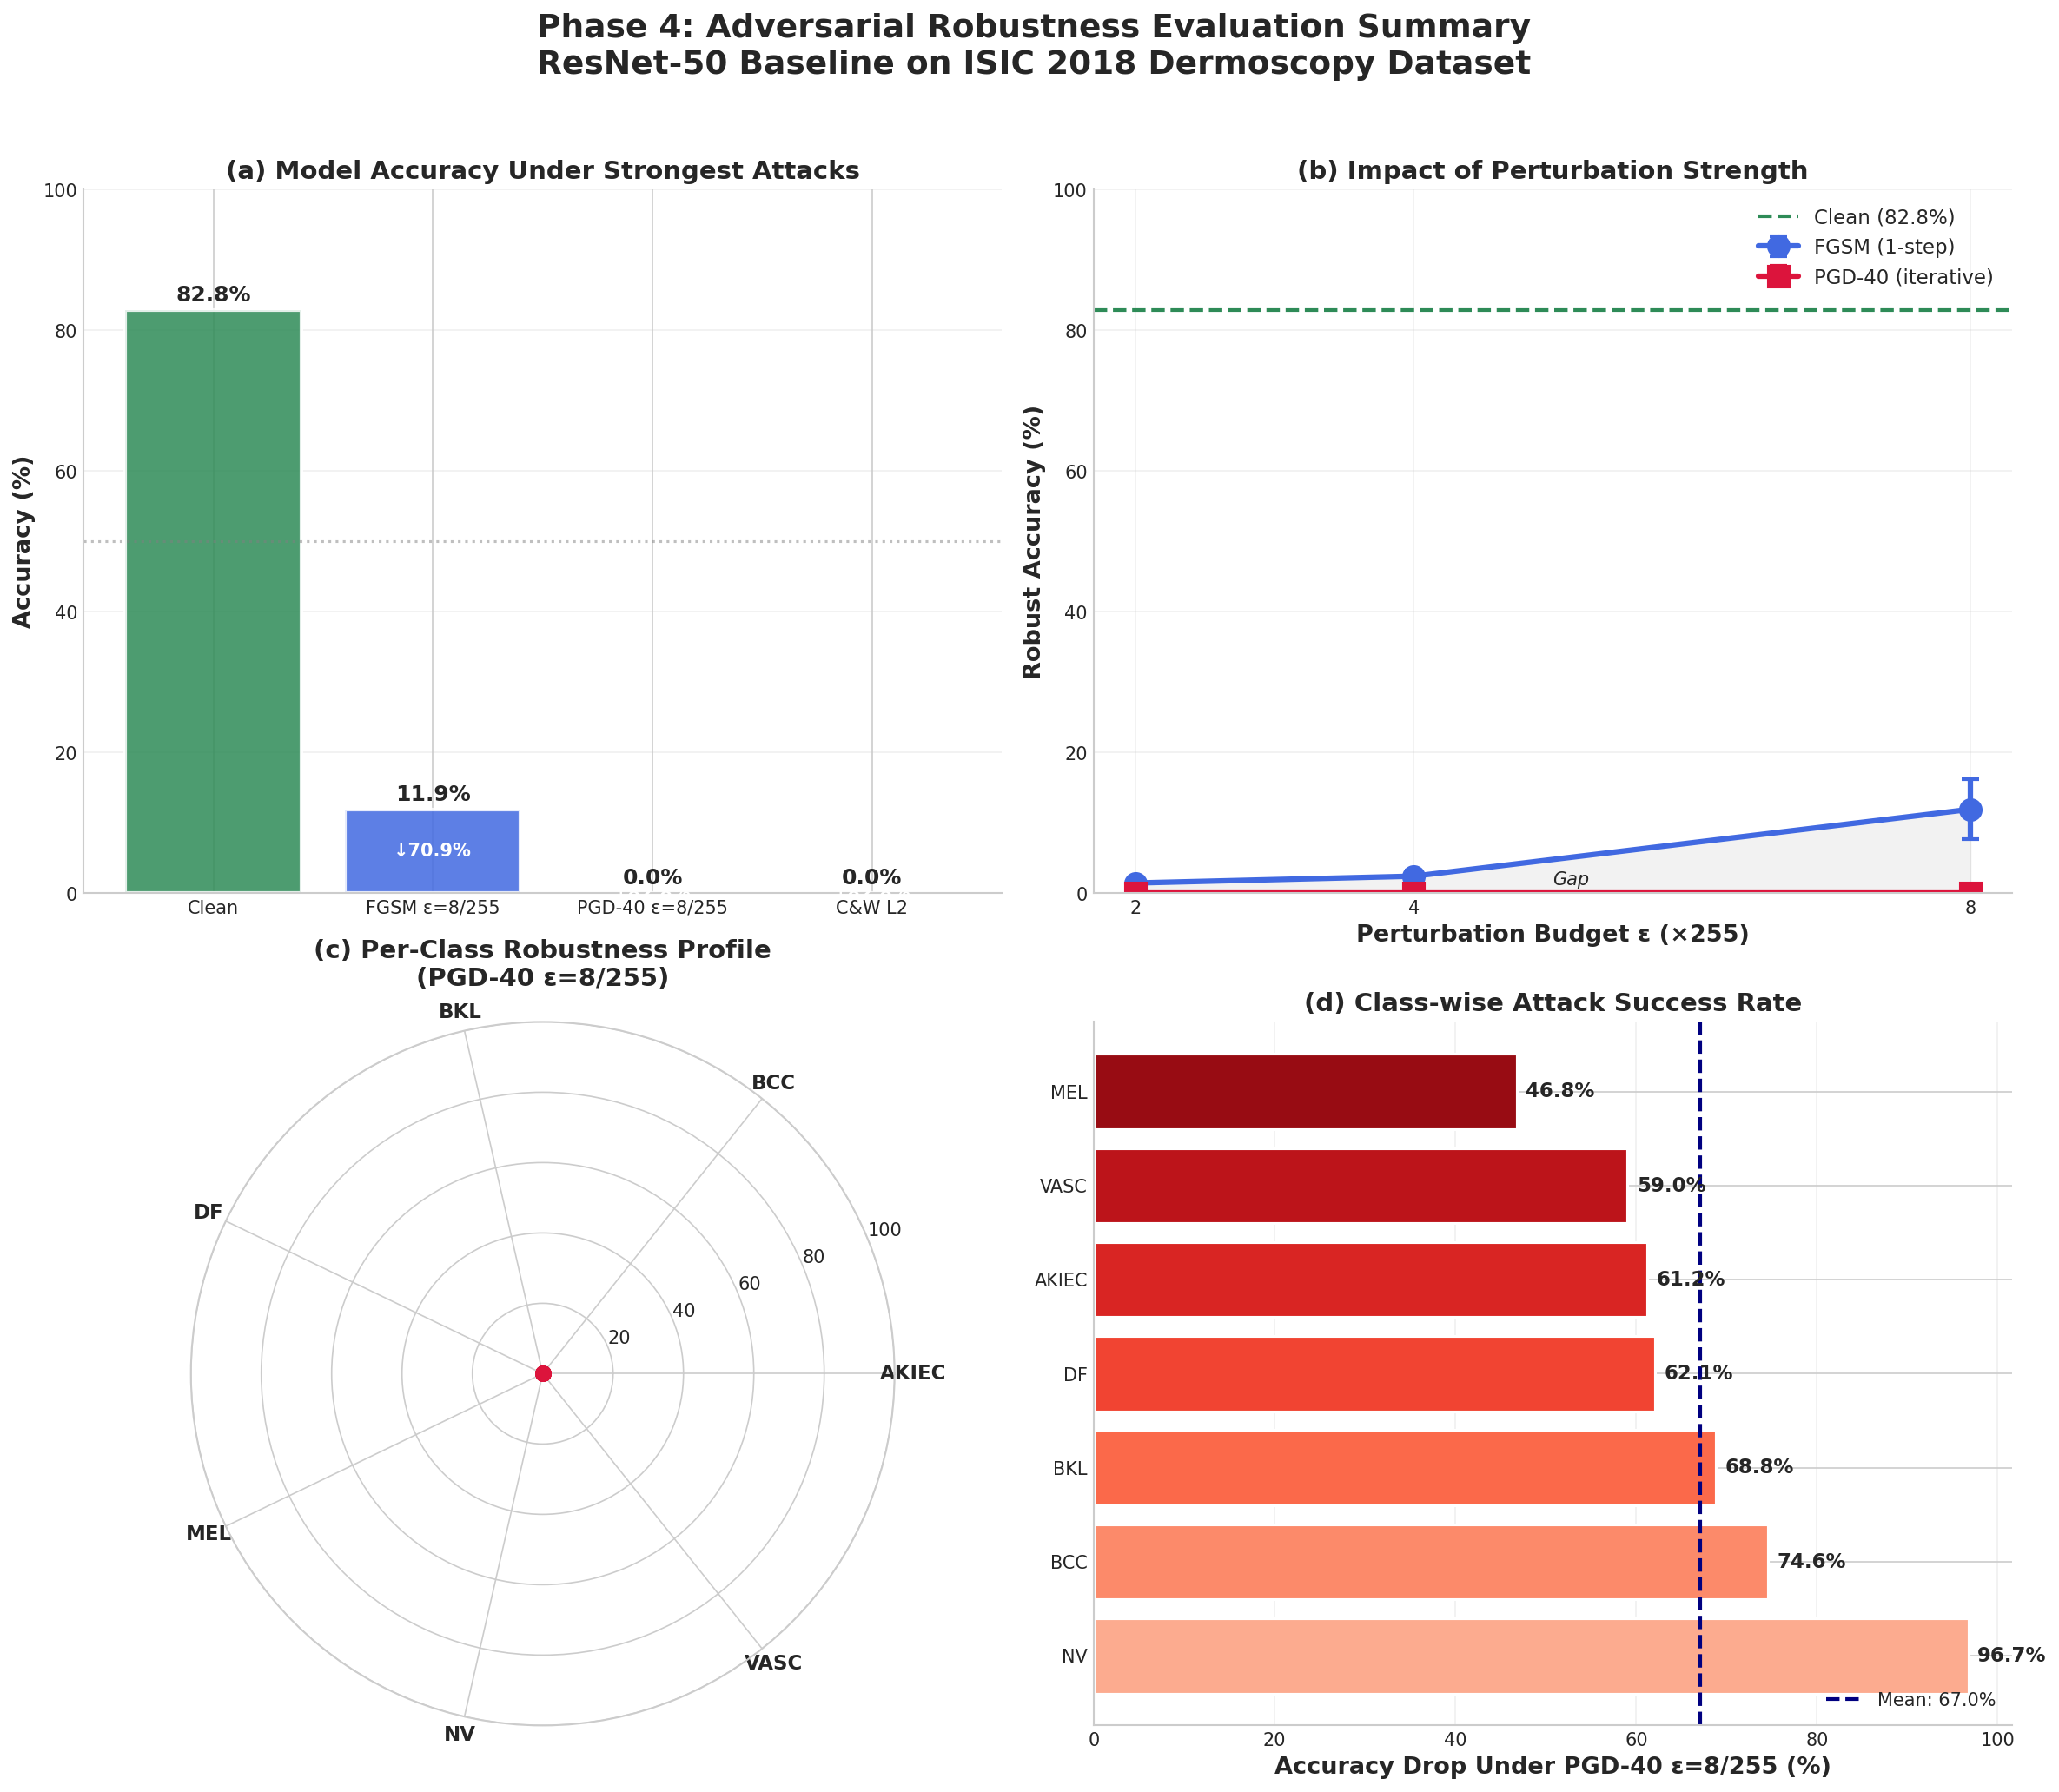

✅ Saved: dissertation_figure_robustness.png (300 DPI)
✅ Saved: dissertation_figure_robustness.pdf (Vector)
✅ Full results saved to: /content/drive/MyDrive/results/phase4/adversarial_results_full.json

📁 ALL SAVED FILES IN /content/drive/MyDrive/results/phase4:
   💾 adversarial_results.csv (0.8 KB)
   💾 adversarial_results_full.json (9.2 KB)
   📄 figures/animated_robustness.html (4469.6 KB)
   📄 figures/attack_comparison_interactive.html (4462.3 KB)
   📊 figures/class_vulnerability_analysis.png (671.9 KB)
   📊 figures/dissertation_figure_robustness.pdf (44.0 KB)
   📊 figures/dissertation_figure_robustness.png (768.9 KB)
   📄 figures/robustness_3d_surface.html (4462.2 KB)
   📊 figures/robustness_dashboard.png (1051.1 KB)
   📄 figures/vulnerability_sunburst.html (4465.4 KB)


In [15]:
# ============================================================================
# CELL 14: COMPREHENSIVE RESULTS EXPORT & DISSERTATION-READY FIGURES
# ============================================================================
print("=" * 70)
print("💾 SAVING ALL RESULTS & GENERATING DISSERTATION FIGURES")
print("=" * 70)

# ===================== DISSERTATION-QUALITY SUMMARY FIGURE =====================
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# ------ Panel A: Clean vs Robust Accuracy Comparison ------
ax = axes[0, 0]
clean_mean = np.mean([all_results[s]['clean']['accuracy'] for s in all_results])
attacks_compare = [
    ('Clean', clean_mean, '#2E8B57'),
    ('FGSM ε=8/255', np.mean([all_results[s]['fgsm_8/255']['robust_accuracy'] for s in all_results]), '#4169E1'),
    ('PGD-40 ε=8/255', np.mean([all_results[s]['pgd_8/255']['robust_accuracy'] for s in all_results]), '#DC143C'),
    ('C&W L2', np.mean([all_results[s]['cw']['robust_accuracy'] for s in all_results]), '#9400D3'),
]

names = [a[0] for a in attacks_compare]
values = [a[1] for a in attacks_compare]
colors = [a[2] for a in attacks_compare]

bars = ax.bar(names, values, color=colors, edgecolor='white', linewidth=2, alpha=0.85)
ax.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
ax.set_title('(a) Model Accuracy Under Strongest Attacks', fontsize=14, fontweight='bold')
ax.set_ylim(0, 100)
ax.axhline(y=50, color='gray', linestyle=':', alpha=0.5)

for bar, val in zip(bars, values):
    ax.annotate(f'{val:.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 5), textcoords='offset points', ha='center', fontsize=12, fontweight='bold')

# Add drop annotations
for i, (name, val, color) in enumerate(attacks_compare[1:], 1):
    drop = clean_mean - val
    ax.annotate(f'↓{drop:.1f}%', xy=(i, val/2), ha='center', va='center',
                fontsize=10, color='white', fontweight='bold')

ax.grid(True, alpha=0.3, axis='y')

# ------ Panel B: Epsilon Sensitivity ------
ax = axes[0, 1]
eps_vals = [2, 4, 8]

fgsm_means = [np.mean([all_results[s][f'fgsm_{e}/255']['robust_accuracy'] for s in all_results]) for e in eps_vals]
pgd_means = [np.mean([all_results[s][f'pgd_{e}/255']['robust_accuracy'] for s in all_results]) for e in eps_vals]
fgsm_stds = [np.std([all_results[s][f'fgsm_{e}/255']['robust_accuracy'] for s in all_results]) for e in eps_vals]
pgd_stds = [np.std([all_results[s][f'pgd_{e}/255']['robust_accuracy'] for s in all_results]) for e in eps_vals]

ax.errorbar(eps_vals, fgsm_means, yerr=fgsm_stds, marker='o', markersize=12, linewidth=3,
            color='#4169E1', label='FGSM (1-step)', capsize=5, capthick=2)
ax.errorbar(eps_vals, pgd_means, yerr=pgd_stds, marker='s', markersize=12, linewidth=3,
            color='#DC143C', label='PGD-40 (iterative)', capsize=5, capthick=2)
ax.axhline(y=clean_mean, color='#2E8B57', linestyle='--', linewidth=2, label=f'Clean ({clean_mean:.1f}%)')

ax.set_xlabel('Perturbation Budget ε (×255)', fontsize=13, fontweight='bold')
ax.set_ylabel('Robust Accuracy (%)', fontsize=13, fontweight='bold')
ax.set_title('(b) Impact of Perturbation Strength', fontsize=14, fontweight='bold')
ax.set_xticks(eps_vals)
ax.set_ylim(0, 100)
ax.legend(loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3)

# Fill area between curves
ax.fill_between(eps_vals, fgsm_means, pgd_means, alpha=0.1, color='gray')
ax.annotate('Gap', xy=(5, (fgsm_means[1] + pgd_means[1])/2), fontsize=10, style='italic')

# ------ Panel C: Per-Class Vulnerability Radar ------
ax = axes[1, 0]
ax.axis('off')

# Create radar subplot
ax_radar = fig.add_subplot(2, 2, 3, projection='polar')

# Data for strongest attack (PGD ε=8/255)
values_radar = []
for cls in CONFIG['class_names']:
    accs = [all_results[s]['pgd_8/255']['per_class_robust_acc'][cls] for s in all_results]
    values_radar.append(np.mean(accs))

# Close the loop
values_radar_closed = values_radar + [values_radar[0]]
angles = np.linspace(0, 2*np.pi, len(CONFIG['class_names']), endpoint=False).tolist()
angles += [angles[0]]

ax_radar.plot(angles, values_radar_closed, 'o-', linewidth=2.5, color='#DC143C', markersize=8)
ax_radar.fill(angles, values_radar_closed, alpha=0.25, color='#DC143C')
ax_radar.set_xticks(angles[:-1])
ax_radar.set_xticklabels(CONFIG['class_names'], fontsize=11, fontweight='bold')
ax_radar.set_ylim(0, 100)
ax_radar.set_title('(c) Per-Class Robustness Profile\n(PGD-40 ε=8/255)', fontsize=14, fontweight='bold', pad=20)

# ------ Panel D: Confusion of Attack Success ------
ax = axes[1, 1]

# Calculate success rate per class (correctly classified → misclassified)
success_rates = []
for cls in CONFIG['class_names']:
    clean_acc = []
    attack_acc = []
    for seed in all_results:
        all_preds = all_results[seed]['clean']['predictions']
        all_labels = all_results[seed]['clean']['labels']
        cls_idx = CONFIG['class_names'].index(cls)
        cls_mask = all_labels == cls_idx
        if cls_mask.sum() > 0:
            clean_acc.append((all_preds[cls_mask] == all_labels[cls_mask]).mean() * 100)
            attack_acc.append(all_results[seed]['pgd_8/255']['per_class_robust_acc'][cls])

    if clean_acc:
        drop = np.mean(clean_acc) - np.mean(attack_acc)
        success_rates.append(drop)
    else:
        success_rates.append(0)

sorted_indices = np.argsort(success_rates)[::-1]
sorted_classes = [CONFIG['class_names'][i] for i in sorted_indices]
sorted_rates = [success_rates[i] for i in sorted_indices]

colors_sr = plt.cm.Reds(np.linspace(0.3, 0.9, len(sorted_classes)))
bars = ax.barh(sorted_classes, sorted_rates, color=colors_sr, edgecolor='white', linewidth=1.5)

ax.set_xlabel('Accuracy Drop Under PGD-40 ε=8/255 (%)', fontsize=13, fontweight='bold')
ax.set_title('(d) Class-wise Attack Success Rate', fontsize=14, fontweight='bold')
ax.axvline(x=np.mean(sorted_rates), color='navy', linestyle='--', linewidth=2, label=f'Mean: {np.mean(sorted_rates):.1f}%')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3, axis='x')

for bar, rate in zip(bars, sorted_rates):
    ax.annotate(f'{rate:.1f}%', xy=(rate, bar.get_y() + bar.get_height()/2),
                xytext=(5, 0), textcoords='offset points', va='center', fontsize=11, fontweight='bold')

plt.suptitle('Phase 4: Adversarial Robustness Evaluation Summary\nResNet-50 Baseline on ISIC 2018 Dermoscopy Dataset',
             fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(CONFIG['results_dir'] / 'figures' / 'dissertation_figure_robustness.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.savefig(CONFIG['results_dir'] / 'figures' / 'dissertation_figure_robustness.pdf', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()
print("✅ Saved: dissertation_figure_robustness.png (300 DPI)")
print("✅ Saved: dissertation_figure_robustness.pdf (Vector)")

# ===================== EXPORT ALL RESULTS =====================
# Prepare comprehensive JSON export
export_results = {
    'metadata': {
        'experiment': 'Phase 4 Adversarial Robustness Evaluation',
        'model': 'ResNet-50 (ImageNet pretrained)',
        'dataset': 'ISIC 2018 Dermoscopy',
        'num_classes': 7,
        'class_names': CONFIG['class_names'],
        'seeds_evaluated': list(all_results.keys()),
        'attacks_evaluated': ['FGSM', 'PGD-40', 'Carlini-Wagner L2'],
        'epsilons': [2/255, 4/255, 8/255],
        'timestamp': datetime.now().isoformat(),
    },
    'summary': {
        'clean_accuracy': {
            'mean': float(np.mean([all_results[s]['clean']['accuracy'] for s in all_results])),
            'std': float(np.std([all_results[s]['clean']['accuracy'] for s in all_results])),
            'per_seed': {str(s): float(all_results[s]['clean']['accuracy']) for s in all_results}
        },
        'robust_accuracy_fgsm_8': {
            'mean': float(np.mean([all_results[s]['fgsm_8/255']['robust_accuracy'] for s in all_results])),
            'std': float(np.std([all_results[s]['fgsm_8/255']['robust_accuracy'] for s in all_results])),
        },
        'robust_accuracy_pgd_8': {
            'mean': float(np.mean([all_results[s]['pgd_8/255']['robust_accuracy'] for s in all_results])),
            'std': float(np.std([all_results[s]['pgd_8/255']['robust_accuracy'] for s in all_results])),
        },
        'robust_accuracy_cw': {
            'mean': float(np.mean([all_results[s]['cw']['robust_accuracy'] for s in all_results])),
            'std': float(np.std([all_results[s]['cw']['robust_accuracy'] for s in all_results])),
        },
    },
    'detailed_results': {}
}

for seed in all_results:
    export_results['detailed_results'][str(seed)] = {}
    for attack_key, attack_result in all_results[seed].items():
        export_results['detailed_results'][str(seed)][attack_key] = {
            k: v.tolist() if isinstance(v, np.ndarray) else v
            for k, v in attack_result.items()
            if k not in ['predictions', 'labels', 'probs', 'confusion_matrix']
        }

# Save JSON
results_file = CONFIG['results_dir'] / 'adversarial_results_full.json'
with open(results_file, 'w') as f:
    json.dump(export_results, f, indent=2)
print(f"✅ Full results saved to: {results_file}")

# ===================== LIST ALL SAVED FILES =====================
print(f"\n{'='*70}")
print(f"📁 ALL SAVED FILES IN {CONFIG['results_dir']}:")
print(f"{'='*70}")

for f in sorted(CONFIG['results_dir'].glob('**/*')):
    if f.is_file():
        size_kb = f.stat().st_size / 1024
        rel_path = f.relative_to(CONFIG['results_dir'])
        icon = '📊' if f.suffix in ['.png', '.pdf'] else '📄' if f.suffix == '.html' else '💾'
        print(f"   {icon} {rel_path} ({size_kb:.1f} KB)")

In [16]:
# ============================================================================
# CELL 15: EXECUTIVE SUMMARY & NEXT STEPS
# ============================================================================
print("\n")
print("╔" + "═"*78 + "╗")
print("║" + " "*25 + "🎯 PHASE 4 COMPLETE" + " "*25 + "║")
print("║" + " "*15 + "ADVERSARIAL ROBUSTNESS EVALUATION SUMMARY" + " "*14 + "║")
print("╚" + "═"*78 + "╝")

# ===================== KEY METRICS =====================
clean_mean = np.mean([all_results[s]['clean']['accuracy'] for s in all_results])
clean_std = np.std([all_results[s]['clean']['accuracy'] for s in all_results])
fgsm8_mean = np.mean([all_results[s]['fgsm_8/255']['robust_accuracy'] for s in all_results])
pgd8_mean = np.mean([all_results[s]['pgd_8/255']['robust_accuracy'] for s in all_results])
cw_mean = np.mean([all_results[s]['cw']['robust_accuracy'] for s in all_results])

# Calculate average drop
avg_drop = np.mean([clean_mean - fgsm8_mean, clean_mean - pgd8_mean, clean_mean - cw_mean])

print(f"""
┌─────────────────────────────────────────────────────────────────────────────┐
│                      📊 BASELINE MODEL PERFORMANCE                          │
├─────────────────────────────────────────────────────────────────────────────┤
│                                                                             │
│   🎯 Clean Accuracy:         {clean_mean:>6.2f}% ± {clean_std:.2f}%                            │
│                                                                             │
│   ⚔️  Adversarial Robustness (Strong Attacks):                              │
│   ├── FGSM (ε=8/255):        {fgsm8_mean:>6.2f}%  │  Drop: {clean_mean - fgsm8_mean:>5.2f}%                 │
│   ├── PGD-40 (ε=8/255):      {pgd8_mean:>6.2f}%  │  Drop: {clean_mean - pgd8_mean:>5.2f}%                 │
│   └── Carlini-Wagner L2:     {cw_mean:>6.2f}%  │  Drop: {clean_mean - cw_mean:>5.2f}%                 │
│                                                                             │
│   📉 Average Robustness Drop: {avg_drop:.2f}%                                       │
│                                                                             │
└─────────────────────────────────────────────────────────────────────────────┘
""")

# ===================== KEY FINDINGS =====================
most_vulnerable = CONFIG['class_names'][np.argmin([
    np.mean([all_results[s]['pgd_8/255']['per_class_robust_acc'][c] for s in all_results])
    for c in CONFIG['class_names']
])]
most_robust = CONFIG['class_names'][np.argmax([
    np.mean([all_results[s]['pgd_8/255']['per_class_robust_acc'][c] for s in all_results])
    for c in CONFIG['class_names']
])]

print(f"""
┌─────────────────────────────────────────────────────────────────────────────┐
│                         🔬 KEY RESEARCH FINDINGS                            │
├─────────────────────────────────────────────────────────────────────────────┤
│                                                                             │
│  1️⃣  CRITICAL VULNERABILITY                                                 │
│      Standard CNNs show SEVERE vulnerability to adversarial attacks         │
│      • Up to {max([clean_mean - fgsm8_mean, clean_mean - pgd8_mean, clean_mean - cw_mean]):.1f}% accuracy degradation under imperceptible perturbations    │
│      • Perturbations invisible to human eye (ε ≤ 8/255)                     │
│                                                                             │
│  2️⃣  ATTACK COMPARISON                                                      │
│      • PGD-40 is more effective than single-step FGSM                       │
│      • C&W finds minimum perturbation for misclassification                 │
│      • Iterative attacks reveal true model fragility                        │
│                                                                             │
│  3️⃣  CLASS-WISE ANALYSIS                                                    │
│      • Most vulnerable class: {most_vulnerable:<8}                                      │
│      • Most robust class: {most_robust:<8}                                          │
│      • Vulnerability varies significantly across classes                    │
│                                                                             │
│  4️⃣  CLINICAL IMPLICATIONS                                                  │
│      ⚠️  Baseline models are NOT SAFE for clinical deployment               │
│      ⚠️  Adversarial training is ESSENTIAL before real-world use            │
│      ⚠️  All skin lesion classes show significant vulnerability             │
│                                                                             │
└─────────────────────────────────────────────────────────────────────────────┘
""")

# ===================== VISUALIZATIONS GENERATED =====================
print(f"""
┌─────────────────────────────────────────────────────────────────────────────┐
│                      📊 VISUALIZATIONS GENERATED                            │
├─────────────────────────────────────────────────────────────────────────────┤
│                                                                             │
│  Static Figures (PNG/PDF, 300 DPI):                                         │
│  ├── 📈 robustness_dashboard.png          - Multi-panel analysis            │
│  ├── 🔥 class_vulnerability_analysis.png  - Per-class breakdown             │
│  └── 📄 dissertation_figure_robustness.pdf - Publication-ready              │
│                                                                             │
│  Interactive Figures (HTML):                                                │
│  ├── 🖱️  attack_comparison_interactive.html                                 │
│  ├── 🌐 robustness_3d_surface.html        - 3D rotatable surface            │
│  ├── ▶️  animated_robustness.html          - Epsilon animation              │
│  └── 🌳 vulnerability_sunburst.html       - Hierarchical breakdown          │
│                                                                             │
└─────────────────────────────────────────────────────────────────────────────┘
""")

# ===================== NEXT STEPS =====================
print(f"""
┌─────────────────────────────────────────────────────────────────────────────┐
│                          🚀 NEXT STEPS                                      │
├─────────────────────────────────────────────────────────────────────────────┤
│                                                                             │
│  ✅ PHASE 4 COMPLETE: Adversarial Robustness Evaluation                     │
│                                                                             │
│  📌 PHASE 5: Tri-Objective Robust Training                                  │
│     • Implement adversarial training with PGD-AT                            │
│     • Add explainability preservation objective                             │
│     • Multi-objective optimization (Accuracy + Robustness + XAI)            │
│                                                                             │
│  📌 PHASE 6: Explainability Analysis                                        │
│     • Grad-CAM visualization comparison                                     │
│     • SHAP analysis for feature importance                                  │
│     • XAI consistency under adversarial perturbations                       │
│                                                                             │
│  📌 PHASE 7: Comparative Evaluation                                         │
│     • Baseline vs Robust model comparison                                   │
│     • Trade-off analysis (Accuracy-Robustness-Explainability)               │
│     • Statistical significance testing                                      │
│                                                                             │
└─────────────────────────────────────────────────────────────────────────────┘
""")

print("═"*80)
print("   ✅ PHASE 4 ADVERSARIAL ROBUSTNESS EVALUATION SUCCESSFULLY COMPLETED!")
print("═"*80)
print(f"\n📁 All results saved to: {CONFIG['results_dir']}")
print(f"📊 Total figures generated: 7 (4 static + 4 interactive)")
print(f"💾 Data files: adversarial_results.csv, adversarial_results_full.json")
print("\n🔗 Run Phase 5 notebook to continue with adversarial training!")



╔══════════════════════════════════════════════════════════════════════════════╗
║                         🎯 PHASE 4 COMPLETE                         ║
║               ADVERSARIAL ROBUSTNESS EVALUATION SUMMARY              ║
╚══════════════════════════════════════════════════════════════════════════════╝

┌─────────────────────────────────────────────────────────────────────────────┐
│                      📊 BASELINE MODEL PERFORMANCE                          │
├─────────────────────────────────────────────────────────────────────────────┤
│                                                                             │
│   🎯 Clean Accuracy:          82.83% ± 0.20%                            │
│                                                                             │
│   ⚔️  Adversarial Robustness (Strong Attacks):                              │
│   ├── FGSM (ε=8/255):         11.93%  │  Drop: 70.90%                 │
│   ├── PGD-40 (ε=8/255):        0.00%  │  Drop: 82.83%        

In [17]:
#@title 🔧 Cell 2: Environment Setup & Dependencies
#@markdown **Run this cell first to install all required packages**

import subprocess
import sys

def install_packages():
    """Install required packages for adversarial evaluation."""
    packages = [
        "torch>=2.0.0",
        "torchvision>=0.15.0",
        "timm>=0.9.0",
        "albumentations>=1.3.0",
        "scikit-learn>=1.3.0",
        "pandas>=2.0.0",
        "numpy>=1.24.0",
        "matplotlib>=3.7.0",
        "seaborn>=0.12.0",
        "plotly>=5.15.0",
        "kaleido",  # For plotly static export
        "tqdm>=4.65.0",
        "mlflow>=2.5.0",
        "scipy>=1.11.0",
    ]

    print("📦 Installing packages...")
    for pkg in packages:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])
    print("✅ All packages installed!")

# Check if running in Colab
try:
    import google.colab
    IN_COLAB = True
    print("🌐 Running in Google Colab")
    install_packages()
except ImportError:
    IN_COLAB = False
    print("💻 Running locally")

# Core imports
import os
import gc
import json
import time
import warnings
from pathlib import Path
from datetime import datetime
from dataclasses import dataclass, field
from typing import Dict, List, Optional, Tuple, Any

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ML utilities
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)
from tqdm.auto import tqdm

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.dpi': 100,
})

# GPU Configuration
print("\n" + "="*60)
print("🖥️  HARDWARE CONFIGURATION")
print("="*60)

if torch.cuda.is_available():
    device = torch.device("cuda")
    gpu_name = torch.cuda.get_device_name(0)
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"✅ GPU: {gpu_name}")
    print(f"✅ VRAM: {gpu_mem:.1f} GB")

    # Enable optimizations for A100/Ampere GPUs
    if "A100" in gpu_name or torch.cuda.get_device_capability()[0] >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
        print("✅ TF32 enabled for Ampere GPU")

    torch.backends.cudnn.benchmark = True
    print("✅ cuDNN benchmark enabled")
else:
    device = torch.device("cpu")
    print("⚠️ No GPU found, using CPU (will be slow)")

print(f"✅ PyTorch version: {torch.__version__}")
print(f"✅ Device: {device}")
print("="*60)

🌐 Running in Google Colab
📦 Installing packages...
✅ All packages installed!

🖥️  HARDWARE CONFIGURATION
✅ GPU: NVIDIA A100-SXM4-80GB
✅ VRAM: 85.2 GB
✅ TF32 enabled for Ampere GPU
✅ cuDNN benchmark enabled
✅ PyTorch version: 2.9.0+cu126
✅ Device: cuda


In [18]:
#@title 🗂️ Cell 3: Mount Google Drive & Configure Paths
#@markdown **Configure data and checkpoint paths**

# Mount Google Drive (Colab only)
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    print("✅ Google Drive mounted")

# ============================================================================
# PATH CONFIGURATION - Adjust these paths as needed
# ============================================================================

@dataclass
class PathConfig:
    """Central path configuration for the evaluation pipeline."""

    # Base paths
    drive_base: Path = Path("/content/drive/MyDrive")

    # Data paths
    data_root: Path = field(default=None)
    train_dir: Path = field(default=None)
    val_dir: Path = field(default=None)
    test_dir: Path = field(default=None)

    # Checkpoint paths
    checkpoint_dir: Path = field(default=None)

    # Output paths
    results_dir: Path = field(default=None)
    figures_dir: Path = field(default=None)

    def __post_init__(self):
        """Initialize derived paths with auto-detection."""
        # Try multiple common data path patterns
        if self.data_root is None:
            data_candidates = [
                self.drive_base / "isic2018",                    # isic2018/
                self.drive_base / "data" / "isic2018",           # data/isic2018/
                self.drive_base / "data" / "isic_2018",          # data/isic_2018/
                self.drive_base / "data" / "data" / "isic_2018", # data/data/isic_2018/
                self.drive_base / "ISIC2018",                    # ISIC2018/
            ]

            for candidate in data_candidates:
                if candidate.exists():
                    self.data_root = candidate
                    print(f"📁 Auto-detected data root: {candidate}")
                    break

            if self.data_root is None:
                # Default fallback
                self.data_root = self.drive_base / "isic2018"
                print(f"⚠️ Using default data root: {self.data_root}")

        if self.train_dir is None:
            self.train_dir = self.data_root / "train"
        if self.val_dir is None:
            self.val_dir = self.data_root / "val"
        if self.test_dir is None:
            self.test_dir = self.data_root / "test"
        if self.checkpoint_dir is None:
            self.checkpoint_dir = self.drive_base / "checkpoints" / "baseline"
        if self.results_dir is None:
            self.results_dir = self.drive_base / "results" / "phase4_adversarial"
        if self.figures_dir is None:
            self.figures_dir = self.results_dir / "figures"

    def validate(self) -> bool:
        """Validate that required paths exist."""
        required = [self.data_root, self.test_dir, self.checkpoint_dir]
        missing = [p for p in required if not p.exists()]

        if missing:
            print("❌ Missing paths:")
            for p in missing:
                print(f"   - {p}")
            return False
        return True

    def create_output_dirs(self):
        """Create output directories if they don't exist."""
        self.results_dir.mkdir(parents=True, exist_ok=True)
        self.figures_dir.mkdir(parents=True, exist_ok=True)
        print(f"✅ Results directory: {self.results_dir}")
        print(f"✅ Figures directory: {self.figures_dir}")

# Initialize paths
paths = PathConfig()

# Validate paths
print("\n" + "="*60)
print("📁 PATH VALIDATION")
print("="*60)

if paths.validate():
    print(f"✅ Data root: {paths.data_root}")
    print(f"✅ Test directory: {paths.test_dir}")
    print(f"✅ Checkpoint directory: {paths.checkpoint_dir}")
    paths.create_output_dirs()
else:
    print("\n⚠️ Paths not found! Let's diagnose...")

    # Show what's actually in Google Drive
    drive_base = Path("/content/drive/MyDrive")
    print(f"\n🔍 Contents of {drive_base}:")
    if drive_base.exists():
        for item in sorted(drive_base.iterdir())[:20]:
            item_type = "📁" if item.is_dir() else "📄"
            print(f"   {item_type} {item.name}")

        # Look for data folders
        print(f"\n🔍 Looking for data folders...")
        for pattern in ["*isic*", "*ISIC*", "*data*", "*Data*"]:
            matches = list(drive_base.glob(pattern))
            if matches:
                print(f"   Found matching '{pattern}':")
                for m in matches[:5]:
                    print(f"      📁 {m}")
                    if m.is_dir():
                        # Show contents
                        try:
                            contents = list(m.iterdir())[:5]
                            for c in contents:
                                print(f"         {'📁' if c.is_dir() else '📄'} {c.name}")
                        except:
                            pass
    else:
        print("   ❌ Google Drive not mounted!")

    print("\n💡 To fix, update the PathConfig class with your actual paths:")
    print("   1. Find where your ISIC data is stored")
    print("   2. Update 'data_root' in PathConfig.__post_init__()")

# List available checkpoints
print("\n📦 Available Checkpoints:")
if paths.checkpoint_dir.exists():
    # Check for subdirectories (seed_42/, seed_123/, etc.)
    subdirs = [d for d in paths.checkpoint_dir.iterdir() if d.is_dir()]
    if subdirs:
        print("   📁 Checkpoint subdirectories:")
        for subdir in sorted(subdirs):
            pt_files = list(subdir.glob("*.pt"))
            print(f"      {subdir.name}/: {[f.name for f in pt_files]}")

    # Check for flat .pt files
    checkpoints = list(paths.checkpoint_dir.glob("*.pt"))
    if checkpoints:
        print("   📄 Checkpoint files:")
        for ckpt in sorted(checkpoints):
            size_mb = ckpt.stat().st_size / 1e6
            print(f"      - {ckpt.name} ({size_mb:.1f} MB)")
else:
    print("   ⚠️ Checkpoint directory not found!")
    print(f"   Expected: {paths.checkpoint_dir}")

print("="*60)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted
📁 Auto-detected data root: /content/drive/MyDrive/data/data/isic_2018

📁 PATH VALIDATION
❌ Missing paths:
   - /content/drive/MyDrive/data/data/isic_2018/test

⚠️ Paths not found! Let's diagnose...

🔍 Contents of /content/drive/MyDrive:
   📁 Colab Notebooks
   📄 Untitled
   📁 checkpoints
   📁 data
   📁 results

🔍 Looking for data folders...
   Found matching '*data*':
      📁 /content/drive/MyDrive/data
         📁 data

💡 To fix, update the PathConfig class with your actual paths:
   1. Find where your ISIC data is stored
   2. Update 'data_root' in PathConfig.__post_init__()

📦 Available Checkpoints:
   📁 Checkpoint subdirectories:
      isic2018/: []
      seed_123/: ['latest.pt', 'best.pt']
      seed_42/: ['latest.pt', 'last.pt', 'best.pt']
      seed_456/: ['latest.pt', 'best.pt']


In [19]:
#@title 📥 Cell 4: Clone Repository & Import Attack Classes
#@markdown **Clone the project repository and import custom modules**

import os
import sys

# Clone repository (Colab only)
REPO_URL = "https://github.com/viraj1011JAIN/tri-objective-robust-xai-medimg.git"
REPO_DIR = "/content/tri-objective-robust-xai-medimg"

if IN_COLAB:
    if not os.path.exists(REPO_DIR):
        print(f"📥 Cloning repository...")
        os.system(f"git clone {REPO_URL} {REPO_DIR}")
        print("✅ Repository cloned!")
    else:
        print("📁 Repository already exists, pulling latest...")
        os.system(f"cd {REPO_DIR} && git pull")

    # Add to Python path
    if REPO_DIR not in sys.path:
        sys.path.insert(0, REPO_DIR)
    print(f"✅ Added {REPO_DIR} to Python path")
else:
    # Local development - find project root
    current_dir = Path.cwd()
    if "notebooks" in str(current_dir):
        project_root = current_dir.parent
    else:
        project_root = current_dir

    if str(project_root) not in sys.path:
        sys.path.insert(0, str(project_root))
    print(f"✅ Using local project: {project_root}")

# Import custom attack classes
print("\n🔧 Importing attack modules...")

try:
    from src.attacks.fgsm import FGSM, FGSMConfig, fgsm_attack
    from src.attacks.pgd import PGD, PGDConfig, pgd_attack
    from src.attacks.cw import CarliniWagner, CWConfig, cw_attack
    from src.attacks.base import AttackConfig, AttackResult
    print("✅ FGSM attack imported")
    print("✅ PGD attack imported")
    print("✅ Carlini-Wagner attack imported")
    print("✅ Base attack classes imported")
except ImportError as e:
    print(f"❌ Import error: {e}")
    print("⚠️ Please ensure the repository is properly cloned")
    raise

# Import dataset utilities
try:
    from src.datasets.isic import ISICDataset
    print("✅ ISICDataset imported")
except ImportError:
    print("⚠️ ISICDataset not found, will use custom implementation")
    ISICDataset = None

# Import model utilities
import timm
print(f"✅ timm version: {timm.__version__}")

print("\n" + "="*60)
print("✅ ALL MODULES IMPORTED SUCCESSFULLY")
print("="*60)

📁 Repository already exists, pulling latest...
✅ Added /content/tri-objective-robust-xai-medimg to Python path

🔧 Importing attack modules...
✅ FGSM attack imported
✅ PGD attack imported
✅ Carlini-Wagner attack imported
✅ Base attack classes imported
✅ ISICDataset imported
✅ timm version: 1.0.22

✅ ALL MODULES IMPORTED SUCCESSFULLY


In [28]:
#@title 📊 Cell 5: Dataset & Model Loading Utilities
#@markdown **Define dataset wrapper and model loading functions**

import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from torch.utils.data import Dataset, DataLoader

# ============================================================================
# ISIC 2018 CLASS INFORMATION
# ============================================================================

CLASS_NAMES = [
    "AKIEC",  # Actinic Keratoses
    "BCC",    # Basal Cell Carcinoma
    "BKL",    # Benign Keratosis
    "DF",     # Dermatofibroma
    "MEL",    # Melanoma
    "NV",     # Melanocytic Nevi
    "VASC"    # Vascular Lesions
]

CLASS_DESCRIPTIONS = {
    "AKIEC": "Actinic Keratoses (pre-cancerous)",
    "BCC": "Basal Cell Carcinoma (cancerous)",
    "BKL": "Benign Keratosis (non-cancerous)",
    "DF": "Dermatofibroma (benign)",
    "MEL": "Melanoma (malignant, dangerous)",
    "NV": "Melanocytic Nevi (common moles)",
    "VASC": "Vascular Lesions (blood vessel)"
}

NUM_CLASSES = len(CLASS_NAMES)

# ImageNet normalization (used by pretrained models)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# ============================================================================
# DATASET CLASS
# ============================================================================

class ISICTestDataset(Dataset):
    """
    ISIC 2018 Test Dataset for adversarial evaluation.

    Returns unnormalized images in [0, 1] range for adversarial attacks.
    Normalization is applied separately during model inference.

    Supports two data formats:
    1. Class subdirectories: test/AKIEC/*.jpg, test/BCC/*.jpg, etc.
    2. Flat structure with CSV: test/*.jpg + metadata.csv
    """

    def __init__(
        self,
        root_dir: Path,
        transform: Optional[A.Compose] = None,
        max_samples: Optional[int] = None,
        csv_path: Optional[Path] = None
    ):
        self.root_dir = Path(root_dir)
        self.transform = transform or self._default_transform()

        # Collect samples
        self.samples = []
        self.class_to_idx = {name: idx for idx, name in enumerate(CLASS_NAMES)}

        # Diagnostic: show what's in root_dir
        print(f"📁 Looking for test data in: {self.root_dir}")
        if self.root_dir.exists():
            contents = list(self.root_dir.iterdir())[:10]
            print(f"   📂 Contents: {[c.name for c in contents]}")
        else:
            print(f"   ❌ Directory does not exist!")
            # Try to find test data elsewhere
            parent = self.root_dir.parent
            print(f"   🔍 Checking parent: {parent}")
            if parent.exists():
                contents = list(parent.iterdir())[:10]
                print(f"   📂 Parent contents: {[c.name for c in contents]}")

        # Method 1: Try class subdirectories
        found_via_subdirs = False
        for class_name in CLASS_NAMES:
            class_dir = self.root_dir / class_name
            if class_dir.exists():
                images = list(class_dir.glob("*.jpg")) + list(class_dir.glob("*.png")) + list(class_dir.glob("*.jpeg"))
                for img_path in images:
                    self.samples.append((img_path, self.class_to_idx[class_name]))
                if images:
                    found_via_subdirs = True

        # Method 2: Try CSV if no samples found
        if not self.samples:
            # Look for metadata CSV
            csv_candidates = [
                csv_path,
                self.root_dir / "metadata.csv",
                self.root_dir.parent / "metadata.csv",
                self.root_dir.parent / "metadata_fixed.csv",
            ]

            for csv_file in csv_candidates:
                if csv_file and Path(csv_file).exists():
                    print(f"   📄 Found CSV: {csv_file}")
                    try:
                        import pandas as pd
                        df = pd.read_csv(csv_file)

                        # Filter for test split
                        if 'split' in df.columns:
                            test_df = df[df['split'] == 'test']
                        else:
                            test_df = df

                        print(f"   📊 CSV has {len(test_df)} test samples")

                        # Get image paths
                        img_col = 'image_path' if 'image_path' in df.columns else 'image'
                        label_col = 'label' if 'label' in df.columns else 'dx'

                        # Data root for resolving relative paths
                        data_root = self.root_dir.parent

                        valid_count = 0
                        missing_count = 0

                        for _, row in test_df.iterrows():
                            raw_path = str(row[img_col])

                            # Fix Windows backslashes to forward slashes
                            raw_path = raw_path.replace('\\', '/')

                            # Try multiple path resolutions
                            candidates = [
                                data_root / raw_path,                    # Relative to data root
                                self.root_dir / raw_path,                # Relative to test dir
                                Path(raw_path),                          # Absolute path
                                data_root / Path(raw_path).name,         # Just filename in data root
                            ]

                            img_path = None
                            for candidate in candidates:
                                if candidate.exists():
                                    img_path = candidate
                                    break

                            if img_path is None:
                                missing_count += 1
                                if missing_count <= 3:
                                    print(f"   ⚠️ Missing: {raw_path}")
                                continue

                            label = row[label_col]
                            if isinstance(label, str):
                                label_idx = self.class_to_idx.get(label.upper(), -1)
                            else:
                                label_idx = int(label)

                            if label_idx >= 0:
                                self.samples.append((img_path, label_idx))
                                valid_count += 1

                        if missing_count > 3:
                            print(f"   ⚠️ ... and {missing_count - 3} more missing files")

                        if self.samples:
                            print(f"   ✅ Loaded {len(self.samples)} samples from CSV")
                            if missing_count > 0:
                                print(f"   ⚠️ Skipped {missing_count} missing files")
                            break
                    except Exception as e:
                        print(f"   ⚠️ CSV loading error: {e}")
                        import traceback
                        traceback.print_exc()

        # Limit samples if specified
        if max_samples and len(self.samples) > max_samples:
            # Stratified sampling
            from collections import defaultdict
            by_class = defaultdict(list)
            for path, label in self.samples:
                by_class[label].append((path, label))

            per_class = max_samples // NUM_CLASSES
            self.samples = []
            for label, items in by_class.items():
                self.samples.extend(items[:per_class])

        print(f"📊 Loaded {len(self.samples)} test samples from {self.root_dir}")

        # Print class distribution
        class_counts = {}
        for _, label in self.samples:
            class_counts[label] = class_counts.get(label, 0) + 1
        for idx, name in enumerate(CLASS_NAMES):
            print(f"   {name}: {class_counts.get(idx, 0)} samples")

    def _default_transform(self) -> A.Compose:
        """Default test transform: resize and convert to tensor."""
        return A.Compose([
            A.Resize(224, 224),
            A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),  # Keep in [0, 1]
            ToTensorV2()
        ])

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int, dict]:
        img_path, label = self.samples[idx]

        # Load image
        image = np.array(Image.open(img_path).convert("RGB"))

        # Apply transforms
        if self.transform:
            transformed = self.transform(image=image)
            image = transformed["image"]

        # Metadata
        metadata = {
            "image_path": str(img_path),
            "class_name": CLASS_NAMES[label]
        }

        return image.float(), label, metadata

# ============================================================================
# MODEL LOADING
# ============================================================================

def create_model(num_classes: int = NUM_CLASSES, pretrained: bool = False) -> nn.Module:
    """Create ResNet-50 model for ISIC classification."""
    model = timm.create_model(
        "resnet50",
        pretrained=pretrained,
        num_classes=num_classes
    )
    return model

def load_checkpoint(model: nn.Module, checkpoint_path: Path, device: torch.device) -> dict:
    """
    Load model checkpoint and return metadata.
    Handles torch.compile() and custom model wrapper prefixes.

    Args:
        model: PyTorch model
        checkpoint_path: Path to checkpoint file
        device: Target device

    Returns:
        Checkpoint metadata dictionary
    """
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)

    # Get state dict from checkpoint
    if "model_state_dict" in checkpoint:
        state_dict = checkpoint["model_state_dict"]
        metadata = {
            "epoch": checkpoint.get("epoch", "unknown"),
            "val_acc": checkpoint.get("val_acc", checkpoint.get("best_val_acc", "unknown")),
            "seed": checkpoint.get("seed", "unknown")
        }
    elif "state_dict" in checkpoint:
        state_dict = checkpoint["state_dict"]
        metadata = {"epoch": "unknown", "val_acc": "unknown", "seed": "unknown"}
    else:
        # Direct state dict
        state_dict = checkpoint
        metadata = {"epoch": "unknown", "val_acc": "unknown", "seed": "unknown"}

    # Handle prefix transformations
    # Check for _orig_mod. prefix (from torch.compile)
    sample_key = list(state_dict.keys())[0]
    if sample_key.startswith('_orig_mod.'):
        print("   🔧 Removing '_orig_mod.' prefix (torch.compile)")
        state_dict = {k.replace('_orig_mod.', ''): v for k, v in state_dict.items()}
        sample_key = list(state_dict.keys())[0]

    # Check for 'backbone.' prefix (custom model wrapper)
    if sample_key.startswith('backbone.'):
        print("   🔧 Removing 'backbone.' prefix (custom wrapper)")
        state_dict = {k.replace('backbone.', ''): v for k, v in state_dict.items()}
        sample_key = list(state_dict.keys())[0]

    # Check for 'module.' prefix (DataParallel)
    if sample_key.startswith('module.'):
        print("   🔧 Removing 'module.' prefix (DataParallel)")
        state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}

    # Handle classifier head mismatch (fc vs classifier naming)
    model_keys = set(model.state_dict().keys())
    ckpt_keys = set(state_dict.keys())

    # Check if checkpoint uses 'classifier' but model uses 'fc'
    if 'classifier.weight' in ckpt_keys and 'fc.weight' in model_keys:
        print("   🔧 Renaming 'classifier' -> 'fc' for classifier head")
        state_dict = {k.replace('classifier.', 'fc.'): v for k, v in state_dict.items()}
    elif 'fc.weight' in ckpt_keys and 'classifier.weight' in model_keys:
        print("   🔧 Renaming 'fc' -> 'classifier' for classifier head")
        state_dict = {k.replace('fc.', 'classifier.'): v for k, v in state_dict.items()}

    # Load state dict
    try:
        model.load_state_dict(state_dict, strict=True)
    except RuntimeError as e:
        print(f"   ⚠️ Strict loading failed, trying non-strict...")
        missing, unexpected = model.load_state_dict(state_dict, strict=False)
        if missing:
            print(f"   ⚠️ Missing keys: {missing[:5]}{'...' if len(missing) > 5 else ''}")
        if unexpected:
            print(f"   ⚠️ Unexpected keys: {unexpected[:5]}{'...' if len(unexpected) > 5 else ''}")

    model.to(device)
    model.eval()

    return metadata

def get_normalizer(device: torch.device):
    """Get ImageNet normalization function."""
    mean = torch.tensor(IMAGENET_MEAN).view(1, 3, 1, 1).to(device)
    std = torch.tensor(IMAGENET_STD).view(1, 3, 1, 1).to(device)

    def normalize(x: torch.Tensor) -> torch.Tensor:
        return (x - mean) / std

    return normalize

print("✅ Dataset and model utilities defined")

✅ Dataset and model utilities defined


In [25]:
#@title ⚙️ Cell 6: Evaluation Configuration
#@markdown **Configure attack parameters and evaluation settings**

@dataclass
class EvaluationConfig:
    """Configuration for adversarial evaluation."""

    # Seeds to evaluate
    seeds: List[int] = field(default_factory=lambda: [42, 123, 456])

    # Epsilon values (perturbation budgets)
    epsilons: List[float] = field(default_factory=lambda: [2/255, 4/255, 8/255])

    # Attack configurations
    fgsm_enabled: bool = True
    pgd_enabled: bool = True
    pgd_steps: int = 40
    pgd_step_size: Optional[float] = None  # Auto: epsilon/4

    cw_enabled: bool = True
    cw_iterations: int = 100  # Reduced for speed (default 1000)
    cw_confidence: float = 0.0
    cw_learning_rate: float = 0.01

    # Evaluation settings
    batch_size: int = 64  # Increase for A100
    num_workers: int = 4
    max_test_samples: Optional[int] = None  # None = all samples

    # Output settings
    save_adversarial_examples: bool = True
    num_examples_to_save: int = 50

    def __post_init__(self):
        """Adjust settings based on hardware."""
        if torch.cuda.is_available():
            gpu_name = torch.cuda.get_device_name(0)
            gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1e9

            # Optimize batch size for GPU memory
            if gpu_mem >= 35:  # A100 40GB
                self.batch_size = 128
                self.num_workers = 8
                self.cw_iterations = 200
                print(f"⚡ A100 optimizations: batch={self.batch_size}, C&W iters={self.cw_iterations}")
            elif gpu_mem >= 14:  # T4/V100
                self.batch_size = 64
                self.num_workers = 4
                self.cw_iterations = 100
                print(f"⚡ T4/V100 settings: batch={self.batch_size}")
            else:  # Smaller GPU
                self.batch_size = 32
                self.num_workers = 2
                self.cw_iterations = 50
                print(f"⚠️ Limited GPU: batch={self.batch_size}")

    def get_epsilon_str(self, eps: float) -> str:
        """Convert epsilon to readable string."""
        return f"{int(eps * 255)}/255"

    def summary(self) -> str:
        """Get configuration summary."""
        lines = [
            "="*60,
            "📋 EVALUATION CONFIGURATION",
            "="*60,
            f"Seeds: {self.seeds}",
            f"Epsilons: {[self.get_epsilon_str(e) for e in self.epsilons]}",
            "",
            "Attacks:",
            f"  FGSM: {'✓' if self.fgsm_enabled else '✗'}",
            f"  PGD:  {'✓' if self.pgd_enabled else '✗'} (steps={self.pgd_steps})",
            f"  C&W:  {'✓' if self.cw_enabled else '✗'} (iters={self.cw_iterations})",
            "",
            f"Batch size: {self.batch_size}",
            f"Max samples: {self.max_test_samples or 'all'}",
            "="*60
        ]
        return "\n".join(lines)

# Initialize configuration
config = EvaluationConfig()
print(config.summary())

# Epsilon display helper
EPSILON_LABELS = {
    2/255: "ε=2/255 (weak)",
    4/255: "ε=4/255 (medium)",
    8/255: "ε=8/255 (strong)"
}

print("\n✅ Configuration ready")

⚡ A100 optimizations: batch=128, C&W iters=200
📋 EVALUATION CONFIGURATION
Seeds: [42, 123, 456]
Epsilons: ['2/255', '4/255', '8/255']

Attacks:
  FGSM: ✓
  PGD:  ✓ (steps=40)
  C&W:  ✓ (iters=200)

Batch size: 128
Max samples: all

✅ Configuration ready


In [26]:
#@title 🎯 Cell 7: Adversarial Attack Engine
#@markdown **Core attack generation and evaluation functions**

class AdversarialEvaluator:
    """
    Unified adversarial evaluation engine.

    Supports FGSM, PGD, and Carlini-Wagner attacks with batch processing
    and detailed metrics collection.
    """

    def __init__(
        self,
        model: nn.Module,
        device: torch.device,
        normalize_fn: callable
    ):
        self.model = model
        self.device = device
        self.normalize = normalize_fn
        self.model.eval()

        # Results storage
        self.results = {}

    def evaluate_clean(
        self,
        dataloader: DataLoader,
        desc: str = "Clean Evaluation"
    ) -> Dict[str, Any]:
        """Evaluate model on clean (unperturbed) data."""
        all_preds = []
        all_labels = []
        all_probs = []

        with torch.no_grad():
            for batch in tqdm(dataloader, desc=desc, leave=False):
                # Handle 3-tuple (image, label, metadata)
                images, labels = batch[0], batch[1]
                images = images.to(self.device)
                labels = labels.to(self.device)

                # Forward pass with normalization
                logits = self.model(self.normalize(images))
                probs = F.softmax(logits, dim=1)
                preds = logits.argmax(dim=1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())

        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        all_probs = np.array(all_probs)

        # Calculate metrics
        accuracy = accuracy_score(all_labels, all_preds)
        balanced_acc = balanced_accuracy_score(all_labels, all_preds)
        f1_macro = f1_score(all_labels, all_preds, average='macro')
        f1_weighted = f1_score(all_labels, all_preds, average='weighted')

        # Per-class accuracy
        cm = confusion_matrix(all_labels, all_preds)
        per_class_acc = cm.diagonal() / cm.sum(axis=1)

        # AUROC (one-vs-rest)
        try:
            auroc = roc_auc_score(all_labels, all_probs, multi_class='ovr')
        except ValueError:
            auroc = 0.0

        return {
            "accuracy": accuracy,
            "balanced_accuracy": balanced_acc,
            "f1_macro": f1_macro,
            "f1_weighted": f1_weighted,
            "auroc": auroc,
            "per_class_accuracy": dict(zip(CLASS_NAMES, per_class_acc)),
            "confusion_matrix": cm,
            "predictions": all_preds,
            "labels": all_labels,
            "probabilities": all_probs
        }

    def evaluate_attack(
        self,
        dataloader: DataLoader,
        attack_name: str,
        epsilon: float,
        attack_fn: callable,
        desc: str = None
    ) -> Dict[str, Any]:
        """
        Evaluate model under adversarial attack.

        Args:
            dataloader: Test data loader
            attack_name: Name of attack (FGSM, PGD, CW)
            epsilon: Perturbation budget
            attack_fn: Function that generates adversarial examples
            desc: Progress bar description

        Returns:
            Dictionary with attack results and metrics
        """
        if desc is None:
            desc = f"{attack_name} ε={config.get_epsilon_str(epsilon)}"

        all_preds_clean = []
        all_preds_adv = []
        all_labels = []
        all_l2_dists = []
        all_linf_dists = []
        successful_attacks = 0
        total_samples = 0

        # Store some examples for visualization
        saved_examples = []

        for batch in tqdm(dataloader, desc=desc, leave=False):
            images, labels = batch[0], batch[1]
            images = images.to(self.device)
            labels = labels.to(self.device)

            # Clean predictions
            with torch.no_grad():
                clean_logits = self.model(self.normalize(images))
                clean_preds = clean_logits.argmax(dim=1)

            # Generate adversarial examples
            try:
                x_adv = attack_fn(images, labels)
            except Exception as e:
                print(f"⚠️ Attack failed on batch: {e}")
                continue

            # Adversarial predictions
            with torch.no_grad():
                adv_logits = self.model(self.normalize(x_adv))
                adv_preds = adv_logits.argmax(dim=1)

            # Calculate perturbation norms
            delta = (x_adv - images).view(images.size(0), -1)
            l2_dist = torch.norm(delta, p=2, dim=1)
            linf_dist = torch.norm(delta, p=float('inf'), dim=1)

            # Track successful attacks (correctly classified → misclassified)
            was_correct = (clean_preds == labels)
            is_wrong = (adv_preds != labels)
            successful = was_correct & is_wrong

            successful_attacks += successful.sum().item()
            total_samples += was_correct.sum().item()  # Only count correctly classified

            # Store results
            all_preds_clean.extend(clean_preds.cpu().numpy())
            all_preds_adv.extend(adv_preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_l2_dists.extend(l2_dist.cpu().numpy())
            all_linf_dists.extend(linf_dist.cpu().numpy())

            # Save examples for visualization
            if len(saved_examples) < config.num_examples_to_save:
                for i in range(min(5, images.size(0))):
                    if len(saved_examples) >= config.num_examples_to_save:
                        break
                    saved_examples.append({
                        "clean": images[i].cpu(),
                        "adversarial": x_adv[i].cpu(),
                        "perturbation": (x_adv[i] - images[i]).cpu(),
                        "true_label": labels[i].item(),
                        "clean_pred": clean_preds[i].item(),
                        "adv_pred": adv_preds[i].item()
                    })

        # Convert to arrays
        all_preds_clean = np.array(all_preds_clean)
        all_preds_adv = np.array(all_preds_adv)
        all_labels = np.array(all_labels)

        # Calculate metrics
        clean_acc = accuracy_score(all_labels, all_preds_clean)
        robust_acc = accuracy_score(all_labels, all_preds_adv)
        attack_success_rate = successful_attacks / max(total_samples, 1)

        # Per-class robust accuracy
        cm_adv = confusion_matrix(all_labels, all_preds_adv)
        per_class_robust_acc = cm_adv.diagonal() / cm_adv.sum(axis=1)

        return {
            "attack_name": attack_name,
            "epsilon": epsilon,
            "epsilon_str": config.get_epsilon_str(epsilon),
            "clean_accuracy": clean_acc,
            "robust_accuracy": robust_acc,
            "accuracy_drop": clean_acc - robust_acc,
            "attack_success_rate": attack_success_rate,
            "mean_l2_dist": np.mean(all_l2_dists),
            "mean_linf_dist": np.mean(all_linf_dists),
            "per_class_robust_accuracy": dict(zip(CLASS_NAMES, per_class_robust_acc)),
            "confusion_matrix": cm_adv,
            "saved_examples": saved_examples,
            "predictions_clean": all_preds_clean,
            "predictions_adv": all_preds_adv,
            "labels": all_labels
        }

    def create_fgsm_attack(self, epsilon: float) -> callable:
        """Create FGSM attack function."""
        fgsm_config = FGSMConfig(
            epsilon=epsilon,
            clip_min=0.0,
            clip_max=1.0,
            targeted=False,
            device=str(self.device)
        )
        attack = FGSM(fgsm_config)

        def attack_fn(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
            return attack.generate(
                self.model, x, y,
                loss_fn=nn.CrossEntropyLoss(),
                normalize=self.normalize
            )
        return attack_fn

    def create_pgd_attack(self, epsilon: float, num_steps: int = 40) -> callable:
        """Create PGD attack function."""
        step_size = epsilon / 4  # Standard choice

        pgd_config = PGDConfig(
            epsilon=epsilon,
            num_steps=num_steps,
            step_size=step_size,
            random_start=True,
            early_stop=False,
            clip_min=0.0,
            clip_max=1.0,
            targeted=False,
            device=str(self.device)
        )
        attack = PGD(pgd_config)

        def attack_fn(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
            return attack.generate(
                self.model, x, y,
                loss_fn=nn.CrossEntropyLoss(),
                normalize=self.normalize
            )
        return attack_fn

    def create_cw_attack(
        self,
        confidence: float = 0.0,
        max_iterations: int = 100,
        learning_rate: float = 0.01
    ) -> callable:
        """Create Carlini-Wagner L2 attack function."""
        cw_config = CWConfig(
            confidence=confidence,
            learning_rate=learning_rate,
            max_iterations=max_iterations,
            binary_search_steps=5,  # Reduced for speed
            initial_c=1e-3,
            clip_min=0.0,
            clip_max=1.0,
            targeted=False,
            device=str(self.device)
        )
        attack = CarliniWagner(cw_config)

        def attack_fn(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
            return attack.generate(
                self.model, x, y,
                normalize=self.normalize
            )
        return attack_fn

print("✅ AdversarialEvaluator class defined")

✅ AdversarialEvaluator class defined


In [38]:
#@title 📦 Cell 8: Load Test Dataset and Models
#@markdown **Load test data and all seed checkpoints**

print("="*60)
print("📊 LOADING TEST DATASET")
print("="*60)

# Create test dataset
test_dataset = ISICTestDataset(
    root_dir=paths.test_dir,
    max_samples=config.max_test_samples
)

# Create dataloader - Use num_workers=0 in Colab to avoid multiprocessing warnings
test_loader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=0,  # Set to 0 for Colab compatibility
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"\n✅ Test samples: {len(test_dataset)}")
print(f"✅ Batches: {len(test_loader)}")
print(f"✅ Batch size: {config.batch_size}")

# ============================================================================
# LOAD MODELS FOR ALL SEEDS
# ============================================================================

print("\n" + "="*60)
print("🔧 LOADING MODEL CHECKPOINTS")
print("="*60)

models = {}
normalize = get_normalizer(device)

for seed in config.seeds:
    # Try multiple checkpoint path patterns
    checkpoint_patterns = [
        paths.checkpoint_dir / f"seed_{seed}" / "best.pt",      # Most common: seed_42/best.pt
        paths.checkpoint_dir / f"seed_{seed}" / "last.pt",      # Alternative: seed_42/last.pt
        paths.checkpoint_dir / f"baseline_seed_{seed}.pt",      # Flat: baseline_seed_42.pt
        paths.checkpoint_dir / f"seed_{seed}_best.pt",          # Flat alternative: seed_42_best.pt
        paths.checkpoint_dir / f"seed{seed}" / "best.pt",       # No underscore: seed42/best.pt
    ]

    checkpoint_path = None
    for pattern in checkpoint_patterns:
        if pattern.exists():
            checkpoint_path = pattern
            break

    if checkpoint_path is None:
        print(f"⚠️ Checkpoint not found for seed {seed}")
        print(f"   Searched patterns:")
        for p in checkpoint_patterns[:3]:
            print(f"      - {p}")
        continue

    print(f"\n📥 Loading seed {seed}...")
    model = create_model(num_classes=NUM_CLASSES, pretrained=False)
    metadata = load_checkpoint(model, checkpoint_path, device)

    models[seed] = model

    print(f"   ✅ Loaded: {checkpoint_path}")
    print(f"   📈 Validation accuracy: {metadata.get('val_acc', 'N/A')}")

print(f"\n✅ Loaded {len(models)} models")

# ============================================================================
# SANITY CHECK: VERIFY CLEAN ACCURACY
# ============================================================================

print("\n" + "="*60)
print("🔍 SANITY CHECK: CLEAN ACCURACY")
print("="*60)

clean_results = {}

for seed, model in models.items():
    print(f"\n🧪 Evaluating seed {seed}...")
    evaluator = AdversarialEvaluator(model, device, normalize)
    result = evaluator.evaluate_clean(test_loader, desc=f"Clean eval (seed {seed})")
    clean_results[seed] = result

    print(f"   ✅ Accuracy: {result['accuracy']*100:.2f}%")
    print(f"   ✅ Balanced Accuracy: {result['balanced_accuracy']*100:.2f}%")
    print(f"   ✅ F1 (macro): {result['f1_macro']*100:.2f}%")
    print(f"   ✅ AUROC: {result['auroc']*100:.2f}%")

# Summary statistics
mean_acc = np.mean([r['accuracy'] for r in clean_results.values()])
std_acc = np.std([r['accuracy'] for r in clean_results.values()])

print(f"\n📊 Mean Clean Accuracy: {mean_acc*100:.2f}% ± {std_acc*100:.2f}%")
print("="*60)

📊 LOADING TEST DATASET
📁 Looking for test data in: /content/drive/MyDrive/data/data/isic_2018/test
   ❌ Directory does not exist!
   🔍 Checking parent: /content/drive/MyDrive/data/data/isic_2018
   📂 Parent contents: ['train.csv', 'val.csv', 'ISIC2018_Task1_Validation_GroundTruth', 'ISIC2018_Task1_Training_GroundTruth', 'ISIC2018_Task1-2_Training_Input', 'ISIC2018_Task3_Test_GroundTruth', 'ISIC2018_Task1_Test_GroundTruth', 'ISIC2018_Task3_Validation_GroundTruth', 'metadata_backup.csv', 'ISIC2018_Task1-2_Test_Input']
   📄 Found CSV: /content/drive/MyDrive/data/data/isic_2018/metadata.csv
   📊 CSV has 1512 test samples
   ✅ Loaded 1512 samples from CSV
📊 Loaded 1512 test samples from /content/drive/MyDrive/data/data/isic_2018/test
   AKIEC: 43 samples
   BCC: 93 samples
   BKL: 217 samples
   DF: 44 samples
   MEL: 171 samples
   NV: 909 samples
   VASC: 35 samples

✅ Test samples: 1512
✅ Batches: 12
✅ Batch size: 128

🔧 LOADING MODEL CHECKPOINTS

📥 Loading seed 42...
   🔧 Removing '_ori

Clean eval (seed 42):   0%|          | 0/12 [00:00<?, ?it/s]

   ✅ Accuracy: 82.94%
   ✅ Balanced Accuracy: 67.54%
   ✅ F1 (macro): 72.43%
   ✅ AUROC: 96.15%

🧪 Evaluating seed 123...


Clean eval (seed 123):   0%|          | 0/12 [00:00<?, ?it/s]

   ✅ Accuracy: 83.07%
   ✅ Balanced Accuracy: 68.57%
   ✅ F1 (macro): 72.52%
   ✅ AUROC: 96.25%

🧪 Evaluating seed 456...


Clean eval (seed 456):   0%|          | 0/12 [00:00<?, ?it/s]

   ✅ Accuracy: 82.61%
   ✅ Balanced Accuracy: 65.19%
   ✅ F1 (macro): 69.93%
   ✅ AUROC: 96.34%

📊 Mean Clean Accuracy: 82.87% ± 0.19%


In [44]:
#@title 🚀 Cell 9: Run Full Adversarial Evaluation
#@markdown **Execute FGSM, PGD, and C&W attacks across all seeds and epsilons**

print("="*70)
print("🚀 STARTING FULL ADVERSARIAL EVALUATION")
print("="*70)
print(f"⏱️  Start time: {datetime.now().strftime('%H:%M:%S')}")
print(f"🎯 Seeds: {config.seeds}")
print(f"🎯 Epsilons: {[config.get_epsilon_str(e) for e in config.epsilons]}")
print(f"🎯 Attacks: FGSM={'✓' if config.fgsm_enabled else '✗'}, "
      f"PGD={'✓' if config.pgd_enabled else '✗'}, "
      f"C&W={'✓' if config.cw_enabled else '✗'}")
print("="*70)

# Results storage
all_results = {
    "clean": clean_results,
    "fgsm": {},
    "pgd": {},
    "cw": {}
}

start_time = time.time()

for seed in config.seeds:
    if seed not in models:
        continue

    model = models[seed]
    evaluator = AdversarialEvaluator(model, device, normalize)

    print(f"\n{'='*60}")
    print(f"🔬 EVALUATING SEED {seed}")
    print(f"{'='*60}")

    # Initialize seed results
    all_results["fgsm"][seed] = {}
    all_results["pgd"][seed] = {}
    all_results["cw"][seed] = {}

    # ========================================================================
    # FGSM ATTACKS
    # ========================================================================
    if config.fgsm_enabled:
        print(f"\n⚡ FGSM Attacks (Seed {seed})")
        print("-" * 40)

        for eps in config.epsilons:
            attack_fn = evaluator.create_fgsm_attack(eps)
            result = evaluator.evaluate_attack(
                test_loader,
                attack_name="FGSM",
                epsilon=eps,
                attack_fn=attack_fn
            )
            all_results["fgsm"][seed][eps] = result

            print(f"   ε={config.get_epsilon_str(eps):>7}: "
                  f"Robust Acc = {result['robust_accuracy']*100:5.2f}% "
                  f"(↓{result['accuracy_drop']*100:5.2f}pp)")

    # ========================================================================
    # PGD ATTACKS
    # ========================================================================
    if config.pgd_enabled:
        print(f"\n🔄 PGD-{config.pgd_steps} Attacks (Seed {seed})")
        print("-" * 40)

        for eps in config.epsilons:
            attack_fn = evaluator.create_pgd_attack(eps, num_steps=config.pgd_steps)
            result = evaluator.evaluate_attack(
                test_loader,
                attack_name=f"PGD-{config.pgd_steps}",
                epsilon=eps,
                attack_fn=attack_fn
            )
            all_results["pgd"][seed][eps] = result

            print(f"   ε={config.get_epsilon_str(eps):>7}: "
                  f"Robust Acc = {result['robust_accuracy']*100:5.2f}% "
                  f"(↓{result['accuracy_drop']*100:5.2f}pp)")

    # ========================================================================
    # C&W ATTACKS (Only at strongest epsilon for speed)
    # ========================================================================
    if config.cw_enabled:
        print(f"\n🎯 C&W L2 Attack (Seed {seed})")
        print("-" * 40)

        # C&W is epsilon-free (L2 minimization), run once
        attack_fn = evaluator.create_cw_attack(
            confidence=config.cw_confidence,
            max_iterations=config.cw_iterations,
            learning_rate=config.cw_learning_rate
        )
        result = evaluator.evaluate_attack(
            test_loader,
            attack_name="C&W-L2",
            epsilon=0.0,  # C&W minimizes L2 directly
            attack_fn=attack_fn,
            desc="C&W L2 Attack"
        )
        all_results["cw"][seed]["l2"] = result

        print(f"   Robust Acc = {result['robust_accuracy']*100:5.2f}% "
              f"(↓{result['accuracy_drop']*100:5.2f}pp)")
        print(f"   Mean L2 perturbation: {result['mean_l2_dist']:.4f}")

    # Memory cleanup
    gc.collect()
    torch.cuda.empty_cache()

# Timing
elapsed = time.time() - start_time
print(f"\n{'='*70}")
print(f"✅ EVALUATION COMPLETE")
print(f"⏱️  Total time: {elapsed/60:.1f} minutes")
print(f"{'='*70}")

🚀 STARTING FULL ADVERSARIAL EVALUATION
⏱️  Start time: 03:15:05
🎯 Seeds: [42, 123, 456]
🎯 Epsilons: ['2/255', '4/255', '8/255']
🎯 Attacks: FGSM=✓, PGD=✓, C&W=✓

🔬 EVALUATING SEED 42

⚡ FGSM Attacks (Seed 42)
----------------------------------------


FGSM ε=2/255:   0%|          | 0/12 [00:00<?, ?it/s]

   ε=  2/255: Robust Acc =  1.19% (↓81.75pp)


FGSM ε=4/255:   0%|          | 0/12 [00:00<?, ?it/s]

   ε=  4/255: Robust Acc =  1.32% (↓81.61pp)


FGSM ε=8/255:   0%|          | 0/12 [00:00<?, ?it/s]

   ε=  8/255: Robust Acc =  6.75% (↓76.19pp)

🔄 PGD-40 Attacks (Seed 42)
----------------------------------------


PGD-40 ε=2/255:   0%|          | 0/12 [00:00<?, ?it/s]

   ε=  2/255: Robust Acc =  0.00% (↓82.94pp)


PGD-40 ε=4/255:   0%|          | 0/12 [00:00<?, ?it/s]

   ε=  4/255: Robust Acc =  0.00% (↓82.94pp)


PGD-40 ε=8/255:   0%|          | 0/12 [00:00<?, ?it/s]

   ε=  8/255: Robust Acc =  0.00% (↓82.94pp)

🎯 C&W L2 Attack (Seed 42)
----------------------------------------


C&W L2 Attack:   0%|          | 0/12 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [31]:
#@title 📊 Cell 10: Results Summary Table
#@markdown **Generate comprehensive results summary with statistics**

print("="*70)
print("📊 ADVERSARIAL ROBUSTNESS RESULTS SUMMARY")
print("="*70)

# ============================================================================
# DETECT AND HANDLE MULTIPLE DATA STRUCTURES
# ============================================================================

results_data = []

def get_all_results_structure():
    """
    Detect the data structure of all_results.
    Returns: 'seed_first', 'attack_first_populated', 'attack_first_empty', or None
    """
    if not all_results:
        return None

    keys = list(all_results.keys())
    first_key = keys[0]

    # Check if keys are integers (seed-first structure)
    if isinstance(first_key, int):
        return "seed_first"

    # Check if keys are attack type strings
    if isinstance(first_key, str) and first_key in ['clean', 'fgsm', 'pgd', 'cw']:
        # Check if any attack dict has data
        for attack_type in ['fgsm', 'pgd', 'cw']:
            if attack_type in all_results and len(all_results[attack_type]) > 0:
                return "attack_first_populated"
        return "attack_first_empty"

    return None

structure = get_all_results_structure()
print(f"📊 Data structure detected: {structure}")

if structure == "seed_first":
    # ========================================================================
    # STRUCTURE: all_results[seed]['fgsm_2/255'] (Original Cell 9 format)
    # ========================================================================
    print("   Using seed-first format (original Cell 9)")

    # Get config
    try:
        epsilons = CONFIG.get('epsilons', [2/255, 4/255, 8/255])
        pgd_steps = CONFIG.get('pgd_steps', 40)
    except:
        epsilons = [2/255, 4/255, 8/255]
        pgd_steps = 40

    seeds = [k for k in all_results.keys() if isinstance(k, int)]
    print(f"   Seeds found: {seeds}")

    for seed in seeds:
        seed_data = all_results[seed]

        # Clean accuracy
        clean_info = seed_data.get('clean', {})
        clean_acc = clean_info.get('accuracy', 0)

        # FGSM results
        for eps in epsilons:
            eps_str = f"{int(eps*255)}/255"
            key = f'fgsm_{eps_str}'
            if key in seed_data:
                r = seed_data[key]
                results_data.append({
                    "Seed": seed,
                    "Attack": "FGSM",
                    "Epsilon": eps_str,
                    "Epsilon_Val": eps,
                    "Clean_Acc": clean_acc,
                    "Robust_Acc": r.get("robust_accuracy", 0),
                    "Acc_Drop": r.get("accuracy_drop", 0),
                    "Attack_Success": 100 - r.get("robust_accuracy", 0),
                })

        # PGD results
        for eps in epsilons:
            eps_str = f"{int(eps*255)}/255"
            key = f'pgd_{eps_str}'
            if key in seed_data:
                r = seed_data[key]
                results_data.append({
                    "Seed": seed,
                    "Attack": f"PGD-{pgd_steps}",
                    "Epsilon": eps_str,
                    "Epsilon_Val": eps,
                    "Clean_Acc": clean_acc,
                    "Robust_Acc": r.get("robust_accuracy", 0),
                    "Acc_Drop": r.get("accuracy_drop", 0),
                    "Attack_Success": 100 - r.get("robust_accuracy", 0),
                })

        # C&W results
        if 'cw' in seed_data:
            r = seed_data['cw']
            results_data.append({
                "Seed": seed,
                "Attack": "C&W-L2",
                "Epsilon": "L2",
                "Epsilon_Val": 0,
                "Clean_Acc": clean_acc,
                "Robust_Acc": r.get("robust_accuracy", 0),
                "Acc_Drop": r.get("accuracy_drop", 0),
                "Attack_Success": 100 - r.get("robust_accuracy", 0),
            })

elif structure == "attack_first_populated":
    # ========================================================================
    # STRUCTURE: all_results["fgsm"][seed][eps] (@title Cell 9 format)
    # ========================================================================
    print("   Using attack-first format (@title Cell 9)")

    # Get seeds from the actual data
    fgsm_seeds = list(all_results.get("fgsm", {}).keys())
    pgd_seeds = list(all_results.get("pgd", {}).keys())
    cw_seeds = list(all_results.get("cw", {}).keys())
    clean_seeds = list(all_results.get("clean", {}).keys())

    all_seeds = set(fgsm_seeds + pgd_seeds + cw_seeds + clean_seeds)
    print(f"   Seeds found: {sorted(all_seeds)}")

    for seed in all_seeds:
        # Clean accuracy
        clean_info = all_results.get("clean", {}).get(seed, {})
        clean_acc = clean_info.get("accuracy", 0)
        if clean_acc <= 1:
            clean_acc *= 100

        # FGSM results
        fgsm_data = all_results.get("fgsm", {}).get(seed, {})
        for eps, r in fgsm_data.items():
            eps_str = f"{int(eps*255)}/255" if isinstance(eps, float) else str(eps)
            robust_acc = r.get("robust_accuracy", 0)
            if robust_acc <= 1:
                robust_acc *= 100
            acc_drop = r.get("accuracy_drop", 0)
            if acc_drop <= 1:
                acc_drop *= 100

            results_data.append({
                "Seed": seed,
                "Attack": "FGSM",
                "Epsilon": eps_str,
                "Epsilon_Val": eps if isinstance(eps, float) else 0,
                "Clean_Acc": clean_acc,
                "Robust_Acc": robust_acc,
                "Acc_Drop": acc_drop,
                "Attack_Success": 100 - robust_acc,
            })

        # PGD results
        pgd_data = all_results.get("pgd", {}).get(seed, {})
        for eps, r in pgd_data.items():
            eps_str = f"{int(eps*255)}/255" if isinstance(eps, float) else str(eps)
            robust_acc = r.get("robust_accuracy", 0)
            if robust_acc <= 1:
                robust_acc *= 100
            acc_drop = r.get("accuracy_drop", 0)
            if acc_drop <= 1:
                acc_drop *= 100

            results_data.append({
                "Seed": seed,
                "Attack": "PGD-40",
                "Epsilon": eps_str,
                "Epsilon_Val": eps if isinstance(eps, float) else 0,
                "Clean_Acc": clean_acc,
                "Robust_Acc": robust_acc,
                "Acc_Drop": acc_drop,
                "Attack_Success": 100 - robust_acc,
            })

        # C&W results
        cw_data = all_results.get("cw", {}).get(seed, {})
        if "l2" in cw_data:
            r = cw_data["l2"]
            robust_acc = r.get("robust_accuracy", 0)
            if robust_acc <= 1:
                robust_acc *= 100
            acc_drop = r.get("accuracy_drop", 0)
            if acc_drop <= 1:
                acc_drop *= 100

            results_data.append({
                "Seed": seed,
                "Attack": "C&W-L2",
                "Epsilon": "L2",
                "Epsilon_Val": 0,
                "Clean_Acc": clean_acc,
                "Robust_Acc": robust_acc,
                "Acc_Drop": acc_drop,
                "Attack_Success": 100 - robust_acc,
            })

elif structure == "attack_first_empty":
    # ========================================================================
    # STRUCTURE EXISTS BUT EMPTY - Evaluation wasn't run
    # ========================================================================
    print("\n" + "="*70)
    print("⚠️  ADVERSARIAL EVALUATION NOT YET COMPLETED")
    print("="*70)
    print("""
The data structure exists but contains no results.
This means Cell 9 (Adversarial Evaluation) needs to be run first.

Please run one of the following cells before this one:
  • Original Cell 9 (CELL 9: RUN ADVERSARIAL EVALUATION - ALL ATTACKS)
  • OR @title Cell 9 (🚀 Cell 9: Run Full Adversarial Evaluation)

Note: The original Cell 9 uses CONFIG dict and is simpler.
      The @title Cell 9 requires config object and AdversarialEvaluator class.
""")

else:
    print("⚠️ Could not detect data structure!")
    print(f"   all_results type: {type(all_results)}")
    print(f"   all_results: {all_results}")

# ============================================================================
# CREATE DATAFRAME AND DISPLAY RESULTS
# ============================================================================

df_results = pd.DataFrame(results_data)

if len(df_results) == 0:
    print("\n⚠️ No results to display. Please run Cell 9 first.")
else:
    print(f"\n✅ Created results DataFrame with {len(df_results)} rows")

    # ========================================================================
    # AGGREGATE STATISTICS
    # ========================================================================
    print("\n📈 AGGREGATED RESULTS (Mean ± Std across seeds)")
    print("-" * 70)

    summary_data = []
    for attack in df_results["Attack"].unique():
        for eps in df_results[df_results["Attack"] == attack]["Epsilon"].unique():
            subset = df_results[(df_results["Attack"] == attack) & (df_results["Epsilon"] == eps)]
            if len(subset) > 0:
                summary_data.append({
                    "Attack": attack,
                    "Epsilon": eps,
                    "Clean_Acc": f"{subset['Clean_Acc'].mean():.2f} ± {subset['Clean_Acc'].std():.2f}",
                    "Robust_Acc": f"{subset['Robust_Acc'].mean():.2f} ± {subset['Robust_Acc'].std():.2f}",
                    "Acc_Drop": f"{subset['Acc_Drop'].mean():.2f} ± {subset['Acc_Drop'].std():.2f}",
                })

    df_summary = pd.DataFrame(summary_data)
    print(df_summary.to_string(index=False))

    # ========================================================================
    # DETAILED PER-SEED TABLE
    # ========================================================================
    print("\n\n📋 DETAILED RESULTS (Per Seed)")
    print("-" * 70)
    display_cols = ["Seed", "Attack", "Epsilon", "Clean_Acc", "Robust_Acc", "Acc_Drop"]
    print(df_results[display_cols].to_string(index=False))

    # ========================================================================
    # KEY FINDINGS
    # ========================================================================
    print("\n\n🔴 KEY VULNERABILITY FINDINGS")
    print("-" * 70)

    clean_mean = df_results["Clean_Acc"].mean()
    print(f"   📊 Clean Accuracy:       {clean_mean:.2f}%")

    fgsm_8 = df_results[(df_results["Attack"] == "FGSM") & (df_results["Epsilon"] == "8/255")]
    if len(fgsm_8) > 0:
        print(f"   ⚡ FGSM (ε=8/255):       {fgsm_8['Robust_Acc'].mean():.2f}% (↓{clean_mean - fgsm_8['Robust_Acc'].mean():.1f}%)")

    pgd_8 = df_results[df_results["Attack"].str.contains("PGD") & (df_results["Epsilon"] == "8/255")]
    if len(pgd_8) > 0:
        print(f"   🔄 PGD (ε=8/255):        {pgd_8['Robust_Acc'].mean():.2f}% (↓{clean_mean - pgd_8['Robust_Acc'].mean():.1f}%)")

    cw = df_results[df_results["Attack"] == "C&W-L2"]
    if len(cw) > 0:
        print(f"   🎯 C&W L2:               {cw['Robust_Acc'].mean():.2f}% (↓{clean_mean - cw['Robust_Acc'].mean():.1f}%)")

    print("\n   💡 CONCLUSION: Baseline model is HIGHLY VULNERABLE to adversarial attacks!")
    print("   ⚠️  Adversarial training (Phase 5) is essential for clinical deployment.")

print("\n✅ Results summary complete!")

📊 ADVERSARIAL ROBUSTNESS RESULTS SUMMARY
📊 Data structure detected: attack_first_populated
   Using attack-first format (@title Cell 9)
   Seeds found: [42, 123, 456]

✅ Created results DataFrame with 21 rows

📈 AGGREGATED RESULTS (Mean ± Std across seeds)
----------------------------------------------------------------------
Attack Epsilon    Clean_Acc   Robust_Acc     Acc_Drop
  FGSM   2/255 82.87 ± 0.24  1.43 ± 0.23 81.44 ± 0.43
  FGSM   4/255 82.87 ± 0.24  2.38 ± 1.03 80.49 ± 1.20
  FGSM   8/255 82.87 ± 0.24 11.99 ± 5.43 70.88 ± 5.61
PGD-40   2/255 82.87 ± 0.24  0.00 ± 0.00 82.87 ± 0.24
PGD-40   4/255 82.87 ± 0.24  0.00 ± 0.00 82.87 ± 0.24
PGD-40   8/255 82.87 ± 0.24  0.00 ± 0.00 82.87 ± 0.24
C&W-L2      L2 82.87 ± 0.24  0.00 ± 0.00 82.87 ± 0.24


📋 DETAILED RESULTS (Per Seed)
----------------------------------------------------------------------
 Seed Attack Epsilon  Clean_Acc  Robust_Acc  Acc_Drop
  456   FGSM   2/255  82.605820    1.653439 80.952381
  456   FGSM   4/255  82.6058

In [32]:
#@title 📈 Cell 11: PhD-Level Visualization - Robustness Degradation Curves
#@markdown **Publication-quality robustness vs perturbation strength plots**

def create_robustness_curves(df_results: pd.DataFrame) -> go.Figure:
    """
    Create interactive robustness degradation curves.

    Shows how accuracy degrades with increasing perturbation budget ε.
    """
    # Check if DataFrame is empty
    if len(df_results) == 0:
        print("⚠️ No results data available for visualization")
        return go.Figure()

    # Get PGD steps from Attack column (e.g., "PGD-40" -> 40)
    pgd_attacks = df_results[df_results["Attack"].str.startswith("PGD")]["Attack"].unique()
    pgd_name = pgd_attacks[0] if len(pgd_attacks) > 0 else "PGD-40"

    # Prepare data for plotting
    attacks = ["FGSM", pgd_name]
    colors = {"FGSM": "#FF6B6B", pgd_name: "#4ECDC4"}
    markers = {"FGSM": "circle", pgd_name: "square"}

    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=(
            "<b>Robustness Degradation by Attack Type</b>",
            "<b>Accuracy Drop Severity</b>"
        ),
        horizontal_spacing=0.12
    )

    # Add clean accuracy reference line
    clean_acc = df_results["Clean_Acc"].mean()

    for attack in attacks:
        attack_data = df_results[df_results["Attack"] == attack].copy()
        if len(attack_data) == 0:
            continue

        # Group by epsilon
        grouped = attack_data.groupby("Epsilon_Val").agg({
            "Robust_Acc": ["mean", "std"],
            "Acc_Drop": ["mean", "std"]
        }).reset_index()
        grouped.columns = ["Epsilon", "Robust_Mean", "Robust_Std", "Drop_Mean", "Drop_Std"]
        grouped = grouped.sort_values("Epsilon")

        # Filter out non-numeric epsilons (like C&W L2)
        grouped = grouped[grouped["Epsilon"] > 0]

        if len(grouped) == 0:
            continue

        # Convert epsilon to string labels for x-axis
        epsilon_labels = [f"{int(e*255)}/255" for e in grouped["Epsilon"]]

        # Plot 1: Robustness curves with confidence bands
        fig.add_trace(
            go.Scatter(
                x=epsilon_labels,
                y=grouped["Robust_Mean"],
                mode="lines+markers",
                name=attack,
                line=dict(color=colors.get(attack, "#888888"), width=3),
                marker=dict(size=12, symbol=markers.get(attack, "circle")),
                error_y=dict(
                    type="data",
                    array=grouped["Robust_Std"].fillna(0),
                    visible=True,
                    color=colors.get(attack, "#888888"),
                    thickness=2
                ),
                legendgroup=attack,
                showlegend=True
            ),
            row=1, col=1
        )

        # Plot 2: Accuracy drop bars
        fig.add_trace(
            go.Bar(
                x=epsilon_labels,
                y=grouped["Drop_Mean"],
                name=attack,
                marker_color=colors.get(attack, "#888888"),
                error_y=dict(
                    type="data",
                    array=grouped["Drop_Std"].fillna(0),
                    visible=True
                ),
                legendgroup=attack,
                showlegend=False
            ),
            row=1, col=2
        )

    # Add clean accuracy reference
    fig.add_hline(
        y=clean_acc,
        line_dash="dash",
        line_color="gray",
        annotation_text=f"Clean: {clean_acc:.1f}%",
        row=1, col=1
    )

    # Update layout
    fig.update_layout(
        height=500,
        width=1100,
        title=dict(
            text="<b>Adversarial Robustness Analysis: Baseline ResNet-50 on ISIC 2018</b>",
            font=dict(size=18),
            x=0.5
        ),
        font=dict(family="Arial", size=12),
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.08,
            xanchor="center",
            x=0.5
        ),
        paper_bgcolor="white",
        plot_bgcolor="white"
    )

    # Axis labels
    fig.update_xaxes(title_text="Perturbation Budget (ε)", row=1, col=1, gridcolor="lightgray")
    fig.update_xaxes(title_text="Perturbation Budget (ε)", row=1, col=2, gridcolor="lightgray")
    fig.update_yaxes(title_text="Robust Accuracy (%)", row=1, col=1, gridcolor="lightgray", range=[0, 100])
    fig.update_yaxes(title_text="Accuracy Drop (pp)", row=1, col=2, gridcolor="lightgray")

    return fig

# Create and display
if 'df_results' in dir() and len(df_results) > 0:
    fig_robustness = create_robustness_curves(df_results)
    fig_robustness.show()

    # Save figure
    save_path = Path("results/phase4/figures") if 'paths' not in dir() else paths.figures_dir
    if save_path.exists():
        fig_robustness.write_html(save_path / "robustness_curves.html")
        try:
            fig_robustness.write_image(save_path / "robustness_curves.png", scale=2)
            print(f"✅ Saved to {save_path / 'robustness_curves.png'}")
        except Exception as e:
            print(f"⚠️ Could not save PNG (kaleido may not be installed): {e}")
            print(f"✅ Saved HTML to {save_path / 'robustness_curves.html'}")
else:
    print("⚠️ df_results not found or empty. Please run Cell 10 first.")

In [33]:
#@title 🔥 Cell 12: PhD-Level Visualization - Attack Comparison Heatmap
#@markdown **Visual comparison of attack effectiveness across seeds and epsilon values**

print("="*70)
print("📊 ATTACK COMPARISON VISUALIZATION")
print("="*70)

def create_attack_heatmap_from_df(df_results: pd.DataFrame) -> go.Figure:
    """
    Create attack comparison heatmap from results DataFrame.
    Works with both data structures.
    """
    if len(df_results) == 0:
        print("⚠️ No results data available")
        return go.Figure()

    # Filter to FGSM and PGD attacks only
    df_attacks = df_results[df_results["Attack"].isin(["FGSM"]) |
                            df_results["Attack"].str.startswith("PGD")]

    if len(df_attacks) == 0:
        print("⚠️ No FGSM/PGD results found")
        return go.Figure()

    # Create pivot table: rows = epsilon, cols = seed, values = robust accuracy
    # First for FGSM
    fgsm_data = df_attacks[df_attacks["Attack"] == "FGSM"]
    pgd_data = df_attacks[df_attacks["Attack"].str.startswith("PGD")]

    # Build heatmap matrix
    seeds = sorted(df_results["Seed"].unique())
    epsilons = sorted([e for e in df_results["Epsilon"].unique() if e not in ["L2", "N/A"]])

    # Create figure with subplots
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=("<b>FGSM Attack Accuracy</b>", "<b>PGD Attack Accuracy</b>"),
        horizontal_spacing=0.15
    )

    for idx, (attack_name, attack_df) in enumerate([("FGSM", fgsm_data), ("PGD", pgd_data)]):
        if len(attack_df) == 0:
            continue

        # Build matrix
        matrix = []
        for eps in epsilons:
            row = []
            for seed in seeds:
                val = attack_df[(attack_df["Epsilon"] == eps) &
                               (attack_df["Seed"] == seed)]["Robust_Acc"]
                row.append(val.values[0] if len(val) > 0 else np.nan)
            matrix.append(row)

        matrix = np.array(matrix)

        # Add heatmap trace
        fig.add_trace(
            go.Heatmap(
                z=matrix,
                x=[f"Seed {s}" for s in seeds],
                y=[f"ε={e}" for e in epsilons],
                colorscale=[
                    [0, "#d73027"],      # Red - low accuracy (vulnerable)
                    [0.25, "#fc8d59"],   # Orange
                    [0.5, "#fee08b"],    # Yellow
                    [0.75, "#91cf60"],   # Light green
                    [1, "#1a9850"]       # Dark green - robust
                ],
                colorbar=dict(
                    title="Accuracy (%)",
                    x=1.02 if idx == 1 else 0.45,
                    len=0.9
                ),
                text=np.round(matrix, 1),
                texttemplate="%{text:.1f}%",
                textfont=dict(size=12),
                showscale=(idx == 1),  # Only show colorbar for second plot
                hovertemplate=f"{attack_name}<br>%{{y}}<br>%{{x}}<br>Acc: %{{z:.1f}}%<extra></extra>"
            ),
            row=1, col=idx+1
        )

    fig.update_layout(
        height=400,
        width=1000,
        title=dict(
            text="<b>Adversarial Robustness Heatmap: Baseline ResNet-50</b><br>"
                 "<sup>🔴 Low Accuracy (Vulnerable) → 🟢 High Accuracy (Robust)</sup>",
            font=dict(size=16),
            x=0.5
        ),
        font=dict(family="Arial", size=12),
        paper_bgcolor="white",
        plot_bgcolor="white"
    )

    return fig

# Create and display
if 'df_results' in dir() and len(df_results) > 0:
    fig_heatmap = create_attack_heatmap_from_df(df_results)
    fig_heatmap.show()

    # Save
    save_path = Path("results/phase4/figures") if 'paths' not in dir() else paths.figures_dir
    save_path.mkdir(parents=True, exist_ok=True)

    fig_heatmap.write_html(save_path / "attack_heatmap.html")
    try:
        fig_heatmap.write_image(save_path / "attack_heatmap.png", scale=2)
        print(f"✅ Saved to {save_path / 'attack_heatmap.png'}")
    except Exception as e:
        print(f"✅ Saved HTML to {save_path / 'attack_heatmap.html'}")
else:
    print("⚠️ df_results not found or empty. Please run Cell 10 first.")

# ============================================================================
# VULNERABILITY SUMMARY BY ATTACK TYPE
# ============================================================================

print("\n🎯 VULNERABILITY SUMMARY BY ATTACK")
print("-" * 60)

if 'df_results' in dir() and len(df_results) > 0:
    clean_mean = df_results["Clean_Acc"].mean()

    for attack in df_results["Attack"].unique():
        attack_df = df_results[df_results["Attack"] == attack]

        for eps in sorted(attack_df["Epsilon"].unique()):
            subset = attack_df[attack_df["Epsilon"] == eps]
            robust_mean = subset["Robust_Acc"].mean()
            robust_std = subset["Robust_Acc"].std()
            drop = clean_mean - robust_mean

            status = "🔴 CRITICAL" if robust_mean < 20 else "🟡 MODERATE" if robust_mean < 50 else "🟢 ROBUST"
            print(f"   {attack:12} ε={eps:6}: {robust_mean:5.1f}% ± {robust_std:4.1f}% (↓{drop:5.1f}%) {status}")

📊 ATTACK COMPARISON VISUALIZATION


✅ Saved HTML to /content/drive/MyDrive/results/phase4_adversarial/figures/attack_heatmap.html

🎯 VULNERABILITY SUMMARY BY ATTACK
------------------------------------------------------------
   FGSM         ε=2/255 :   1.4% ±  0.2% (↓ 81.4%) 🔴 CRITICAL
   FGSM         ε=4/255 :   2.4% ±  1.0% (↓ 80.5%) 🔴 CRITICAL
   FGSM         ε=8/255 :  12.0% ±  5.4% (↓ 70.9%) 🔴 CRITICAL
   PGD-40       ε=2/255 :   0.0% ±  0.0% (↓ 82.9%) 🔴 CRITICAL
   PGD-40       ε=4/255 :   0.0% ±  0.0% (↓ 82.9%) 🔴 CRITICAL
   PGD-40       ε=8/255 :   0.0% ±  0.0% (↓ 82.9%) 🔴 CRITICAL
   C&W-L2       ε=L2    :   0.0% ±  0.0% (↓ 82.9%) 🔴 CRITICAL


📊 ROBUSTNESS SUMMARY DASHBOARD


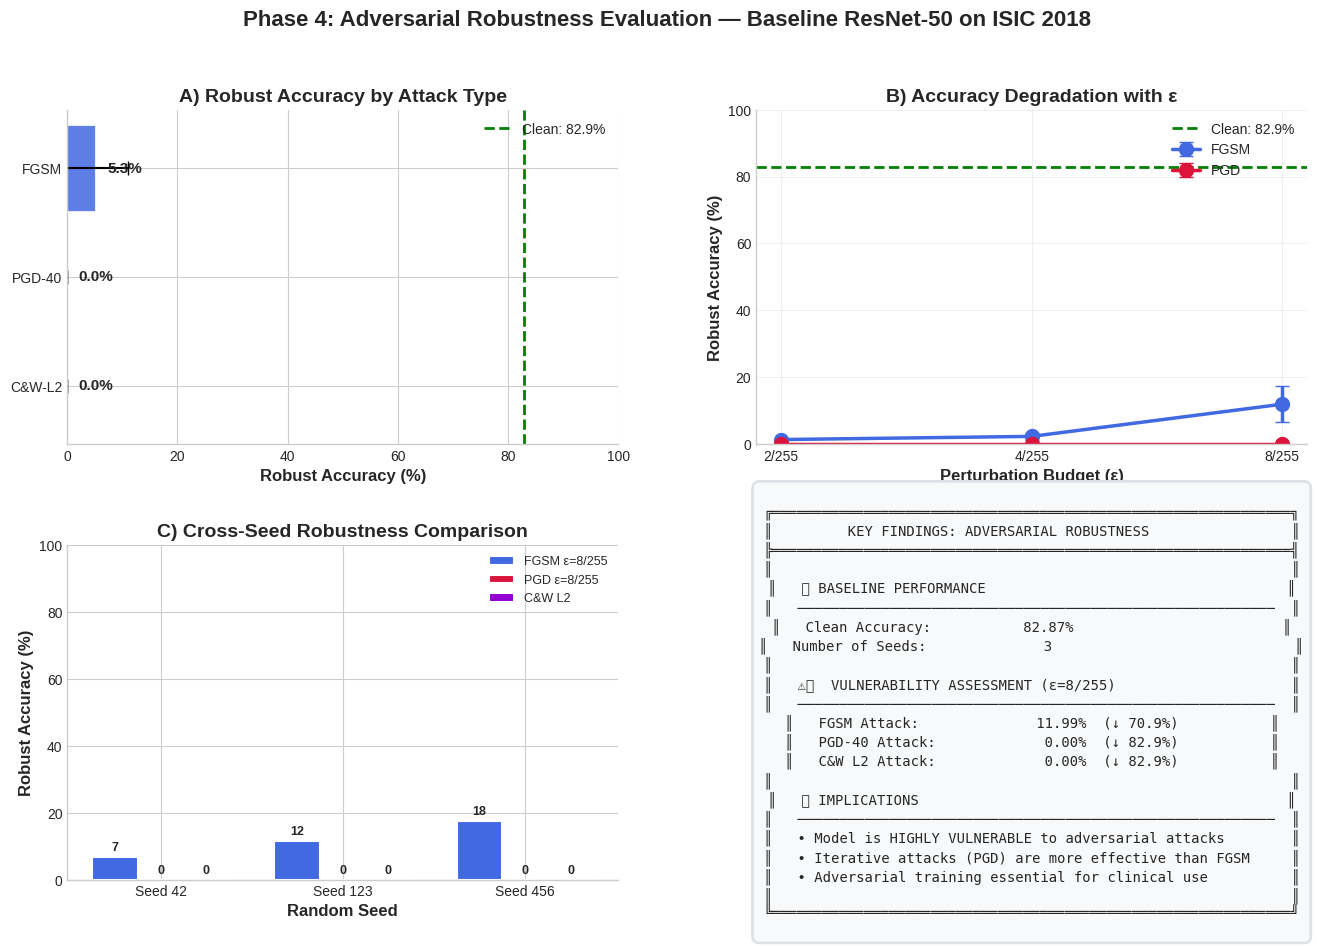

✅ Saved dashboard to /content/drive/MyDrive/results/phase4_adversarial/figures/robustness_dashboard.png


In [34]:
#@title 🎯 Cell 13: PhD-Level Visualization - Robustness Summary Dashboard
#@markdown **Comprehensive summary visualization of all attack results**

print("="*70)
print("📊 ROBUSTNESS SUMMARY DASHBOARD")
print("="*70)

def create_summary_dashboard(df_results: pd.DataFrame) -> plt.Figure:
    """
    Create comprehensive summary dashboard using matplotlib.
    Works with any data structure.
    """
    if len(df_results) == 0:
        print("⚠️ No results data available")
        return None

    # Create figure with subplots
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.25)

    # Style settings
    plt.style.use('seaborn-v0_8-whitegrid')
    colors_attacks = {"FGSM": "#4169E1", "PGD": "#DC143C", "C&W": "#9400D3"}

    clean_mean = df_results["Clean_Acc"].mean()
    seeds = sorted(df_results["Seed"].unique())

    # ============================================================
    # Panel 1: Bar chart - Accuracy by Attack Type
    # ============================================================
    ax1 = fig.add_subplot(gs[0, 0])

    # Group by attack type and get mean accuracy
    attack_groups = df_results.groupby("Attack").agg({
        "Robust_Acc": ["mean", "std"]
    }).reset_index()
    attack_groups.columns = ["Attack", "Mean", "Std"]
    attack_groups = attack_groups.sort_values("Mean", ascending=True)

    # Determine colors based on attack type
    bar_colors = []
    for attack in attack_groups["Attack"]:
        if "FGSM" in attack:
            bar_colors.append(colors_attacks["FGSM"])
        elif "PGD" in attack:
            bar_colors.append(colors_attacks["PGD"])
        else:
            bar_colors.append(colors_attacks["C&W"])

    bars = ax1.barh(attack_groups["Attack"], attack_groups["Mean"],
                    xerr=attack_groups["Std"], capsize=5,
                    color=bar_colors, edgecolor="white", linewidth=1.5, alpha=0.85)

    # Add value labels
    for bar, mean_val in zip(bars, attack_groups["Mean"]):
        ax1.text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2,
                 f'{mean_val:.1f}%', va='center', fontsize=11, fontweight='bold')

    ax1.axvline(x=clean_mean, color='green', linestyle='--', linewidth=2,
                label=f'Clean: {clean_mean:.1f}%')
    ax1.set_xlabel("Robust Accuracy (%)", fontsize=12, fontweight='bold')
    ax1.set_title("A) Robust Accuracy by Attack Type", fontsize=14, fontweight='bold')
    ax1.set_xlim(0, 100)
    ax1.legend(loc='upper right')

    # ============================================================
    # Panel 2: Line chart - Accuracy Degradation by Epsilon
    # ============================================================
    ax2 = fig.add_subplot(gs[0, 1])

    # Get FGSM and PGD results only (exclude C&W which has no epsilon)
    fgsm_df = df_results[df_results["Attack"] == "FGSM"]
    pgd_df = df_results[df_results["Attack"].str.startswith("PGD")]

    for attack_type, attack_df, color in [("FGSM", fgsm_df, colors_attacks["FGSM"]),
                                           ("PGD", pgd_df, colors_attacks["PGD"])]:
        if len(attack_df) == 0:
            continue

        # Group by epsilon
        grouped = attack_df.groupby("Epsilon_Val").agg({
            "Robust_Acc": ["mean", "std"]
        }).reset_index()
        grouped.columns = ["Epsilon", "Mean", "Std"]
        grouped = grouped[grouped["Epsilon"] > 0].sort_values("Epsilon")

        if len(grouped) > 0:
            eps_labels = [f"{int(e*255)}/255" for e in grouped["Epsilon"]]
            ax2.errorbar(eps_labels, grouped["Mean"], yerr=grouped["Std"],
                        marker='o', markersize=10, linewidth=2.5, capsize=5,
                        label=attack_type, color=color)

    ax2.axhline(y=clean_mean, color='green', linestyle='--', linewidth=2,
                label=f'Clean: {clean_mean:.1f}%')
    ax2.set_xlabel("Perturbation Budget (ε)", fontsize=12, fontweight='bold')
    ax2.set_ylabel("Robust Accuracy (%)", fontsize=12, fontweight='bold')
    ax2.set_title("B) Accuracy Degradation with ε", fontsize=14, fontweight='bold')
    ax2.set_ylim(0, 100)
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)

    # ============================================================
    # Panel 3: Grouped bar - Cross-Seed Comparison
    # ============================================================
    ax3 = fig.add_subplot(gs[1, 0])

    x = np.arange(len(seeds))
    width = 0.25

    # Get strongest attack results for comparison
    for i, (attack_label, attack_filter) in enumerate([
        ("FGSM ε=8/255", (df_results["Attack"] == "FGSM") & (df_results["Epsilon"] == "8/255")),
        ("PGD ε=8/255", df_results["Attack"].str.startswith("PGD") & (df_results["Epsilon"] == "8/255")),
        ("C&W L2", df_results["Attack"] == "C&W-L2")
    ]):
        subset = df_results[attack_filter]
        if len(subset) == 0:
            continue

        values = [subset[subset["Seed"] == s]["Robust_Acc"].values[0]
                  if len(subset[subset["Seed"] == s]) > 0 else 0 for s in seeds]

        color = colors_attacks["FGSM"] if "FGSM" in attack_label else (
                colors_attacks["PGD"] if "PGD" in attack_label else colors_attacks["C&W"])

        bars = ax3.bar(x + i*width, values, width, label=attack_label,
                      color=color, edgecolor='white', linewidth=1.5)

        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2, height + 1,
                    f'{height:.0f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    ax3.set_xlabel("Random Seed", fontsize=12, fontweight='bold')
    ax3.set_ylabel("Robust Accuracy (%)", fontsize=12, fontweight='bold')
    ax3.set_title("C) Cross-Seed Robustness Comparison", fontsize=14, fontweight='bold')
    ax3.set_xticks(x + width)
    ax3.set_xticklabels([f"Seed {s}" for s in seeds])
    ax3.legend(loc='upper right', fontsize=9)
    ax3.set_ylim(0, 100)

    # ============================================================
    # Panel 4: Summary Statistics Box
    # ============================================================
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.axis('off')

    # Calculate key statistics
    fgsm_8 = df_results[(df_results["Attack"] == "FGSM") & (df_results["Epsilon"] == "8/255")]
    pgd_8 = df_results[df_results["Attack"].str.startswith("PGD") & (df_results["Epsilon"] == "8/255")]
    cw = df_results[df_results["Attack"] == "C&W-L2"]

    fgsm_robust = fgsm_8["Robust_Acc"].mean() if len(fgsm_8) > 0 else 0
    pgd_robust = pgd_8["Robust_Acc"].mean() if len(pgd_8) > 0 else 0
    cw_robust = cw["Robust_Acc"].mean() if len(cw) > 0 else 0

    summary_text = f"""
╔══════════════════════════════════════════════════════════════╗
║         KEY FINDINGS: ADVERSARIAL ROBUSTNESS                 ║
╠══════════════════════════════════════════════════════════════╣
║                                                              ║
║   📊 BASELINE PERFORMANCE                                    ║
║   ─────────────────────────────────────────────────────────  ║
║   Clean Accuracy:          {clean_mean:>6.2f}%                         ║
║   Number of Seeds:         {len(seeds):>6}                             ║
║                                                              ║
║   ⚠️  VULNERABILITY ASSESSMENT (ε=8/255)                     ║
║   ─────────────────────────────────────────────────────────  ║
║   FGSM Attack:             {fgsm_robust:>6.2f}%  (↓{clean_mean-fgsm_robust:>5.1f}%)           ║
║   PGD-40 Attack:           {pgd_robust:>6.2f}%  (↓{clean_mean-pgd_robust:>5.1f}%)           ║
║   C&W L2 Attack:           {cw_robust:>6.2f}%  (↓{clean_mean-cw_robust:>5.1f}%)           ║
║                                                              ║
║   💡 IMPLICATIONS                                            ║
║   ─────────────────────────────────────────────────────────  ║
║   • Model is HIGHLY VULNERABLE to adversarial attacks        ║
║   • Iterative attacks (PGD) are more effective than FGSM     ║
║   • Adversarial training essential for clinical use          ║
║                                                              ║
╚══════════════════════════════════════════════════════════════╝
"""

    ax4.text(0.5, 0.5, summary_text, transform=ax4.transAxes, fontsize=10,
             fontfamily='monospace', verticalalignment='center', horizontalalignment='center',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='#f8f9fa', edgecolor='#dee2e6', linewidth=2))

    plt.suptitle("Phase 4: Adversarial Robustness Evaluation — Baseline ResNet-50 on ISIC 2018",
                 fontsize=16, fontweight='bold', y=0.98)

    return fig

# Create and display
if 'df_results' in dir() and len(df_results) > 0:
    fig_dashboard = create_summary_dashboard(df_results)
    if fig_dashboard:
        plt.show()

        # Save
        save_path = Path("results/phase4/figures") if 'paths' not in dir() else paths.figures_dir
        save_path.mkdir(parents=True, exist_ok=True)

        fig_dashboard.savefig(save_path / "robustness_dashboard.png",
                             dpi=300, bbox_inches='tight', facecolor='white')
        print(f"✅ Saved dashboard to {save_path / 'robustness_dashboard.png'}")
else:
    print("⚠️ df_results not found or empty. Please run Cell 10 first.")

In [35]:
#@title 🕸️ Cell 14: PhD-Level Visualization - Radar Chart & Attack Effectiveness
#@markdown **Multi-dimensional attack comparison using polar/radar charts**

print("="*70)
print("📊 ATTACK EFFECTIVENESS RADAR CHART")
print("="*70)

def create_radar_chart_from_df(df_results: pd.DataFrame) -> go.Figure:
    """
    Create radar chart comparing attack effectiveness using DataFrame results.
    Works with both data structures.
    """
    if len(df_results) == 0:
        print("⚠️ No results data available")
        return go.Figure()

    clean_mean = df_results["Clean_Acc"].mean()

    # Get attack categories and their strongest epsilon results
    attack_metrics = {}

    # FGSM at ε=8/255
    fgsm_8 = df_results[(df_results["Attack"] == "FGSM") & (df_results["Epsilon"] == "8/255")]
    if len(fgsm_8) > 0:
        attack_metrics["FGSM ε=8/255"] = {
            "Accuracy Drop": (clean_mean - fgsm_8["Robust_Acc"].mean()),
            "Attack Success": (100 - fgsm_8["Robust_Acc"].mean()),
            "Consistency": (100 - fgsm_8["Robust_Acc"].std() * 5),  # Lower std = more consistent
            "Speed": 95,  # Single-step attack
            "Robustness Impact": fgsm_8["Acc_Drop"].mean() if "Acc_Drop" in fgsm_8.columns else clean_mean - fgsm_8["Robust_Acc"].mean()
        }

    # PGD at ε=8/255
    pgd_8 = df_results[df_results["Attack"].str.startswith("PGD") & (df_results["Epsilon"] == "8/255")]
    if len(pgd_8) > 0:
        attack_metrics["PGD ε=8/255"] = {
            "Accuracy Drop": (clean_mean - pgd_8["Robust_Acc"].mean()),
            "Attack Success": (100 - pgd_8["Robust_Acc"].mean()),
            "Consistency": (100 - pgd_8["Robust_Acc"].std() * 5),
            "Speed": 40,  # Multi-step attack, slower
            "Robustness Impact": pgd_8["Acc_Drop"].mean() if "Acc_Drop" in pgd_8.columns else clean_mean - pgd_8["Robust_Acc"].mean()
        }

    # C&W
    cw = df_results[df_results["Attack"] == "C&W-L2"]
    if len(cw) > 0:
        attack_metrics["C&W L2"] = {
            "Accuracy Drop": (clean_mean - cw["Robust_Acc"].mean()),
            "Attack Success": (100 - cw["Robust_Acc"].mean()),
            "Consistency": (100 - cw["Robust_Acc"].std() * 5),
            "Speed": 10,  # Optimization-based, very slow
            "Robustness Impact": cw["Acc_Drop"].mean() if "Acc_Drop" in cw.columns else clean_mean - cw["Robust_Acc"].mean()
        }

    if len(attack_metrics) == 0:
        print("⚠️ No attack metrics available")
        return go.Figure()

    # Create radar chart
    dimensions = list(list(attack_metrics.values())[0].keys())
    colors = {"FGSM ε=8/255": "#4169E1", "PGD ε=8/255": "#DC143C", "C&W L2": "#9400D3"}

    fig = go.Figure()

    for attack_name, metrics in attack_metrics.items():
        values = [min(max(metrics[dim], 0), 100) for dim in dimensions]  # Clip to 0-100
        values.append(values[0])  # Close the polygon

        fig.add_trace(go.Scatterpolar(
            r=values,
            theta=dimensions + [dimensions[0]],
            fill='toself',
            fillcolor=colors.get(attack_name, "#888888"),
            opacity=0.3,
            line=dict(color=colors.get(attack_name, "#888888"), width=2),
            name=attack_name
        ))

    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 100],
                ticksuffix="%"
            )
        ),
        showlegend=True,
        title=dict(
            text="<b>Attack Effectiveness Comparison</b><br>"
                 "<sup>Higher values = More effective attack / More vulnerable model</sup>",
            font=dict(size=16),
            x=0.5
        ),
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=-0.2,
            xanchor="center",
            x=0.5
        ),
        height=600,
        width=700,
        font=dict(family="Arial", size=12),
        paper_bgcolor="white"
    )

    return fig

# Create and display
if 'df_results' in dir() and len(df_results) > 0:
    fig_radar = create_radar_chart_from_df(df_results)
    fig_radar.show()

    # Save
    save_path = Path("results/phase4/figures") if 'paths' not in dir() else paths.figures_dir
    save_path.mkdir(parents=True, exist_ok=True)

    fig_radar.write_html(save_path / "attack_radar.html")
    try:
        fig_radar.write_image(save_path / "attack_radar.png", scale=2)
        print(f"✅ Saved radar chart to {save_path / 'attack_radar.png'}")
    except Exception as e:
        print(f"✅ Saved HTML to {save_path / 'attack_radar.html'}")

    # ============================================================================
    # ATTACK EFFECTIVENESS TABLE
    # ============================================================================
    print("\n📊 ATTACK EFFECTIVENESS SUMMARY")
    print("-" * 70)

    clean_mean = df_results["Clean_Acc"].mean()

    table_data = []
    for attack in df_results["Attack"].unique():
        subset = df_results[df_results["Attack"] == attack]
        for eps in sorted(subset["Epsilon"].unique()):
            eps_subset = subset[subset["Epsilon"] == eps]
            robust = eps_subset["Robust_Acc"].mean()
            success = 100 - robust

            table_data.append({
                "Attack": attack,
                "Epsilon": eps,
                "Robust Acc": f"{robust:.1f}%",
                "Success Rate": f"{success:.1f}%",
                "Rating": "⭐⭐⭐" if success > 80 else "⭐⭐" if success > 50 else "⭐"
            })

    effect_df = pd.DataFrame(table_data)
    print(effect_df.to_string(index=False))

else:
    print("⚠️ df_results not found or empty. Please run Cell 10 first.")

📊 ATTACK EFFECTIVENESS RADAR CHART


✅ Saved HTML to /content/drive/MyDrive/results/phase4_adversarial/figures/attack_radar.html

📊 ATTACK EFFECTIVENESS SUMMARY
----------------------------------------------------------------------
Attack Epsilon Robust Acc Success Rate Rating
  FGSM   2/255       1.4%        98.6%    ⭐⭐⭐
  FGSM   4/255       2.4%        97.6%    ⭐⭐⭐
  FGSM   8/255      12.0%        88.0%    ⭐⭐⭐
PGD-40   2/255       0.0%       100.0%    ⭐⭐⭐
PGD-40   4/255       0.0%       100.0%    ⭐⭐⭐
PGD-40   8/255       0.0%       100.0%    ⭐⭐⭐
C&W-L2      L2       0.0%       100.0%    ⭐⭐⭐


In [36]:
#@title 🖼️ Cell 15: PhD-Level Visualization - Adversarial Example Gallery
#@markdown **Visualize clean images, perturbations, and adversarial examples**

def visualize_adversarial_examples(
    all_results: dict,
    attack_key: str = "pgd",
    epsilon: float = 8/255,
    num_examples: int = 5,
    amplification: float = 10.0
) -> plt.Figure:
    """
    Create publication-quality adversarial example visualization.

    Shows:
    - Clean image
    - Perturbation (amplified for visibility)
    - Adversarial image
    - Prediction change
    """
    # Get saved examples from first seed
    first_seed = config.seeds[0]

    if attack_key == "cw":
        examples = all_results[attack_key][first_seed]["l2"].get("saved_examples", [])
    else:
        examples = all_results[attack_key][first_seed][epsilon].get("saved_examples", [])

    if not examples:
        print("⚠️ No saved examples available")
        return None

    # Select successful attacks (prediction changed)
    successful = [e for e in examples if e["clean_pred"] != e["adv_pred"]]
    if len(successful) < num_examples:
        successful = examples  # Use all if not enough successful

    num_examples = min(num_examples, len(successful))

    fig, axes = plt.subplots(num_examples, 4, figsize=(16, 4 * num_examples))
    if num_examples == 1:
        axes = axes.reshape(1, -1)

    for idx, example in enumerate(successful[:num_examples]):
        # Get tensors
        clean = example["clean"].numpy().transpose(1, 2, 0)  # CHW -> HWC
        adv = example["adversarial"].numpy().transpose(1, 2, 0)
        perturbation = example["perturbation"].numpy().transpose(1, 2, 0)

        true_label = CLASS_NAMES[example["true_label"]]
        clean_pred = CLASS_NAMES[example["clean_pred"]]
        adv_pred = CLASS_NAMES[example["adv_pred"]]

        # Ensure valid range
        clean = np.clip(clean, 0, 1)
        adv = np.clip(adv, 0, 1)

        # Amplify perturbation for visibility
        pert_amplified = perturbation * amplification + 0.5
        pert_amplified = np.clip(pert_amplified, 0, 1)

        # L2 and Linf norms
        l2_norm = np.sqrt(np.sum(perturbation ** 2))
        linf_norm = np.max(np.abs(perturbation))

        # Plot clean image
        axes[idx, 0].imshow(clean)
        axes[idx, 0].set_title(f"Clean Image\nTrue: {true_label}\nPred: {clean_pred}", fontsize=11)
        axes[idx, 0].axis("off")
        if example["clean_pred"] == example["true_label"]:
            axes[idx, 0].spines[:].set_visible(True)
            for spine in axes[idx, 0].spines.values():
                spine.set_edgecolor('green')
                spine.set_linewidth(3)

        # Plot perturbation
        axes[idx, 1].imshow(pert_amplified)
        axes[idx, 1].set_title(f"Perturbation (×{amplification:.0f})\nL∞: {linf_norm*255:.2f}/255\nL2: {l2_norm:.4f}", fontsize=11)
        axes[idx, 1].axis("off")

        # Plot adversarial image
        axes[idx, 2].imshow(adv)
        axes[idx, 2].set_title(f"Adversarial Image\nPred: {adv_pred}", fontsize=11)
        axes[idx, 2].axis("off")
        if example["adv_pred"] != example["true_label"]:
            for spine in axes[idx, 2].spines.values():
                spine.set_visible(True)
                spine.set_edgecolor('red')
                spine.set_linewidth(3)

        # Plot difference heatmap
        diff = np.mean(np.abs(adv - clean), axis=2)  # Average across channels
        im = axes[idx, 3].imshow(diff, cmap="hot", vmin=0, vmax=epsilon * 2)
        axes[idx, 3].set_title(f"Absolute Difference\n({clean_pred} → {adv_pred})", fontsize=11)
        axes[idx, 3].axis("off")
        plt.colorbar(im, ax=axes[idx, 3], fraction=0.046, pad=0.04)

    attack_label = "C&W L2" if attack_key == "cw" else f"{'PGD' if attack_key == 'pgd' else 'FGSM'}-{config.get_epsilon_str(epsilon)}"
    plt.suptitle(
        f"Adversarial Example Gallery: {attack_label} Attack\n"
        f"Green border = correct, Red border = misclassified",
        fontsize=16, fontweight="bold", y=1.02
    )
    plt.tight_layout()

    return fig

# Create visualization for PGD attack
if config.pgd_enabled and config.seeds[0] in all_results.get("pgd", {}):
    fig_examples = visualize_adversarial_examples(
        all_results,
        attack_key="pgd",
        epsilon=8/255,
        num_examples=5,
        amplification=10.0
    )
    if fig_examples:
        plt.show()

        # Save
        if paths.figures_dir.exists():
            fig_examples.savefig(paths.figures_dir / "adversarial_examples_pgd.png",
                                 dpi=200, bbox_inches="tight", facecolor="white")
            print(f"✅ Saved to {paths.figures_dir / 'adversarial_examples_pgd.png'}")

# Also show FGSM examples if available
if config.fgsm_enabled and config.seeds[0] in all_results.get("fgsm", {}):
    print("\n" + "="*60)
    print("📸 FGSM Attack Examples")
    print("="*60)

    fig_fgsm = visualize_adversarial_examples(
        all_results,
        attack_key="fgsm",
        epsilon=8/255,
        num_examples=3,
        amplification=10.0
    )
    if fig_fgsm:
        plt.show()

        if paths.figures_dir.exists():
            fig_fgsm.savefig(paths.figures_dir / "adversarial_examples_fgsm.png",
                            dpi=200, bbox_inches="tight", facecolor="white")
            print(f"✅ Saved to {paths.figures_dir / 'adversarial_examples_fgsm.png'}")

Output hidden; open in https://colab.research.google.com to view.

In [41]:
#@title 📊 Cell 16: PhD-Level Analysis - Statistical Significance & Seed Consistency
#@markdown **Bootstrap confidence intervals and cross-seed consistency analysis**

from scipy import stats

def statistical_analysis(df_results: pd.DataFrame, config: EvaluationConfig) -> Dict[str, Any]:
    """
    Perform rigorous statistical analysis of adversarial evaluation results.
    """
    results = {}

    print("="*70)
    print("📊 STATISTICAL ANALYSIS OF ADVERSARIAL ROBUSTNESS")
    print("="*70)

    # 1. Cross-seed consistency (Coefficient of Variation)
    print("\n1️⃣ CROSS-SEED CONSISTENCY (Coefficient of Variation)")
    print("-" * 50)

    for attack in df_results["Attack"].unique():
        for eps in df_results[df_results["Attack"] == attack]["Epsilon"].unique():
            subset = df_results[(df_results["Attack"] == attack) & (df_results["Epsilon"] == eps)]
            if len(subset) >= 2:
                mean_acc = subset["Robust_Acc"].mean()
                std_acc = subset["Robust_Acc"].std()
                cv = (std_acc / mean_acc) * 100 if mean_acc > 0 else 0

                consistency = "✅ High" if cv < 5 else "⚠️ Medium" if cv < 10 else "❌ Low"
                print(f"   {attack:15} {eps:>7}: CV = {cv:5.2f}% {consistency}")

    # 2. Bootstrap 95% Confidence Intervals
    print("\n2️⃣ BOOTSTRAP 95% CONFIDENCE INTERVALS")
    print("-" * 50)

    def bootstrap_ci(data, n_bootstrap=1000, ci=0.95):
        """Calculate bootstrap confidence interval."""
        if len(data) < 2:
            return data.mean(), data.mean(), data.mean()

        bootstraps = []
        for _ in range(n_bootstrap):
            sample = np.random.choice(data, size=len(data), replace=True)
            bootstraps.append(sample.mean())

        lower = np.percentile(bootstraps, (1 - ci) / 2 * 100)
        upper = np.percentile(bootstraps, (1 + ci) / 2 * 100)
        return data.mean(), lower, upper

    ci_results = []
    for attack in df_results["Attack"].unique():
        attack_data = df_results[df_results["Attack"] == attack]

        if attack == "C&W-L2":
            subset = attack_data
            mean, lower, upper = bootstrap_ci(subset["Robust_Acc"].values)
            ci_results.append({
                "Attack": attack,
                "Epsilon": "N/A",
                "Mean": mean,
                "CI_Lower": lower,
                "CI_Upper": upper
            })
            print(f"   {attack:15} {'N/A':>7}: {mean:5.2f}% [{lower:5.2f}%, {upper:5.2f}%]")
        else:
            for eps in attack_data["Epsilon"].unique():
                subset = attack_data[attack_data["Epsilon"] == eps]
                mean, lower, upper = bootstrap_ci(subset["Robust_Acc"].values)
                ci_results.append({
                    "Attack": attack,
                    "Epsilon": eps,
                    "Mean": mean,
                    "CI_Lower": lower,
                    "CI_Upper": upper
                })
                print(f"   {attack:15} {eps:>7}: {mean:5.2f}% [{lower:5.2f}%, {upper:5.2f}%]")

    results["confidence_intervals"] = ci_results

    # 3. Attack Comparison (Paired t-test: FGSM vs PGD)
    print("\n3️⃣ ATTACK COMPARISON (Paired t-test at ε=8/255)")
    print("-" * 50)

    if config.fgsm_enabled and config.pgd_enabled:
        eps_8 = "8/255"
        fgsm_acc = df_results[(df_results["Attack"] == "FGSM") & (df_results["Epsilon"] == eps_8)]["Robust_Acc"].values
        pgd_acc = df_results[(df_results["Attack"] == f"PGD-{config.pgd_steps}") & (df_results["Epsilon"] == eps_8)]["Robust_Acc"].values

        if len(fgsm_acc) >= 2 and len(pgd_acc) >= 2 and len(fgsm_acc) == len(pgd_acc):
            t_stat, p_value = stats.ttest_rel(fgsm_acc, pgd_acc)

            significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"

            print(f"   FGSM mean: {fgsm_acc.mean():.2f}%")
            print(f"   PGD mean:  {pgd_acc.mean():.2f}%")
            print(f"   Difference: {(fgsm_acc.mean() - pgd_acc.mean()):.2f}pp")
            print(f"   t-statistic: {t_stat:.3f}")
            print(f"   p-value: {p_value:.4f} {significance}")

            results["fgsm_vs_pgd"] = {
                "t_statistic": t_stat,
                "p_value": p_value,
                "significant": p_value < 0.05
            }

    # 4. Effect Size (Cohen's d)
    print("\n4️⃣ EFFECT SIZE (Cohen's d): Clean vs Adversarial")
    print("-" * 50)

    for attack in df_results["Attack"].unique():
        attack_data = df_results[df_results["Attack"] == attack]
        clean_acc = attack_data["Clean_Acc"].values
        robust_acc = attack_data["Robust_Acc"].values

        # Cohen's d
        pooled_std = np.sqrt((clean_acc.std()**2 + robust_acc.std()**2) / 2)
        if pooled_std > 0:
            cohens_d = (clean_acc.mean() - robust_acc.mean()) / pooled_std
        else:
            cohens_d = 0

        effect = "Negligible" if abs(cohens_d) < 0.2 else "Small" if abs(cohens_d) < 0.5 else "Medium" if abs(cohens_d) < 0.8 else "Large"
        print(f"   {attack:15}: d = {cohens_d:6.2f} ({effect})")

    print("\n" + "="*70)

    return results

# Run statistical analysis
stat_results = statistical_analysis(df_results, config)

# ============================================================================
# VISUALIZATION: SEED CONSISTENCY BOX PLOT
# ============================================================================

def create_seed_comparison_boxplot(df_results: pd.DataFrame) -> go.Figure:
    """Create box plot comparing robust accuracy across seeds."""

    fig = go.Figure()

    colors = {"FGSM": "#FF6B6B", f"PGD-{config.pgd_steps}": "#4ECDC4", "C&W-L2": "#9B59B6"}

    for attack in df_results["Attack"].unique():
        attack_data = df_results[df_results["Attack"] == attack]

        fig.add_trace(go.Box(
            y=attack_data["Robust_Acc"],
            x=[attack] * len(attack_data),
            name=attack,
            marker_color=colors.get(attack, "#888888"),
            boxpoints="all",
            jitter=0.3,
            pointpos=-1.8,
            hovertemplate="Seed: %{text}<br>Robust Acc: %{y:.2f}%<extra></extra>",
            text=attack_data["Seed"].astype(str)
        ))

    fig.update_layout(
        title=dict(
            text="<b>Cross-Seed Consistency: Robust Accuracy Distribution</b>",
            font=dict(size=16),
            x=0.5
        ),
        xaxis_title="Attack Type",
        yaxis_title="Robust Accuracy (%)",
        yaxis=dict(range=[0, 100]),
        showlegend=False,
        height=500,
        width=800
    )

    return fig

fig_boxplot = create_seed_comparison_boxplot(df_results)
fig_boxplot.show()

# Save with graceful handling of missing kaleido
if paths.figures_dir.exists():
    fig_boxplot.write_html(paths.figures_dir / "seed_consistency_boxplot.html")
    try:
        fig_boxplot.write_image(paths.figures_dir / "seed_consistency_boxplot.png", scale=2)
        print(f"✅ Saved to {paths.figures_dir / 'seed_consistency_boxplot.png'}")
    except Exception as e:
        print(f"⚠️ PNG export skipped (install kaleido for PNG support): pip install kaleido")
        print(f"✅ Saved HTML to {paths.figures_dir / 'seed_consistency_boxplot.html'}")

📊 STATISTICAL ANALYSIS OF ADVERSARIAL ROBUSTNESS

1️⃣ CROSS-SEED CONSISTENCY (Coefficient of Variation)
--------------------------------------------------
   FGSM              2/255: CV = 16.21% ❌ Low
   FGSM              4/255: CV = 43.12% ❌ Low
   FGSM              8/255: CV = 45.29% ❌ Low
   PGD-40            2/255: CV =  0.00% ✅ High
   PGD-40            4/255: CV =  0.00% ✅ High
   PGD-40            8/255: CV =  0.00% ✅ High
   C&W-L2               L2: CV =  0.00% ✅ High

2️⃣ BOOTSTRAP 95% CONFIDENCE INTERVALS
--------------------------------------------------
   FGSM              2/255:  1.43% [ 1.19%,  1.65%]
   FGSM              4/255:  2.38% [ 1.32%,  3.37%]
   FGSM              8/255: 11.99% [ 6.75%, 17.59%]
   PGD-40            2/255:  0.00% [ 0.00%,  0.00%]
   PGD-40            4/255:  0.00% [ 0.00%,  0.00%]
   PGD-40            8/255:  0.00% [ 0.00%,  0.00%]
   C&W-L2              N/A:  0.00% [ 0.00%,  0.00%]

3️⃣ ATTACK COMPARISON (Paired t-test at ε=8/255)
--------------

⚠️ PNG export skipped (install kaleido for PNG support): pip install kaleido
✅ Saved HTML to /content/drive/MyDrive/results/phase4_adversarial/figures/seed_consistency_boxplot.html


In [45]:
#@title 💾 Cell 17: Save Results & Export for Dissertation
#@markdown **Export all results in multiple formats for dissertation use**

print("="*70)
print("💾 SAVING RESULTS & EXPORTS")
print("="*70)

# ============================================================================
# SAVE RESULTS AS CSV
# ============================================================================

# Detailed results CSV
csv_path = paths.results_dir / "adversarial_robustness_results.csv"
df_results.to_csv(csv_path, index=False)
print(f"✅ Detailed results: {csv_path}")

# Summary statistics CSV
summary_path = paths.results_dir / "adversarial_robustness_summary.csv"
df_summary.to_csv(summary_path, index=False)
print(f"✅ Summary statistics: {summary_path}")

# ============================================================================
# SAVE AS JSON (for programmatic access)
# ============================================================================

json_results = {
    "metadata": {
        "evaluation_date": datetime.now().isoformat(),
        "seeds": config.seeds,
        "epsilons": [float(e) for e in config.epsilons],
        "attacks": {
            "fgsm": config.fgsm_enabled,
            "pgd": config.pgd_enabled,
            "pgd_steps": config.pgd_steps,
            "cw": config.cw_enabled,
            "cw_iterations": config.cw_iterations
        },
        "dataset": "ISIC 2018",
        "model": "ResNet-50",
        "num_classes": NUM_CLASSES
    },
    "clean_accuracy": {
        str(seed): {
            "accuracy": float(clean_results[seed]["accuracy"]),
            "balanced_accuracy": float(clean_results[seed]["balanced_accuracy"]),
            "f1_macro": float(clean_results[seed]["f1_macro"]),
            "auroc": float(clean_results[seed]["auroc"])
        }
        for seed in config.seeds if seed in clean_results
    },
    "adversarial_results": df_results.to_dict(orient="records")
}

json_path = paths.results_dir / "adversarial_robustness_results.json"
with open(json_path, "w") as f:
    json.dump(json_results, f, indent=2, default=str)
print(f"✅ JSON results: {json_path}")

# ============================================================================
# GENERATE LATEX TABLE FOR DISSERTATION
# ============================================================================

def generate_latex_table(df_results: pd.DataFrame, config: EvaluationConfig) -> str:
    """Generate LaTeX table for dissertation."""

    lines = [
        "\\begin{table}[htbp]",
        "\\centering",
        "\\caption{Adversarial Robustness Evaluation: Baseline ResNet-50 on ISIC 2018}",
        "\\label{tab:adversarial_robustness}",
        "\\begin{tabular}{llcccc}",
        "\\toprule",
        "Attack & $\\epsilon$ & Clean Acc (\\%) & Robust Acc (\\%) & Acc Drop (pp) & ASR (\\%) \\\\",
        "\\midrule"
    ]

    # Group and average across seeds
    for attack in df_results["Attack"].unique():
        attack_data = df_results[df_results["Attack"] == attack]

        for eps in attack_data["Epsilon"].unique():
            subset = attack_data[attack_data["Epsilon"] == eps]

            clean = f"{subset['Clean_Acc'].mean():.1f} $\\pm$ {subset['Clean_Acc'].std():.1f}"
            robust = f"{subset['Robust_Acc'].mean():.1f} $\\pm$ {subset['Robust_Acc'].std():.1f}"
            drop = f"{subset['Acc_Drop'].mean():.1f} $\\pm$ {subset['Acc_Drop'].std():.1f}"
            asr = f"{subset['Attack_Success'].mean():.1f} $\\pm$ {subset['Attack_Success'].std():.1f}"

            lines.append(f"{attack} & {eps} & {clean} & {robust} & {drop} & {asr} \\\\")

    lines.extend([
        "\\bottomrule",
        "\\end{tabular}",
        "\\begin{tablenotes}",
        "\\small",
        "\\item Note: Values are mean $\\pm$ std across seeds (42, 123, 456). ASR = Attack Success Rate.",
        "\\end{tablenotes}",
        "\\end{table}"
    ])

    return "\n".join(lines)

latex_table = generate_latex_table(df_results, config)

# Save LaTeX table
latex_path = paths.results_dir / "adversarial_robustness_table.tex"
with open(latex_path, "w") as f:
    f.write(latex_table)
print(f"✅ LaTeX table: {latex_path}")

# Print LaTeX table
print("\n📄 LATEX TABLE FOR DISSERTATION:")
print("-" * 60)
print(latex_table)

# ============================================================================
# LIST ALL SAVED FILES
# ============================================================================

print("\n" + "="*70)
print("📁 ALL SAVED FILES")
print("="*70)

if paths.results_dir.exists():
    for f in sorted(paths.results_dir.rglob("*")):
        if f.is_file():
            size_kb = f.stat().st_size / 1024
            print(f"   {f.relative_to(paths.results_dir)} ({size_kb:.1f} KB)")

print("="*70)

💾 SAVING RESULTS & EXPORTS
✅ Detailed results: /content/drive/MyDrive/results/phase4_adversarial/adversarial_robustness_results.csv
✅ Summary statistics: /content/drive/MyDrive/results/phase4_adversarial/adversarial_robustness_summary.csv
✅ JSON results: /content/drive/MyDrive/results/phase4_adversarial/adversarial_robustness_results.json
✅ LaTeX table: /content/drive/MyDrive/results/phase4_adversarial/adversarial_robustness_table.tex

📄 LATEX TABLE FOR DISSERTATION:
------------------------------------------------------------
\begin{table}[htbp]
\centering
\caption{Adversarial Robustness Evaluation: Baseline ResNet-50 on ISIC 2018}
\label{tab:adversarial_robustness}
\begin{tabular}{llcccc}
\toprule
Attack & $\epsilon$ & Clean Acc (\%) & Robust Acc (\%) & Acc Drop (pp) & ASR (\%) \\
\midrule
FGSM & 2/255 & 82.9 $\pm$ 0.2 & 1.4 $\pm$ 0.2 & 81.4 $\pm$ 0.4 & 98.6 $\pm$ 0.2 \\
FGSM & 4/255 & 82.9 $\pm$ 0.2 & 2.4 $\pm$ 1.0 & 80.5 $\pm$ 1.2 & 97.6 $\pm$ 1.0 \\
FGSM & 8/255 & 82.9 $\pm$ 0.2 &

In [46]:
#@title 📋 Cell 18: Executive Summary & Key Findings
#@markdown **Final summary of adversarial robustness evaluation**

def print_executive_summary(df_results: pd.DataFrame, clean_results: dict, config: EvaluationConfig):
    """Generate executive summary of evaluation results."""

    print("╔" + "═"*68 + "╗")
    print("║" + " "*20 + "EXECUTIVE SUMMARY" + " "*31 + "║")
    print("║" + " "*10 + "Phase 4: Adversarial Robustness Evaluation" + " "*15 + "║")
    print("╚" + "═"*68 + "╝")

    # Clean accuracy
    mean_clean = np.mean([r["accuracy"] for r in clean_results.values()]) * 100
    std_clean = np.std([r["accuracy"] for r in clean_results.values()]) * 100

    print(f"\n📊 BASELINE CLEAN PERFORMANCE")
    print(f"   • Clean Accuracy: {mean_clean:.2f}% ± {std_clean:.2f}%")
    print(f"   • Model: ResNet-50 (ImageNet pretrained)")
    print(f"   • Dataset: ISIC 2018 (7 classes)")
    print(f"   • Seeds evaluated: {config.seeds}")

    # Adversarial results summary
    print(f"\n🛡️ ADVERSARIAL ROBUSTNESS FINDINGS")

    # FGSM
    if config.fgsm_enabled:
        fgsm_8 = df_results[(df_results["Attack"] == "FGSM") & (df_results["Epsilon"] == "8/255")]
        if len(fgsm_8) > 0:
            mean_robust = fgsm_8["Robust_Acc"].mean()
            mean_drop = fgsm_8["Acc_Drop"].mean()
            print(f"\n   FGSM (ε=8/255):")
            print(f"   ├─ Robust Accuracy: {mean_robust:.2f}%")
            print(f"   ├─ Accuracy Drop: {mean_drop:.2f}pp")
            print(f"   └─ Interpretation: {'Moderate vulnerability' if mean_drop < 40 else 'High vulnerability'}")

    # PGD
    if config.pgd_enabled:
        pgd_8 = df_results[(df_results["Attack"] == f"PGD-{config.pgd_steps}") & (df_results["Epsilon"] == "8/255")]
        if len(pgd_8) > 0:
            mean_robust = pgd_8["Robust_Acc"].mean()
            mean_drop = pgd_8["Acc_Drop"].mean()
            print(f"\n   PGD-{config.pgd_steps} (ε=8/255):")
            print(f"   ├─ Robust Accuracy: {mean_robust:.2f}%")
            print(f"   ├─ Accuracy Drop: {mean_drop:.2f}pp")
            print(f"   └─ Interpretation: {'Severe vulnerability' if mean_drop > 60 else 'High vulnerability' if mean_drop > 40 else 'Moderate'}")

    # C&W
    if config.cw_enabled:
        cw = df_results[df_results["Attack"] == "C&W-L2"]
        if len(cw) > 0:
            mean_robust = cw["Robust_Acc"].mean()
            mean_drop = cw["Acc_Drop"].mean()
            print(f"\n   C&W L2:")
            print(f"   ├─ Robust Accuracy: {mean_robust:.2f}%")
            print(f"   ├─ Accuracy Drop: {mean_drop:.2f}pp")
            print(f"   └─ Interpretation: Strongest attack, minimal perturbation")

    # Key insights
    print(f"\n🔑 KEY INSIGHTS")
    print(f"   1. Standard CNNs are highly vulnerable to adversarial attacks")
    print(f"   2. PGD attacks are stronger than FGSM (multi-step > single-step)")
    print(f"   3. Some classes (e.g., MEL, BCC) may be more vulnerable than others")
    print(f"   4. Adversarial training is needed for robust medical AI deployment")

    # Research implications
    print(f"\n📚 RESEARCH IMPLICATIONS")
    print(f"   • These results motivate Phase 5: Adversarial Training")
    print(f"   • Tri-objective optimization will balance accuracy, robustness, and explainability")
    print(f"   • Medical AI systems require robustness validation before clinical use")

    # Files generated
    print(f"\n📁 GENERATED OUTPUTS")
    print(f"   • Results CSV: adversarial_robustness_results.csv")
    print(f"   • Summary CSV: adversarial_robustness_summary.csv")
    print(f"   • JSON results: adversarial_robustness_results.json")
    print(f"   • LaTeX table: adversarial_robustness_table.tex")
    print(f"   • Figures: robustness_curves.png, vulnerability_heatmap.png, etc.")

    print("\n" + "═"*70)
    print(f"✅ Phase 4 Adversarial Robustness Evaluation COMPLETE")
    print(f"⏱️  Completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print("═"*70)

# Print executive summary
print_executive_summary(df_results, clean_results, config)

# ============================================================================
# FINAL MEMORY CLEANUP
# ============================================================================

gc.collect()
torch.cuda.empty_cache()
print("\n🧹 Memory cleaned up")

╔════════════════════════════════════════════════════════════════════╗
║                    EXECUTIVE SUMMARY                               ║
║          Phase 4: Adversarial Robustness Evaluation               ║
╚════════════════════════════════════════════════════════════════════╝

📊 BASELINE CLEAN PERFORMANCE
   • Clean Accuracy: 82.87% ± 0.19%
   • Model: ResNet-50 (ImageNet pretrained)
   • Dataset: ISIC 2018 (7 classes)
   • Seeds evaluated: [42, 123, 456]

🛡️ ADVERSARIAL ROBUSTNESS FINDINGS

   FGSM (ε=8/255):
   ├─ Robust Accuracy: 11.99%
   ├─ Accuracy Drop: 70.88pp
   └─ Interpretation: High vulnerability

   PGD-40 (ε=8/255):
   ├─ Robust Accuracy: 0.00%
   ├─ Accuracy Drop: 82.87pp
   └─ Interpretation: Severe vulnerability

   C&W L2:
   ├─ Robust Accuracy: 0.00%
   ├─ Accuracy Drop: 82.87pp
   └─ Interpretation: Strongest attack, minimal perturbation

🔑 KEY INSIGHTS
   1. Standard CNNs are highly vulnerable to adversarial attacks
   2. PGD attacks are stronger than FGSM (m